In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.convolution import Gaussian2DKernel,Tophat2DKernel,Gaussian1DKernel
from astropy.convolution import convolve, convolve_fft
from astropy.coordinates import SkyCoord
import glob
from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker

%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep
import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')
import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')

from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import c
from scipy import stats
from scipy import interpolate

#import comfun
cosmo = FlatLambdaCDM(H0=69.6 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.286)

BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'


def select_columns_starting_with(data, prefixes):
    selected_columns = [col for col in data.columns if col.startswith(tuple(prefixes))]
    return selected_columns

def add_band_suffix(data, column_list, band_suffix):
    for column in column_list:
        data[column + '_' + band_suffix] = data[column]
        del data[column]
    return data


def abmag_to_nJy(abmag):
    # 计算光通量密度（Jy）
    F_ergHz = 10**(-0.4 * (abmag + 48.6))
    # 转换为 nJy
    F_nJy = F_ergHz * 1e9 * 1e23
    return F_nJy

def abmag_to_nJyerr(abmag, delta_abmag=0.0):
    # 计算光通量密度（Jy）
    F_ergHz = 10**(-0.4 * (abmag + 48.6))
    # 转换为 nJy
    F_nJy = F_ergHz * 1e9 * 1e23
    # 计算误差传递
    delta_F_nJy = F_nJy * np.log(10) * 0.4 * delta_abmag
    return delta_F_nJy

# 读取滤波器透过率数据
def read_filter_data(filename):
    data = np.loadtxt(filename, skiprows=1)
    wavelength = data[:, 0]
    throughput = data[:, 1]
    return wavelength, throughput

def mark_emission_lines(ax,z):
    lines = {
    '[OII]': 0.3727,      # [OII] 双峰 (合并值)
    'Hγ': 0.4340,         # Hγ
    '[OIII]': 0.5007,     # [OIII]
    'Hβ': 0.4861,         # Hβ
    'Hα': 0.6563,         # Hα
    'Paα': 1.8756,        # Paschen-alpha (Paα)

}
    for line, rest_wave in lines.items():
        # for z in [5.5, 7.5]:  # 以两个红移值为例
        obs_wave = rest_wave * (1 + z)
        if obs_wave < 0.7 or obs_wave > 5.0:
            continue
        ax.axvline(obs_wave, linestyle='--', color='grey')
        ax.text(obs_wave, 1, f'{line}', rotation=90, verticalalignment='bottom',fontsize=16)
fsize = 15
tsize = 15
tdir = 'in'
major = 18.0
minor = 16.0
lwidth = 0.8
lhandle = 2.0
labelpad = 5.5

%matplotlib inline
#%matplotlib qt5
fontsize= 21
tsize = 15
tdir = 'in'
major = 7.0
minor = 4.0
lwidth = 2
lhandle = 2.0
labelpad = 5.5
spiwidth = 2

plt.style.use('default')
#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['xtick.major.width'] = lwidth
plt.rcParams['ytick.major.width'] = lwidth
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

locsize = 14.4
fontsize= 21
stiksize = 19
labelsize = 26
elinewidth = 1
capsize = 0
dotsize = 9
bottom = 0.07
left = 0.05
width = 0.45
height = 0.43
gap = 0.02
semiheight = 0.205
bigdotsize = 14

# 定义滤波器文件和对应的颜色
filter_files = {
    'F115W': ('/nircam_throughputs/mean_throughputs/F115W_mean_system_throughput.txt', 'orange'),
    'F150W': ('/nircam_throughputs/mean_throughputs/F150W_mean_system_throughput.txt', 'orange'),
    'F200W': ('/nircam_throughputs/mean_throughputs/F200W_mean_system_throughput.txt', 'orange'),
    'F277W': ('/nircam_throughputs/mean_throughputs/F277W_mean_system_throughput.txt', 'orange'),
    'F356W': ('/nircam_throughputs/mean_throughputs/F356W_mean_system_throughput.txt', 'orange'),
    'F444W': ('/nircam_throughputs/mean_throughputs/F444W_mean_system_throughput.txt', 'orange')
}

import astropy.constants as const


def get_UV_flux(NIRCAM_restwave, NIRCAM_flux, NIRCAM_flux_errors, redshift, figsavepath=None):
    # 将 flux 从 nJy 转换为 erg/s/Hz 使用 astropy 的单位
    blue_mask = NIRCAM_restwave < 3646
    NIRCAM_restwave = NIRCAM_restwave[blue_mask]
    NIRCAM_flux = NIRCAM_flux[blue_mask]
    NIRCAM_flux_errors = NIRCAM_flux_errors[blue_mask]
    flux_nJy = NIRCAM_flux * u.nJy
    flux_nJy_err = NIRCAM_flux_errors * u.nJy
    wavelength = NIRCAM_restwave * u.AA 
 
    # 将 flux 从 nJy 转换为 erg/s/Hz
    flux_erg_s_Hz = flux_nJy.to(u.erg / (u.s * u.Hz * u.cm**2), equivalencies=u.spectral_density(wavelength))
    flux_erg_s_Hz_err = flux_nJy_err.to(u.erg / (u.s * u.Hz * u.cm**2), equivalencies=u.spectral_density(wavelength))   

    # 线性拟合
    # slope, intercept, r_value, p_value, std_err = stats.linregress(NIRCAM_restwave, flux_erg_s_Hz.value)
    # rest_NUV = 2310  # NUV 波长 (单位: Å)
    # rest_FUV = 1530  # FUV 波长 (单位: Å)
    # # 计算 NUV 和 FUV 的光度（erg/s/Hz）
    # L_NUV = slope * rest_NUV + intercept
    # L_FUV = slope * rest_FUV + intercept
    # 使用三次样条插值
    spline = interpolate.CubicSpline(NIRCAM_restwave, flux_erg_s_Hz.value)  

    # 使用样条插值计算 rest-frame NUV 和 FUV（假设 NUV 是 2310 Å，FUV 是 1530 Å）
    rest_NUV = 2310  # NUV 波长 (单位: Å)
    rest_FUV = 1530  # FUV 波长 (单位: Å)   
    
    Hz_NUV = (const.c / (rest_NUV * u.AA)).to(u.Hz)
    Hz_FUV = (const.c / (rest_FUV * u.AA)).to(u.Hz)

    # 计算 NUV 和 FUV 的光度（erg/s/Hz）
    F_NUV = spline(rest_NUV)*u.erg / (u.s * u.Hz * u.cm**2)
    F_FUV = spline(rest_FUV)*u.erg / (u.s * u.Hz * u.cm**2)    

    lumi_dist = cosmo.luminosity_distance(redshift).to(u.cm)
    L_NUV = (4 * np.pi * lumi_dist**2 * F_NUV * Hz_NUV).to(u.erg/u.s).value
    L_FUV = (4 * np.pi * lumi_dist**2 * F_FUV * Hz_FUV).to(u.erg/u.s).value

    # 显示结果
    # print(f"Slope: {slope:.3e}, Intercept: {intercept:.3e}")
    print(f"Rest-frame NUV flux: {L_NUV:.3e} erg/s")
    print(f"Rest-frame FUV flux: {L_FUV:.3e} erg/s") 

    # 绘制拟合图
    plt.figure(figsize=(8, 6))
    plt.errorbar(NIRCAM_restwave, flux_erg_s_Hz.value, yerr = flux_erg_s_Hz_err.value, fmt='o', label='Data', color='black')
    # plt.plot(NIRCAM_restwave, slope * NIRCAM_restwave + intercept, label='Linear Fit', color='blue')
    x = np.linspace(NIRCAM_restwave[0] - 50, NIRCAM_restwave[-1] + 50, 1000)
    plt.plot(x, spline(x), label='Cubic Spline', color='red')
    # plot the point of NUV and FUV
    plt.scatter(rest_NUV, F_NUV.value, s=100, c='red', marker='x', label='Rest-frame NUV')
    plt.scatter(rest_FUV, F_FUV.value, s=100, c='blue', marker='x', label='Rest-frame FUV')
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux (erg/s/Hz)")
    plt.title("Flux vs. Wavelength with Linear Fit")
    plt.legend()
    plt.grid(True)
    # plt.show()
    if figsavepath:
        plt.savefig(figsavepath, dpi=300, bbox_inches='tight')
    plt.close()

    return L_NUV, L_FUV

grizli version: 1.12.9
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
msaexp version: 0.9.2


In [2]:
def binspec(wavelength, smoothspec, error, bin_width=5):

    # 创建新的波长数组，定义 bin 的中心点
    binned_wavelength = np.arange(wavelength[0], wavelength[-1], bin_width)

    # 初始化 binned 光谱和误差
    binned_spec = []
    binned_error = []

    # 对每个 bin 进行平均
    for i in range(len(binned_wavelength) - 1):
        # 找到属于当前 bin 的数据点
        idx = (wavelength >= binned_wavelength[i]) & (wavelength < binned_wavelength[i + 1])
        if np.any(idx):  # 确保有点落入 bin
            mean_value = np.mean(smoothspec[idx])  # 平均光谱值
            # 误差使用平方和的开方计算
            mean_error = np.sqrt(np.sum(error[idx]**2) / np.sum(idx))
            
            binned_spec.append(mean_value)
            binned_error.append(mean_error)
        else:
            binned_spec.append(np.nan)  # 如果 bin 没有数据，用 NaN 填充
            binned_error.append(np.nan)

    # 转换为 numpy 数组
    binned_spec = np.array(binned_spec)
    binned_error = np.array(binned_error)

    # 去除 NaN 的 bin（可选）
    valid_idx = ~np.isnan(binned_spec)
    binned_wavelength = binned_wavelength[:-1][valid_idx]
    binned_spec = binned_spec[valid_idx]
    binned_error = binned_error[valid_idx]

    return binned_wavelength, binned_spec, binned_error



def scale_flux(wave, flux, target_wave=1.5):
    # 使用线性插值计算目标波长处的flux
    target_flux = np.interp(target_wave, wave, flux)
    return flux / target_flux




In [8]:
errkey = []
for i in catalog.keys():
    if('MAGERR' in i):
        errkey.append(i)

NIRCAM_filter = [i.split('_')[1] for i in errkey]
NIRCAM_filter

['F070W',
 'F090W',
 'F115W',
 'F140M',
 'F150W',
 'F162M',
 'F182M',
 'F200W',
 'F210M',
 'F250M',
 'F277W',
 'F300M',
 'F335M',
 'F356W',
 'F360M',
 'F410M',
 'F430M',
 'F444W',
 'F460M',
 'F480M']

# Plot SED

In [4]:
# NIRCAM_filter = fits.getdata('/Users/zijianzhang/Astro_Data/JWST/SMILES_MIRI/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits',1).field(0)[:14]
# HST_ACS_filter = fits.getdata('/Users/zijianzhang/Astro_Data/JWST/SMILES_MIRI/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits',1).field(0)[14:19]
# HST_WFC3_filter = fits.getdata('/Users/zijianzhang/Astro_Data/JWST/SMILES_MIRI/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits',1).field(0)[19:]


# jadefilter = fits.getdata('/Users/zijianzhang/Astro_Data/JWST/SMILES_MIRI/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits',1).field(0)
# jadewave = fits.getdata('/Users/zijianzhang/Astro_Data/JWST/SMILES_MIRI/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits',1).field(1)
# jadefilter = 
# MIRIwave = [5.635,7.639,9.953,12.810,15.064,17.984,20.795,25.365]
# MIRI_filter = ['560','770','1000','1280','1500','1800','2100','2550']


# cat = '/JDisk16T_1/zijianzhang/phot_catalog/LRD_SED_ECDFS.fits'
# cat = '/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/UDS_lrd_catalog.txt'
cat = '/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/all_lrd_catalog.txt'
# cat = 'LRD_SED_UDS.fits'
catalog = Table.read(cat, format='ascii')



# NIRCAMfilter = list(set([i.split('_')[1] if 'FLUXERR_' in i else '' for i in catalog.keys()]))[1:]
# NIRCAM_filter = ['F090W', 'F115W', 'F140M', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M', 'F430M',
#        'F444W', 'F460M']
NIRCAM_filter = ['F070W','F090W','F115W','F140M','F150W','F162M','F182M','F200W','F210M','F250M','F277W',
                 'F300M','F335M','F356W','F360M','F410M','F430M','F444W','F460M','F480M']
NIRCAM_filter = np.array(NIRCAM_filter)
NIRCAM_filter.sort()
# NIRCAMwave = [
#     0.704, 0.901, 1.154, 1.404, 1.501, 1.626, 1.845, 
#     1.990, 2.093, 2.503, 2.786, 2.996, 3.365, 3.563, 
#     4.092, 4.280, 4.421, 4.624, 4.834
# ]         #ECDFS

# NIRCAMwave = [
#     0.901, 1.154, 1.501, 1.990, 2.786, 3.563, 
#     4.092, 4.421]   #COSMOSmy

# NIRCAMwave = [
#     0.901, 1.154, 1.501, 1.990, 2.786, 3.563, 
#     4.092, 4.421]   #COSMOS

# NIRCAMwave = [
#     0.901, 1.154, 1.404, 1.501, 
#     1.990, 2.786, 3.563, 
#     4.092, 4.280, 4.421, 4.624
# ]         #UDS

NIRCAMwave = [ 0.7, 0.901, 1.154, 1.404, 1.501, 1.62, 1.82,
    1.990, 2.1, 2.5, 2.786, 3.0, 3.35, 3.563, 3.60, 
    4.092, 4.280, 4.421, 4.624, 4.8
]         #UDS




In [6]:
def get_NIRSpec_data(srcid, target_reso = 'prism'):
    src = np.array(srcidlist == srcid)
    nrs['root','file','Grating','z','grade'][src]
    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    nrs[src]['root','file','Grating','z','grade', 'References']

    # Open the files into 1D objects, directly from the web
    sobj = {}
    try:
        for u in urls:
            print(f'Read {u}')
            key = os.path.basename(u)
            sobj[key] = msaexp.spectrum.SpectrumSampler(u)
    except:
        return None

    for j, k in enumerate(sobj):
        print(k)
        if target_reso in k:
            break
    sp = sobj[k]

    return sp, z, k

In [11]:
get_NIRSpec_data(24278, target_reso = 'prism')

Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_24278.spec.fits
uncover-v3_prism-clear_2561_24278.spec.fits


(<msaexp.spectrum.SpectrumSampler at 0x3c182c490>,
 3.6969,
 'uncover-v3_prism-clear_2561_24278.spec.fits')

In [10]:
nrs = catalog

srcidlist = nrs['srcid']
id = '40579' # z=4.1
ymax = [18, 3, 18, 18]
xlimits = [(0.5, 5.4), (0.5, 2.2), (2.2, 2.8), (3.18, 3.6)]



Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_38108.spec.fits
uncover-v3_prism-clear_2561_38108.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_41225.spec.fits
uncover-v3_prism-clear_2561_41225.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_23608.spec.fits
uncover-v3_prism-clear_2561_23608.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-61-v3/uncover-61-v3_prism-clear_2561_21547.spec.fits
uncover-61-v3_prism-clear_2561_21547.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_24278.spec.fits
uncover-v3_prism-clear_2561_24278.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_28876.spec.fits
uncover-v3_prism-clear_2561_28876.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extraction

KeyboardInterrupt: 

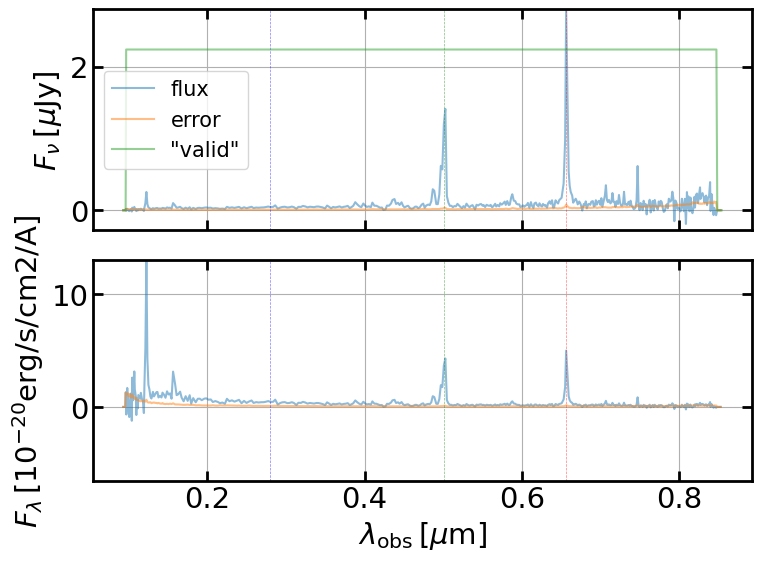

In [12]:
# savetop_ = '/Users/zijianzhang/Documents/JWST_learning/NIRSpec/LRD/'
savetop_ = '/Users/zijianzhang/Astro_Data/LRD_SPEC/SED/'
os.makedirs(savetop_, exist_ok=True) 
narrowid = np.array([    1236,     1294,     1465,     3044,     4273,     9925,
          13560,    26611,    31078,    40800,    53254,    53692,
          55637,    57375,   125917,   830237,   916674,   927271,
         928474,   961025, 10013560])

# is_gds = np.array([f.startswith('rubies-uds') for f in nrs['file']])

Grating = [i.split('_')[1] for i in nrs['file']]

# for i in range(len(narrowid)):
for i in range(len(srcidlist)):
    # savetop = savetop_ + Grating[i] + '/'    
    # os.makedirs(savetop, exist_ok=True)

    # i = 0
    srcid = srcidlist[i]
    # if(srcid in narrowid):
    #     continue
    sp, z, k = get_NIRSpec_data(srcidlist[i], target_reso = 'prism')
    if('prism' not in k):
        continue

    fig, axes = plt.subplots(2,1,figsize=(8,6), sharex=True)
    ax = axes[0]
    # ymax = [8, 4, 8, 8]
    # for c in ['flux','err']:
    wave, flux, error = binspec(sp.spec_wobs, sp.spec['flux'], sp.spec['err'], bin_width=0.004)
    # ax.plot(sp.spec_wobs/(1 + z), sp.spec[c], alpha=0.5, label=c)
    ax.plot(wave/(1 + z), flux, alpha=0.5, label='flux')
    ax.plot(wave/(1 + z), error, alpha=0.5, label='error')
    ymax = max(flux)
    #ax.plot(sp.spec_wobs, sp.spec['err'], alpha=0.5, label='err')
    #ax.plot(sp.spec_wobs, sp.spec['full_err'], alpha=0.5, label='full_err')
    ax.axvline(x = 0.6568, color='r', linestyle='--', lw = 0.5, alpha=0.5)
    ax.axvline(x = 0.5007, color='g', linestyle='--', lw = 0.5, alpha=0.5)
    ax.axvline(x = 0.2798, color='b', linestyle='--', lw = 0.5, alpha=0.5)

    ax.set_ylim(-0.1*ymax, ymax)
    ax.plot(sp.spec_wobs/(1 + z), sp.valid*ymax*0.8, alpha=0.5, label='"valid"')
    ax.grid()
    ax.legend(fontsize = 15)
    ax.set_ylabel(r'$F_\nu\,[\mu\mathrm{Jy}]$')

    ax = axes[1]
    # for c in ['flux','err']:
    #     ax.plot(sp.spec_wobs/(1 + z), sp.spec[c]*sp.spec['to_flam'], alpha=0.5, label=c)

    wave, flux, error = binspec(sp.spec_wobs, sp.spec['flux']*sp.spec['to_flam'], sp.spec['err']*sp.spec['to_flam'], bin_width=0.004)
    # ax.plot(sp.spec_wobs/(1 + z), sp.spec[c], alpha=0.5, label=c)
    ax.plot(wave/(1 + z), flux, alpha=0.5, label='flux')
    ax.plot(wave/(1 + z), error, alpha=0.5, label='error')

    ymax = max(flux)
    ax.set_ylim(-0.1*ymax*5, ymax)
    ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm2/A}]$')
    ax.grid()
    ax.axvline(x = 0.6568, color='r', linestyle='--', lw = 0.5, alpha=0.5)
    ax.axvline(x = 0.5007, color='g', linestyle='--', lw = 0.5, alpha=0.5)
    ax.axvline(x = 0.2798, color='b', linestyle='--', lw = 0.5, alpha=0.5)
    ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')

    _ = fig.tight_layout(pad=1)

    # Save the figure
    fig_file = f'{srcidlist[i]}_spectrum.png'
    fig.savefig(savetop_ + fig_file, dpi=100, bbox_inches='tight')
    # plt.show()
    plt.close(fig)

In [13]:
# jadekey = ['{}_KRON'.format(i)  for i in NIRCAM_filter]
# jadeerrkey = ['{}_KRON_e'.format(i)  for i in NIRCAM_filter]
NIRCAM_key = ['MAG_{}'.format(i)  for i in NIRCAM_filter]
NIRCAM_flagkey = ['FLAGS_{}'.format(i)  for i in NIRCAM_filter]
# NIRCAM_flagkey = ['IMAFLAGS_ISO_{}'.format(i)  for i in NIRCAM_filter]
NIRCAM_errkey = ['MAGERR_{}'.format(i)  for i in NIRCAM_filter]
# MIRIkey = ['MAG_AUTO_{}w'.format(i)  for i in MIRI_filter]
# MIRIerrkey = ['MAGERR_AUTO_{}w'.format(i)  for i in MIRI_filter]

filters_wavelength = {
    'F070W': 0.7, 'F090W': 0.9, 'F115W': 1.15,  'F150W': 1.5, 'F164N': 1.64,
     'F200W': 2.0,'F277W': 2.77,  'F162M': 1.62, 'F182M': 1.82, "F187N": 1.87,
    'F300M': 3.0, 'F335M': 3.35, 'F356W': 3.56, 'F360M': 3.6, 'F210M': 2.1, 'F250M': 2.5, 'F410M': 4.1, 'F430M': 4.3, 'F140M': 1.4,
    'F444W': 4.44, 'F460M': 4.6, 'F480M': 4.8, 'F435W': 0.435, 'F606W': 0.606, 'F814W': 0.814
}

In [14]:
# A24SED = Table.read('COSMOS-Web_LRDs_stacked_SED.dat', format='ascii')
logwavrest =  [-0.9446945485921121, -0.8928204146799245, -0.6739518222322851, -0.5523033930127172, -0.4105158147222723, -0.29872240536039274, -0.2364959183997406, -0.20780584898094, 0.030024237730416514, 0.40586988534622126]
logfnu = [-2.0256648584585326, -1.6955762461096455, -1.6767024393167569, -1.6461417401236114, -1.4086903227272085, -0.9724877821488622, -0.8379075053929652, -0.6550865943673418, -0.4491036053475783, -0.2544440303755766]
fnu = 10**np.array(logfnu)
restwave = 10**np.array(logwavrest)
# plt.scatter(restwave, logfnu, s=3)


In [15]:
def plot_SED_src(large_subplot, df, name, symbol, color, factor=1.0):
    global filters_wavelength, NIRCAM_filter, kron_cols, kron_err_cols
    wavelengths = [filters_wavelength[band] for band in NIRCAM_filter]
    wavelengths = np.array(wavelengths)
    NIRCAM_MAG = df[NIRCAM_key].values.flatten()
    NIRCAM_MAGerr = df[NIRCAM_errkey].values.flatten()
    # NIRCAM_flux = NIRCAM_MAG
    # NIRCAM_fluxerr = NIRCAM_MAGerr
    mask = (NIRCAM_MAG != 99) * (NIRCAM_MAGerr > 0)
    NIRCAM_flux = abmag_to_nJy(NIRCAM_MAG)#/1e3
    NIRCAM_fluxerr = abmag_to_nJyerr(NIRCAM_MAG, NIRCAM_MAGerr)#/1e3
    wavelengths = np.array(NIRCAMwave)[mask]
    fluxes = NIRCAM_flux[mask]
    flux_errors = NIRCAM_fluxerr[mask]
    large_subplot.errorbar(wavelengths, fluxes*factor, yerr=flux_errors, 
                           color=color, ecolor=color, fmt=symbol, markersize=20,
                           elinewidth=0.5, capsize=2, capthick=1, markerfacecolor='none', label = name)
    # large_subplot.scatter(restwave*(1+z), fnu/np.mean(fnu)*np.mean(NIRCAM_flux)*2.4, s=100, c='red', marker='x', label='Akin24 mean SED')
    large_subplot.tick_params(axis='both', which='major', labelsize=20, direction='in')
    large_subplot.set_xlabel(r'Observed Wavelength $(\mu \rm m)$', fontsize=20)
    # large_subplot.set_ylabel('MAG', fontsize=20)
    large_subplot.set_ylabel('Flux (nJy)', fontsize=20)
    large_subplot.set_xticks([1,1.5,2,3,4,5])
    large_subplot.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    large_subplot.minorticks_off()
    
    return wavelengths, fluxes, flux_errors

In [115]:
catalog

<Table length=294>
     ID         Ra_1    ...         L_NUV                  L_FUV         
   str13      float64   ...        float64                float64        
------------ ---------- ... ---------------------- ----------------------
        4535   3.530005 ...  1.807982020629444e+44   3.12938291147565e+44
        3989   3.533994 ...  5.998835949190748e+44 3.0390332196134188e+44
       23608   3.542815 ...  5.476856629356304e+44  6.669250330358982e+44
        9904   3.550837 ... 2.2022708329535887e+44 2.7503605699941468e+44
       26742   3.567011 ... 2.0977243274383039e+43  4.608982619998272e+43
       25119    3.56959 ... 1.1169170102219831e+44  7.190478924371993e+43
GLASS_150029   3.577167 ... 2.6951379540436004e+44  3.809107249641667e+44
GLASS_150029   3.577167 ... 2.6949991103821793e+44  3.808920289816094e+44
        9497   3.579833 ...  2.116148243262647e+44 3.4315621791553895e+44
        9497   3.579833 ...  2.115899674722863e+44 3.4311451058745155e+44
         ...        ... ...                    ...                    ...
 CEERS_01236 215.145292 ...                    nan                    nan
 CEERS_01236 215.145292 ...                    nan                    nan
 CEERS_01665 215.178208 ...                    nan                    nan
 CEERS_01665 215.178208 ...                    nan                    nan
 CEERS_01665 215.178208 ...                    nan                    nan
 CEERS_01665 215.178208 ...                    nan                    nan
 CEERS_01244 215.240667 ...                    nan                    nan
 CEERS_01244 215.240667 ...                    nan                    nan
 CEERS_01244 215.240667 ...                    nan                    nan
 CEERS_01244 215.240667 ...                    nan                    nan

In [17]:
get_NIRSpec_data(srcid)

Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_38108.spec.fits
uncover-v3_prism-clear_2561_38108.spec.fits


(<msaexp.spectrum.SpectrumSampler at 0x3d56341f0>,
 4.962,
 'uncover-v3_prism-clear_2561_38108.spec.fits')

In [18]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.convolution import Tophat2DKernel
import astropy.units as u
import numpy as np
import os
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# savetop = '/JDisk16T_1/zijianzhang/LRD_SED/ECDFS/'
savetop = '/Users/zijianzhang/Astro_Data/LRD_SPEC/SEDs/'
# savetop = '/Users/zijianzhang/Astro_Data/LRD_SPEC/narrowHa_SEDs/'

# savetop = '/JDisk16T_1/zijianzhang/LRD_SED/COSMOS/'

# savetop = '/JDisk16T_1/zijianzhang/LRD_SED/vari/'
# cutoutsave = '/JDisk16T_1/zijianzhang/LRD_spec/cutoutsave/'
os.makedirs(savetop, exist_ok=True)
imgsize = 1.5


for ind in range(len(catalog)):
# for ind in range(1):
    # ind = 0
    id = catalog['ID'][ind]
    srcid = catalog['srcid'][ind]
    # if(srcid not in narrowid):
    #     continue

    print('ID:', id)
    # if(os.path.exists(savetop + str(id) + '.png')):
    #     print('skip', id)
    #     continue
    # srcindex = catalog['ID'][ind]

    # ind_aper = (catalog['ID'] == 41841)|(catalog['ID'] == 41842)#|(catalog['ID'] == 41843)|(catalog['ID'] == 41840)
    # for ind in range(len(catalog)):

    # if(srcindex not in [584]): continue
    z = catalog['z'][ind]
    print('redshift:', z)
    # if(z == 0):
    #     z = catalog[ind]['z_phot']
    fig = plt.figure(figsize=(13, 11))

    # # 创建GridSpec对象，调整行高比例和子图间距
    # gs = GridSpec(4, 8, figure=fig, height_ratios=[2, 1, 1,1], hspace=0.5, wspace=0.0)
    # # 添加SED plot
    # large_subplot = fig.add_subplot(gs[0:2, :])

    # 主 GridSpec
    gs_main = GridSpec(3, 8, figure=fig, height_ratios=[0.5, 1, 1], hspace=0., wspace=0.0, bottom = -0.05)
    # 添加 SED plot
    large_subplot = fig.add_subplot(gs_main[0:2, :])
    gs_bottom = GridSpec(2, 12, figure=fig, top=0.25, bottom=0.0, hspace=0, wspace=0.0)

    position = SkyCoord(catalog[ind]['Ra_1'], catalog[ind]['Dec_1'], frame='icrs', unit=u.deg)
    num = 0
    # goodfilter = []
    # for i in range(2):  # 四行
    #     col = 0
    #     for j in range(24):  # 十一列
    #         if(num >= len(NIRCAM_filter)):
    #             continue
    #         file = img_filelist[num]
    #         # print(file)
    #         if(img_filelist[num].split('/')[-1].split('_')[1].split('.')[0] in ['f435w', 'f606w', 'f814w']):
    #             wcs = WCS(fits.getheader(file, 0))
    #         # try:
    #         else:
    #             wcs = WCS(fits.getheader(file, 1))
            
                
    #         data = fits.getdata(file)
    #         # dataerr = fits.getdata(file.replace('SCI', 'ERR'))
    #         kernel = Tophat2DKernel(1)
    #         # try:
    #         cutout = Cutout2D(data, position, imgsize*u.arcsec, wcs=wcs)
    #         if(np.isnan(cutout.data).all()):
    #             num += 1
    #             continue
    #         try:
    #             hdu = fits.PrimaryHDU(data=cutout.data, header=cutout.wcs.to_header())
    #             # Save to a FITS file
    #             hdu.writeto(cutoutsave + f'{str(id)}_{NIRCAM_filter[num]}.fits', overwrite=True)
    #             # hdu = fits.PrimaryHDU(data=cutouterr.data, header=cutouterr.wcs.to_header())
    #             # Save to a FITS file
    #             # hdu.writeto(cutoutsave + f'{str(srcindex)}_{NIRCAM_filter[num]}.err.fits', overwrite=True)     
    #         except:
    #             0
    #         # small_subplot = fig.add_subplot(gs[i, col])
    #         small_subplot = fig.add_subplot(gs_bottom[i, col])
    #         col += 1
    #         small_subplot.set_aspect('equal')
    #         small_subplot.set_xticks([])
    #         small_subplot.set_yticks([])
    #         small_subplot.text(0.01, 0.97, NIRCAM_filter[num], transform=small_subplot.transAxes, fontsize=10, va='top', ha='left', fontweight='bold')
    #         interval = MinMaxInterval()
    #         vmin, vmax = interval.get_limits(cutout.data)
    #         norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())
    #         small_subplot.imshow(cutout.data, origin='lower', cmap='RdBu_r', norm=norm)

    #         # Put scale bar on the image
    #         (img_size_x, img_size_y) = cutout.data.shape
    #         # if scale_bar:
    #         scale_bar_length = 0.3  # arcsec
    #         pixel_scale = 0.03  # arcsec/pixel
    #         scale_bar_y_offset = 1.5
    #         scale_bar_fontsize = 10
    #         scale_bar_x_0 = int(img_size_x * 0.95 - 
    #                             (scale_bar_length / pixel_scale))
    #         scale_bar_x_1 = int(img_size_x * 0.95)
    #         scale_bar_y = int(img_size_y * 0.10)
    #         scale_bar_text_x = (scale_bar_x_0 + scale_bar_x_1) / 2
    #         scale_bar_text_y = (scale_bar_y * scale_bar_y_offset)
    #         scale_bar_text = r'$%.1f^{\prime\prime}$' % np.round(scale_bar_length,1)
    #         scale_bar_text_size = scale_bar_fontsize

    #         small_subplot.plot([scale_bar_x_0, scale_bar_x_1], 
    #                  [scale_bar_y, scale_bar_y], 
    #                  linewidth=3, c='w', alpha=1.0)
    #         small_subplot.text(scale_bar_text_x, scale_bar_text_y, scale_bar_text, 
    #                  fontsize=scale_bar_text_size,
    #                  horizontalalignment='center', 
    #                  color='w')
    #         goodfilter.append( NIRCAM_filter[num])

    #         # for ra, dec,phot_radius in zip(catalog[ind]['ra_1'], catalog[ind]['dec_1'], [0.15/0.03,0.15/0.03]):
    #         #     centerx, centery = cutout.wcs.all_world2pix(ra, dec, 0)
    #         #     draw_aper(small_subplot, centerx, centery, phot_radius)
    #         if(col==12):
    #             col = 0
    #             i = i + 1
    #         num += 1
    # NIRCAM_MAG = np.array(list(catalog[ind][NIRCAM_key]))
    # NIRCAM_MAGerr = np.array(list(catalog[ind][NIRCAM_errkey]))
    # NIRCAM_FLAGS = np.array(list(catalog[ind][NIRCAM_flagkey]))
    # mask = (NIRCAM_MAG != 99) * (NIRCAM_MAGerr > 0)
    names = ['ID '+ str(i) for i in [catalog[ind]['ID']]]    #['ID 41841','ID 41842']
    symbollist = ['o','p','d','X','P']
    colorlist = ['orange',
                 'blue',  # 赤土
                 'green', 'black', 'purple']
    factorlist = [1, 1]
    # for src_index, name, symbol, color, factor in zip(range(len(catalog[ind])), names, symbollist, colorlist,factorlist):
    #     ind_ = np.arange(len(catalog[ind])) == src_index
    #     df = catalog[ind][ind_].to_pandas()
    df = catalog[ind:ind+1].to_pandas()
    NIRCAM_flux = plot_SED_src(large_subplot, df, names[0], symbollist[0], colorlist[0], factorlist[0])

    large_subplot.scatter(restwave*(1+z), fnu/np.nanmean(fnu)*np.nanmean(NIRCAM_flux)*2, s=100, c='#E16B8C', marker='x', label='Akin24 mean SED')
    large_subplot.text(0.1, 0.7, f'z={np.round(z, 3)}', fontsize=20, transform=large_subplot.transAxes)
    # large_subplot.text(0.1, 0.6, catalog[ind]['method'], fontsize=20, transform = large_subplot.transAxes)
    # large_subplot.set_ylim(2, 1e3)
    large_subplot.legend(fontsize=20, loc='upper left')
    large_subplot.set_yscale('log')
    large_subplot.set_xscale('log')
    
    # read and plot NIRSpec spectra
    sp, z, k = get_NIRSpec_data(srcid)
    wave, flux, error = binspec(sp.spec_wobs, sp.spec['flux'], sp.spec['err'], bin_width=0.005)
    # flux = convolve(flux, Gaussian1DKernel(1))
    # ax.plot(sp.spec_wobs/(1 + z), sp.spec[c], alpha=0.5, label=c)
    large_subplot.plot(wave, flux*1e3, alpha=0.5, label='flux')
    # ax.plot(wave/(1 + z), error, alpha=0.5, label='error')

    goodfilter = NIRCAM_filter
    ax2 = large_subplot.twinx()
    for name in goodfilter:
        file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/mean_throughputs/' + name + '_mean_system_throughput.txt'
        try:
            wavelength, throughput = read_filter_data(file)
        except:
            continue
        ax2.plot(wavelength, throughput, color='orange', linestyle='-', alpha=0.5, label=f'{name} throughput')
        # 在曲线上标注波段名称
        max_throughput_index = np.argmax(throughput)
        max_wavelength = wavelength[max_throughput_index]
        max_value = throughput[max_throughput_index]
        ax2.text(np.mean(wavelength) - 0.1, max_value/2, name, fontsize=10, color='black', verticalalignment='bottom')
    # large_subplot.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    #标记红移
    ax2.set_ylim(0.,3.5)
    #隐藏ax2
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # ax2.spines['bottom'].set_visible(False)
    # 隐藏副轴的刻度线和刻度标签
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.yaxis.set_ticks([])
    # ax2.xaxis.set_ticks([])

    mark_emission_lines(ax2,z)
    large_subplot.set_xlim(0.7, 6.0)
    plt.tight_layout()

    plt.savefig(savetop + str(srcid) +'.png', dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()

ID: 4535
redshift: 4.962
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_38108.spec.fits
uncover-v3_prism-clear_2561_38108.spec.fits
ID: 3989
redshift: 6.7695
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_41225.spec.fits
uncover-v3_prism-clear_2561_41225.spec.fits
ID: 23608
redshift: 5.7951
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_23608.spec.fits
uncover-v3_prism-clear_2561_23608.spec.fits
ID: 9904
redshift: 5.0544
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-61-v3/uncover-61-v3_prism-clear_2561_21547.spec.fits
uncover-61-v3_prism-clear_2561_21547.spec.fits
ID: 26742
redshift: 3.6969
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v3/uncover-v3_prism-clear_2561_24278.spec.fits
uncover-v3_prism-clear_2561_24278.spec.fits
ID: 25119
redshift: 7.038
Read https://s3.amazonaws.com/msaexp-nirspec/extractio

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 119639
redshift: 8.8513
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-v3/rubies-uds3-v3_g395m-f290lp_4233_63166.spec.fits
rubies-uds3-v3_g395m-f290lp_4233_63166.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 29881
redshift: 6.1774
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-nod-v3/rubies-uds3-nod-v3_prism-clear_4233_50716.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-v3/rubies-uds3-v3_g395m-f290lp_4233_50716.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-v3/rubies-uds3-v3_prism-clear_4233_50716.spec.fits
rubies-uds3-nod-v3_prism-clear_4233_50716.spec.fits
ID: 29881
redshift: 6.1693
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-nod-v3/rubies-uds3-nod-v3_prism-clear_4233_50716.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-v3/rubies-uds3-v3_g395m-f290lp_4233_50716.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-v3/rubies-uds3-v3_prism-clear_4233_50716.spec.fits
rubies-uds3-nod-v3_prism-clear_4233_50716.spec.fits
ID: 29881
redshift: 6.1772
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-nod-v3/r

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 32880
redshift: 3.7271
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds43-v3/rubies-uds43-v3_g395m-f290lp_4233_37362.spec.fits
rubies-uds43-v3_g395m-f290lp_4233_37362.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 81866
redshift: 7.11
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-nod-v3/rubies-uds42-nod-v3_prism-clear_4233_33451.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v3/rubies-uds42-v3_g395m-f290lp_4233_33451.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v3/rubies-uds42-v3_prism-clear_4233_33451.spec.fits
rubies-uds42-nod-v3_prism-clear_4233_33451.spec.fits
ID: 81866
redshift: 7.1074
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-nod-v3/rubies-uds42-nod-v3_prism-clear_4233_33451.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v3/rubies-uds42-v3_g395m-f290lp_4233_33451.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v3/rubies-uds42-v3_prism-clear_4233_33451.spec.fits
rubies-uds42-nod-v3_prism-clear_4233_33451.spec.fits
ID: 81866
redshift: 7.1098
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-u

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 33898
redshift: 3.9827
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v3/rubies-uds42-v3_g395m-f290lp_4233_38435.spec.fits
rubies-uds42-v3_g395m-f290lp_4233_38435.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 18804
redshift: 4.0536
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v3/gto-wide-uds13-v3_g235h-f170lp_1215_4273.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v3/gto-wide-uds13-v3_g395h-f290lp_1215_4273.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v3/gto-wide-uds13-v3_prism-clear_1215_4273.spec.fits
gto-wide-uds13-v3_g235h-f170lp_1215_4273.spec.fits
gto-wide-uds13-v3_g395h-f290lp_1215_4273.spec.fits
gto-wide-uds13-v3_prism-clear_1215_4273.spec.fits
ID: 18804
redshift: 4.0522
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v3/gto-wide-uds13-v3_g235h-f170lp_1215_4273.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v3/gto-wide-uds13-v3_g395h-f290lp_1215_4273.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v3/gto-wide-uds13-v3_prism-clear_1215_4273.spec.fits
gto-wide-uds13-v3_g235h-f170lp_1215_4273

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 177350
redshift: 7.0056
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds31-v3/rubies-uds31-v3_g395m-f290lp_4233_926832.spec.fits
rubies-uds31-v3_g395m-f290lp_4233_926832.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 177350
redshift: 7.7818
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds31-nod-v3/rubies-uds31-nod-v3_prism-clear_4233_143482.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds31-v3/rubies-uds31-v3_prism-clear_4233_143482.spec.fits
rubies-uds31-nod-v3_prism-clear_4233_143482.spec.fits
ID: 44681
redshift: 3.6179
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds31-v3/rubies-uds31-v3_g395m-f290lp_4233_150323.spec.fits
rubies-uds31-v3_g395m-f290lp_4233_150323.spec.fits
ID: 37557
redshift: 5.9624
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds12-v3/gto-wide-uds12-v3_g395h-f290lp_1215_1259.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds12-v3/gto-wide-uds12-v3_prism-clear_1215_1259.spec.fits
gto-wide-uds12-v3_g395h-f290lp_1215_1259.spec.fits
gto-wide-uds12-v3_prism-clear_1215_1259.spec.fits
ID: 37557
redshift: 5.9635
Read https://s3.amazonaws.com/msaexp-nirspec/extractions

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 68913
redshift: 6.9375
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds33-v3/rubies-uds33-v3_g395m-f290lp_4233_822719.spec.fits
rubies-uds33-v3_g395m-f290lp_4233_822719.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 68913
redshift: 7.2069
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds33-nod-v3/rubies-uds33-nod-v3_prism-clear_4233_20030.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds33-v3/rubies-uds33-v3_prism-clear_4233_20030.spec.fits
rubies-uds33-nod-v3_prism-clear_4233_20030.spec.fits
ID: 17724
redshift: 3.7966
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-barrufet-s67-v3/gds-barrufet-s67-v3_prism-clear_2198_4820.spec.fits
gds-barrufet-s67-v3_prism-clear_2198_4820.spec.fits
ID: 179755
redshift: 3.6485
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-barrufet-s67-v3/gds-barrufet-s67-v3_prism-clear_2198_3640.spec.fits
gds-barrufet-s67-v3_prism-clear_2198_3640.spec.fits
ID: 203749
redshift: 4.1158
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gds-wide2-v3/jades-gds-wide2-v3_g235m-f170lp_1180_3044.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gds-wide2-v3/jades-gds-wide2-v3_

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 201793
redshift: 0.934
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-rieke-v3/gds-rieke-v3_g140m-f100lp_1207_201793.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-rieke-v3/gds-rieke-v3_g235m-f170lp_1207_201793.spec.fits
gds-rieke-v3_g140m-f100lp_1207_201793.spec.fits
gds-rieke-v3_g235m-f170lp_1207_201793.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 201793
redshift: 4.0308
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-rieke-v3/gds-rieke-v3_g140m-f100lp_1207_201793.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-rieke-v3/gds-rieke-v3_g235m-f170lp_1207_201793.spec.fits
gds-rieke-v3_g140m-f100lp_1207_201793.spec.fits
gds-rieke-v3_g235m-f170lp_1207_201793.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 214839
redshift: 2.1831
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-rieke-v3/gds-rieke-v3_g140m-f100lp_1207_214839.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-rieke-v3/gds-rieke-v3_g235m-f170lp_1207_214839.spec.fits
gds-rieke-v3_g140m-f100lp_1207_214839.spec.fits
gds-rieke-v3_g235m-f170lp_1207_214839.spec.fits
ID: 214839
redshift: 3.6064
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-rieke-v3/gds-rieke-v3_g140m-f100lp_1207_214839.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-rieke-v3/gds-rieke-v3_g235m-f170lp_1207_214839.spec.fits
gds-rieke-v3_g140m-f100lp_1207_214839.spec.fits
gds-rieke-v3_g235m-f170lp_1207_214839.spec.fits
ID: J0647_1045
redshift: 4.5247
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/macsj0647-hr-v3/macsj0647-hr-v3_g395h-f290lp_4246_1045.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/macsj0647-v3/macsj0647-v3_prism-clear_1433_1045.spec.fits
macsj0647-h

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 68816
redshift: 2.1547
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-nod-v3/rubies-egs53-nod-v3_prism-clear_4233_69023.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_prism-clear_4233_69023.spec.fits
rubies-egs53-nod-v3_prism-clear_4233_69023.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 68816
redshift: 4.5017
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-nod-v3/rubies-egs53-nod-v3_prism-clear_4233_69023.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_prism-clear_4233_69023.spec.fits
rubies-egs53-nod-v3_prism-clear_4233_69023.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 13318
redshift: 5.2697
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-nod-v3/rubies-egs53-nod-v3_prism-clear_4233_42046.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_g395m-f290lp_4233_42046.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_prism-clear_4233_42046.spec.fits
rubies-egs53-nod-v3_prism-clear_4233_42046.spec.fits
ID: 13318
redshift: 5.2777
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-nod-v3/rubies-egs53-nod-v3_prism-clear_4233_42046.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_g395m-f290lp_4233_42046.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_prism-clear_4233_42046.spec.fits
rubies-egs53-nod-v3_prism-clear_4233_42046.spec.fits
ID: 13318
redshift: 5.2702
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 13748
redshift: 6.1
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_prism-clear_4233_948260.spec.fits
rubies-egs53-v3_prism-clear_4233_948260.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 2520
redshift: 8.6952
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs62-nod-v3/rubies-egs62-nod-v3_prism-clear_4233_980841.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs62-v3/rubies-egs62-v3_g395m-f290lp_4233_980841.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs62-v3/rubies-egs62-v3_prism-clear_4233_980841.spec.fits
rubies-egs62-nod-v3_prism-clear_4233_980841.spec.fits
ID: 2520
redshift: 8.6885
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs62-nod-v3/rubies-egs62-nod-v3_prism-clear_4233_980841.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs62-v3/rubies-egs62-v3_g395m-f290lp_4233_980841.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs62-v3/rubies-egs62-v3_prism-clear_4233_980841.spec.fits
rubies-egs62-nod-v3_prism-clear_4233_980841.spec.fits
ID: 2520
redshift: 8.694
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/ru

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 19799
redshift: 2.9356
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_24943.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_24943.spec.fits
rubies-egs51-nod-v3_g395m-f290lp_4233_24943.spec.fits
rubies-egs51-v3_g395m-f290lp_4233_24943.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 19799
redshift: 2.9845
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_24943.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_24943.spec.fits
rubies-egs51-nod-v3_g395m-f290lp_4233_24943.spec.fits
rubies-egs51-v3_g395m-f290lp_4233_24943.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 20496
redshift: 6.784
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_927271.spec.fits
rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
ID: 20496
redshift: 6.7858
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-e

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 22239
redshift: 7.8287
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_926156.spec.fits
rubies-egs51-nod-v3_g395m-f290lp_4233_926156.spec.fits
rubies-egs51-nod-v3_prism-clear_4233_926156.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 22239
redshift: 6.9848
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_926156.spec.fits
rubies-egs51-nod-v3_g395m-f290lp_4233_926156.spec.fits
rubies-egs51-nod-v3_prism-clear_4233_926156.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 22239
redshift: 8.0585
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_926156.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_926156.spec.fits
rubies-egs51-nod-v3_g395m-f290lp_4233_926156.spec.fits
rubies-egs51-nod-v3_prism-clear_4233_926156.spec.fits


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ID: 20777
redshift: 5.2842
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_926125.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_926125.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_926125.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_926125.spec.fits
rubies-egs51-nod-v3_g395m-f290lp_4233_926125.spec.fits
rubies-egs51-nod-v3_prism-clear_4233_926125.spec.fits
ID: 20777
redshift: 5.284
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_926125.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_926125.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-e

ID: 4535
redshift: 4.962
Rest-frame NUV flux: 1.808e+44 erg/s
Rest-frame FUV flux: 3.129e+44 erg/s
ID: 3989
redshift: 6.7695
Rest-frame NUV flux: 5.999e+44 erg/s
Rest-frame FUV flux: 3.039e+44 erg/s
ID: 23608
redshift: 5.7951
Rest-frame NUV flux: 5.477e+44 erg/s
Rest-frame FUV flux: 6.669e+44 erg/s
ID: 9904
redshift: 5.0544
Rest-frame NUV flux: 2.202e+44 erg/s
Rest-frame FUV flux: 2.750e+44 erg/s
ID: 26742
redshift: 3.6969
Rest-frame NUV flux: 2.098e+43 erg/s
Rest-frame FUV flux: 4.609e+43 erg/s
ID: 25119
redshift: 7.038
Rest-frame NUV flux: 1.117e+44 erg/s
Rest-frame FUV flux: 7.190e+43 erg/s
ID: GLASS_150029
redshift: 4.5837
Rest-frame NUV flux: 2.695e+44 erg/s
Rest-frame FUV flux: 3.809e+44 erg/s
ID: GLASS_150029
redshift: 4.5836
Rest-frame NUV flux: 2.695e+44 erg/s
Rest-frame FUV flux: 3.809e+44 erg/s
ID: 9497
redshift: 7.0293
Rest-frame NUV flux: 2.116e+44 erg/s
Rest-frame FUV flux: 3.432e+44 erg/s
ID: 9497
redshift: 7.0291
Rest-frame NUV flux: 2.116e+44 erg/s
Rest-frame FUV flux:

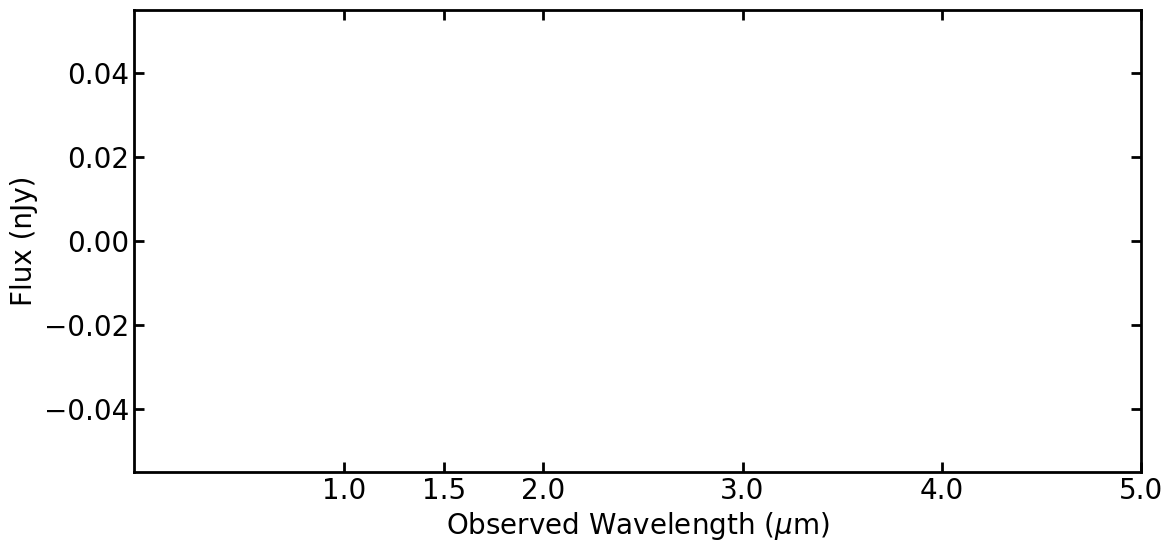

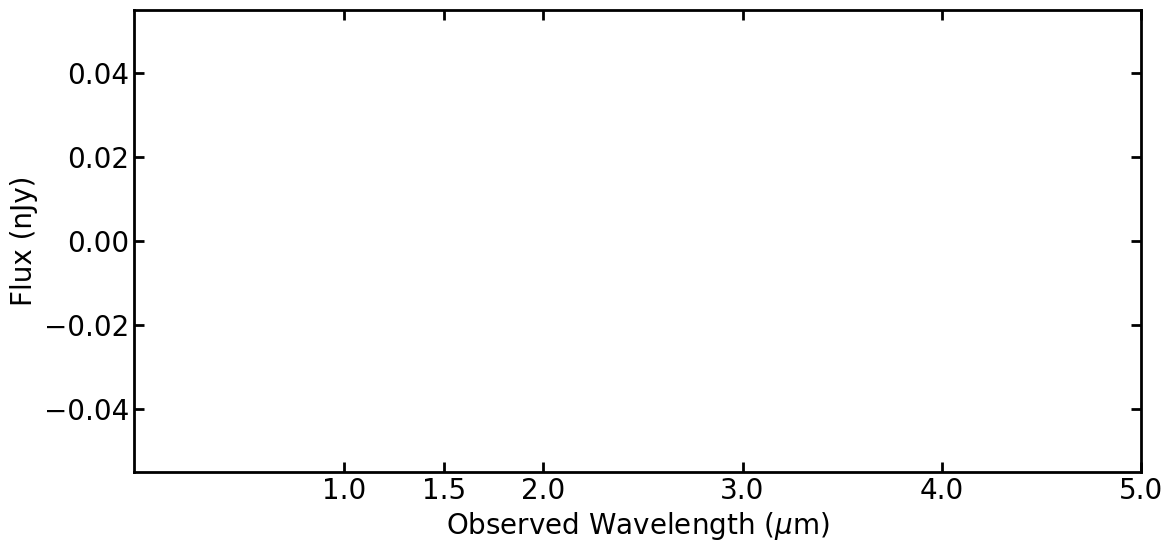

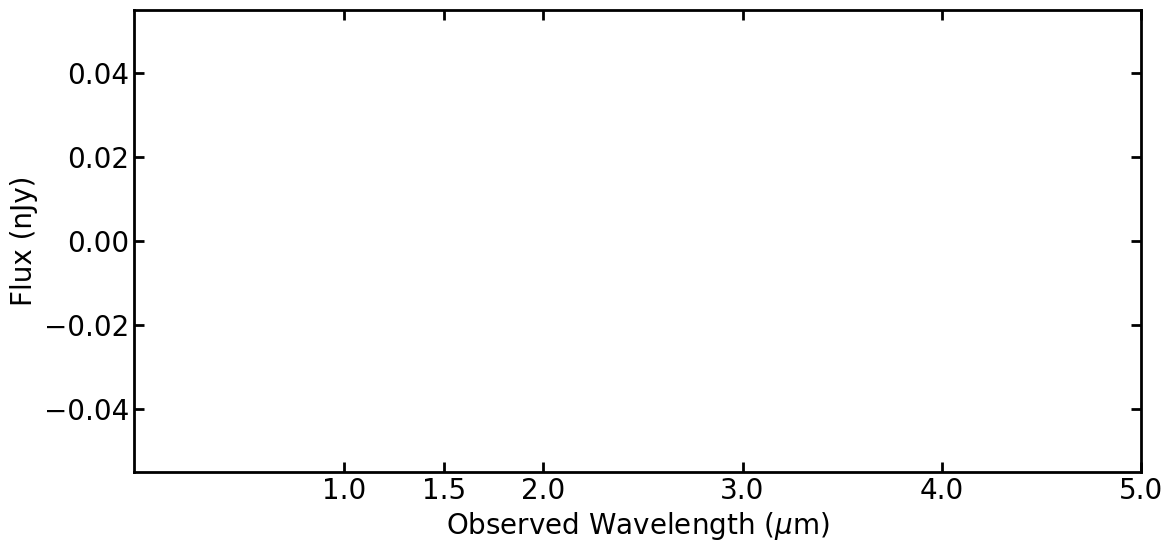

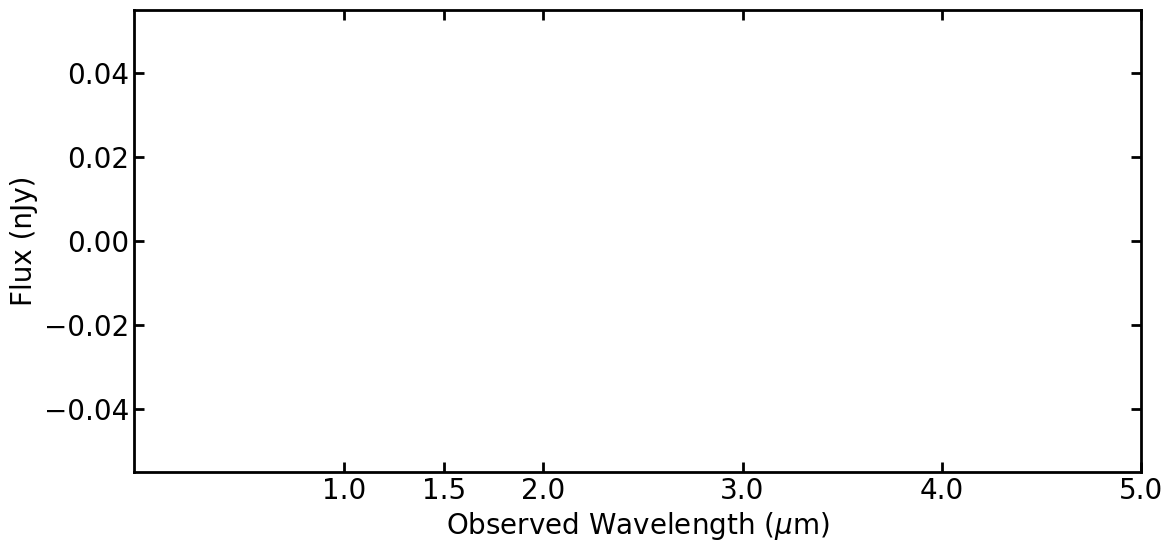

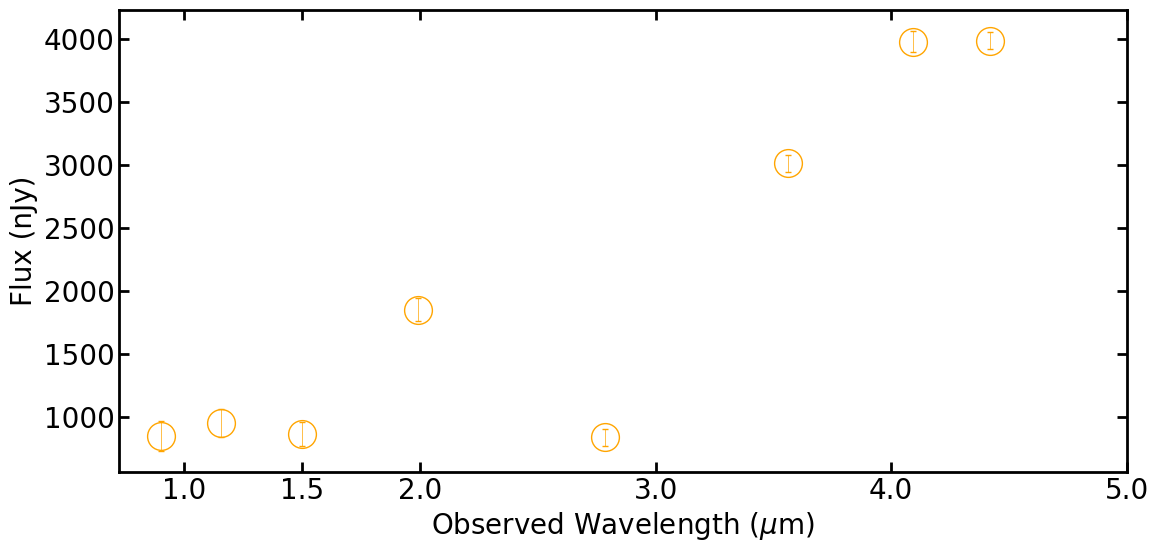

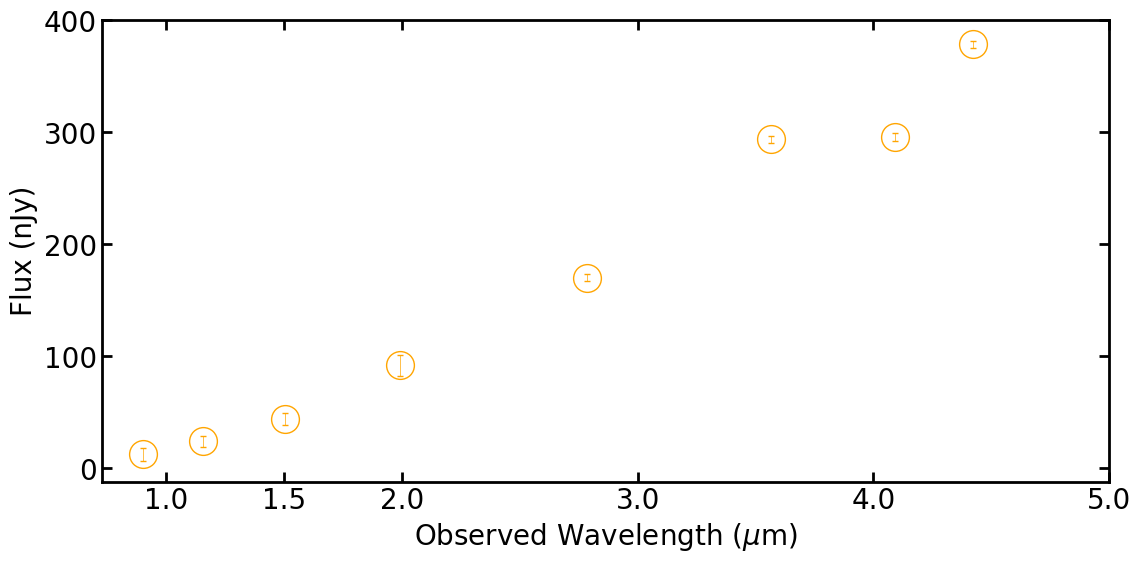

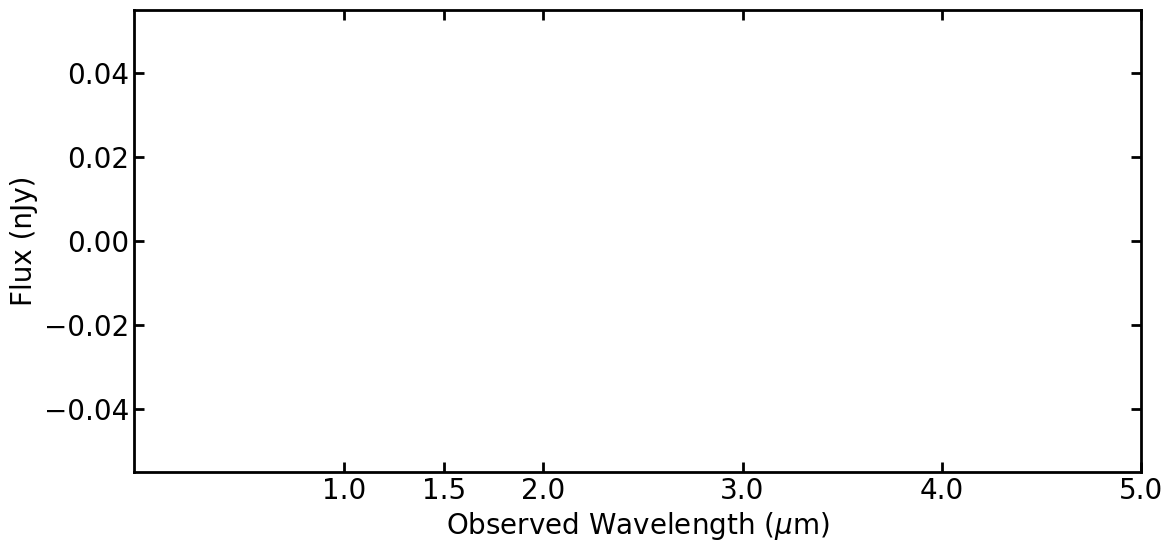

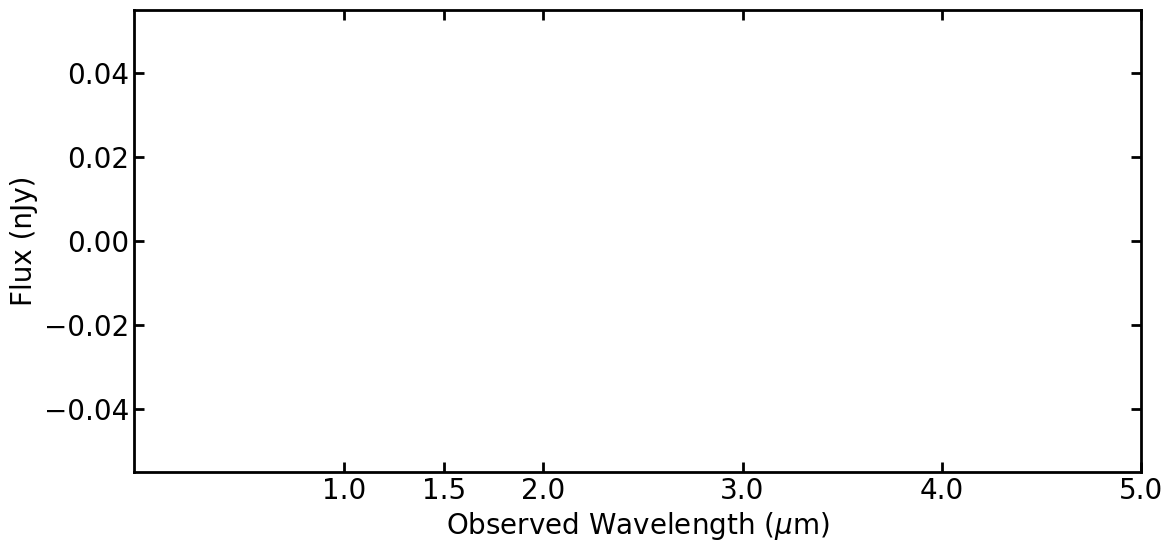

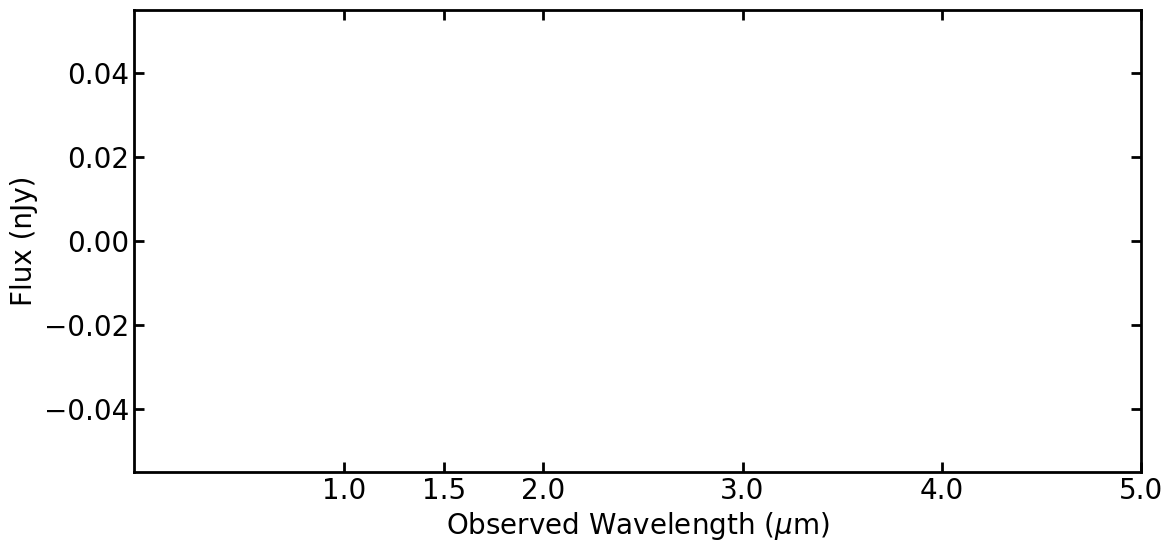

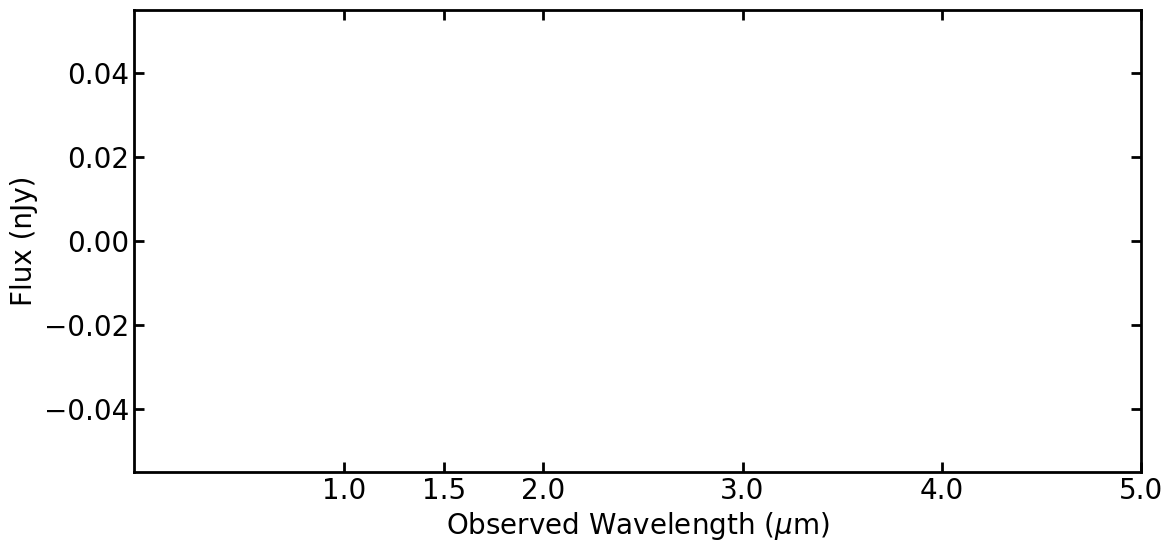

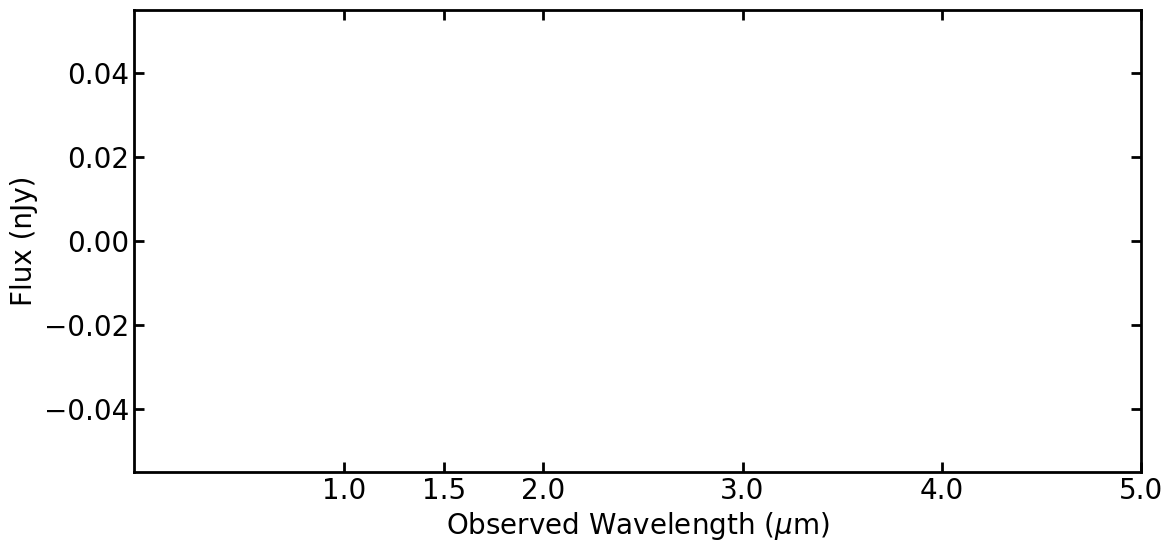

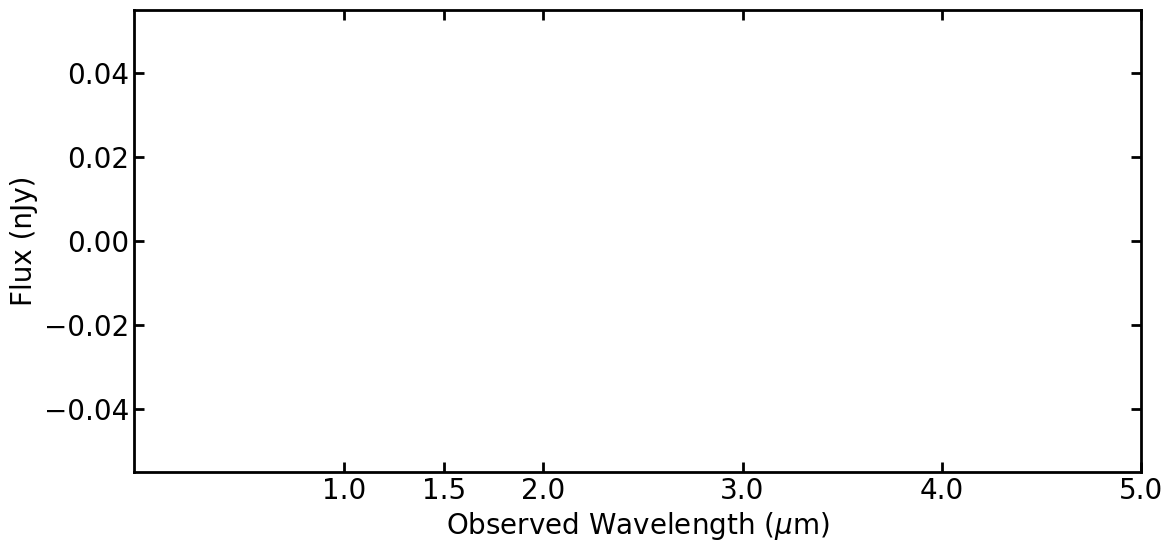

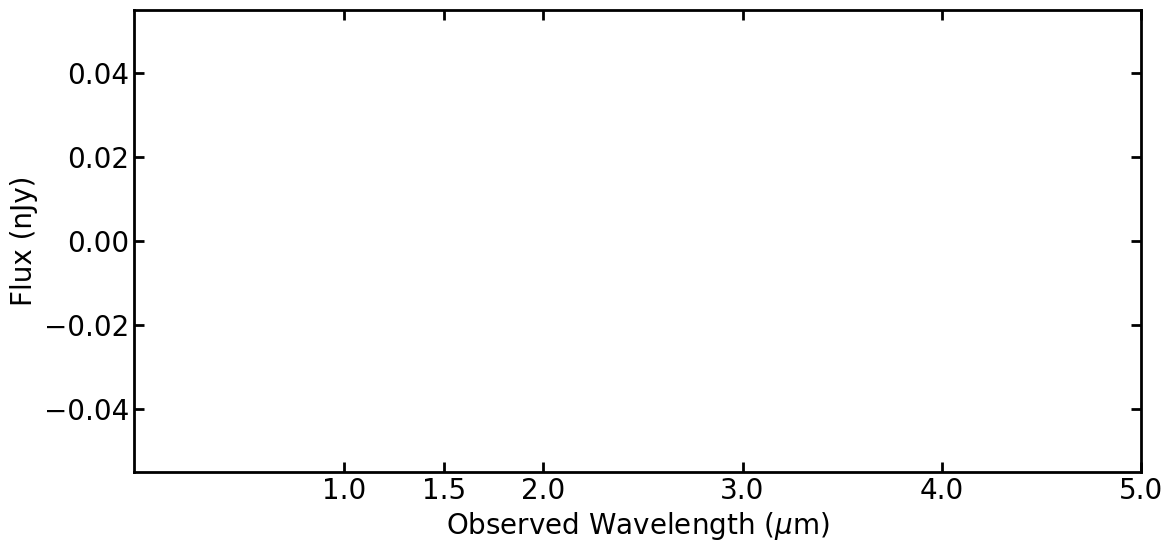

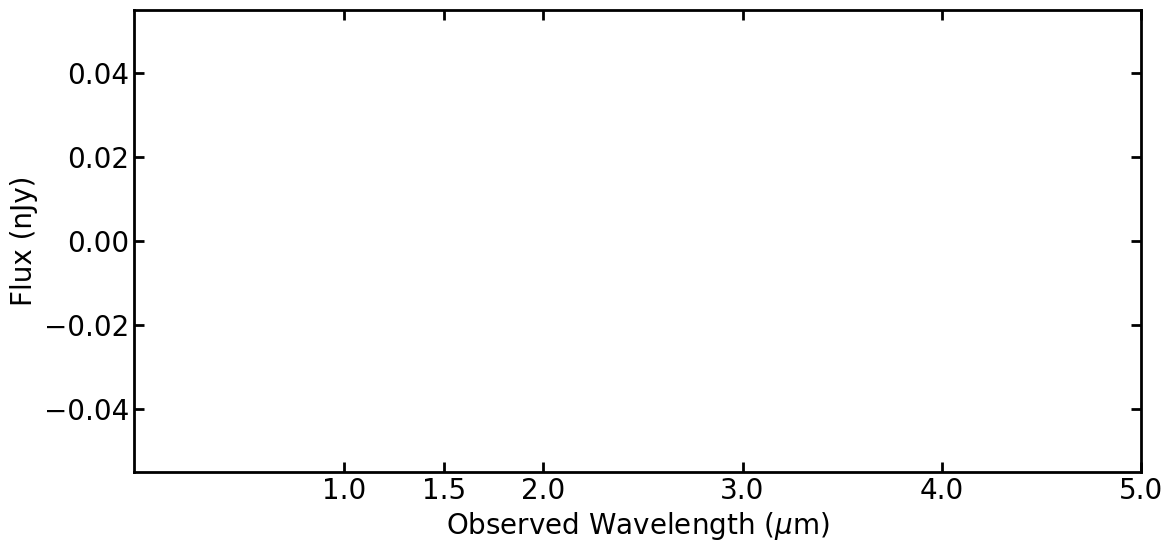

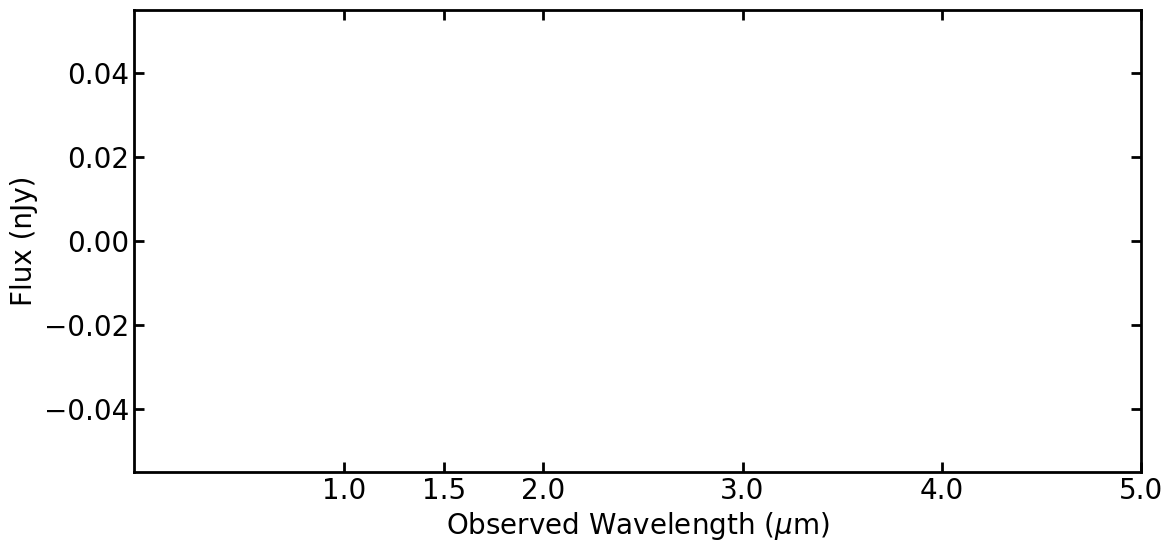

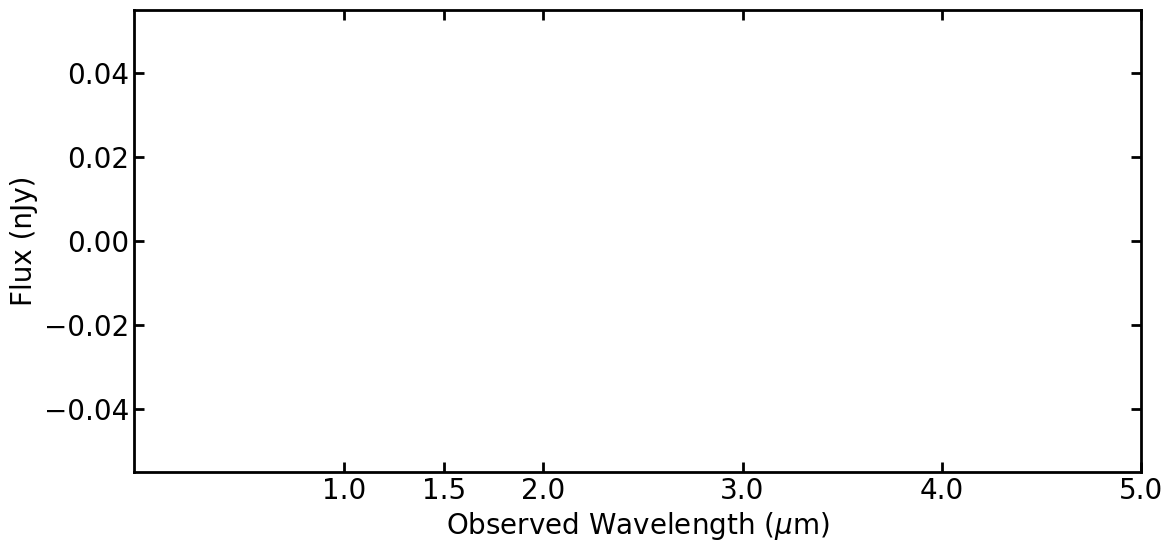

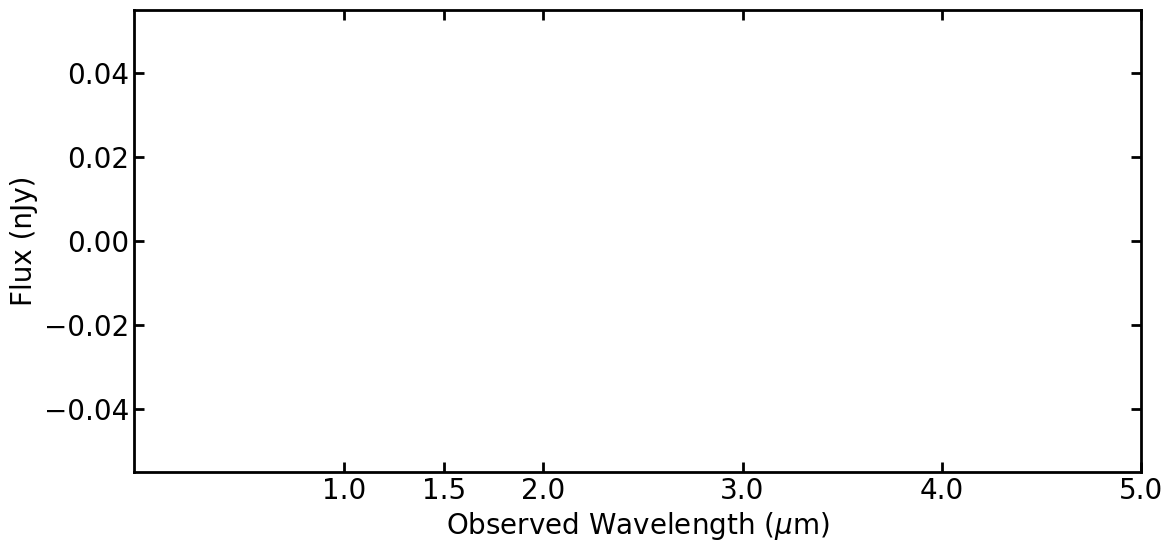

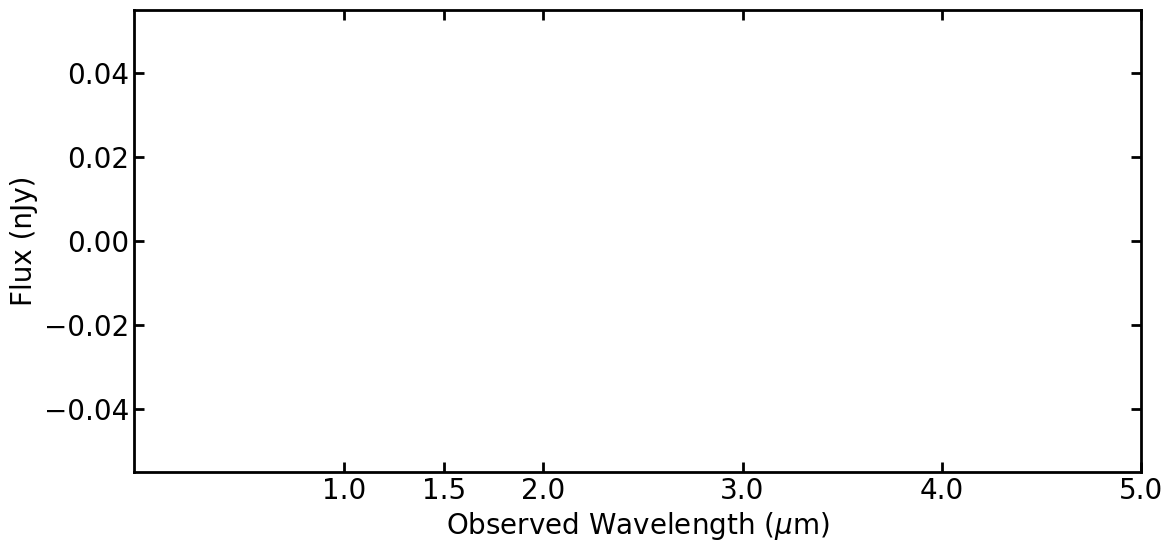

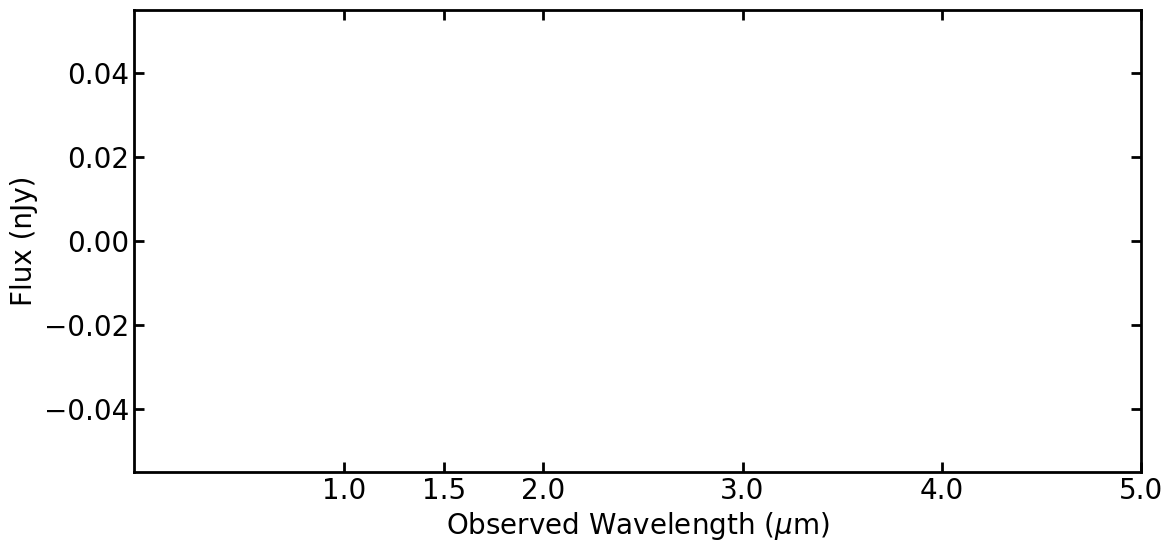

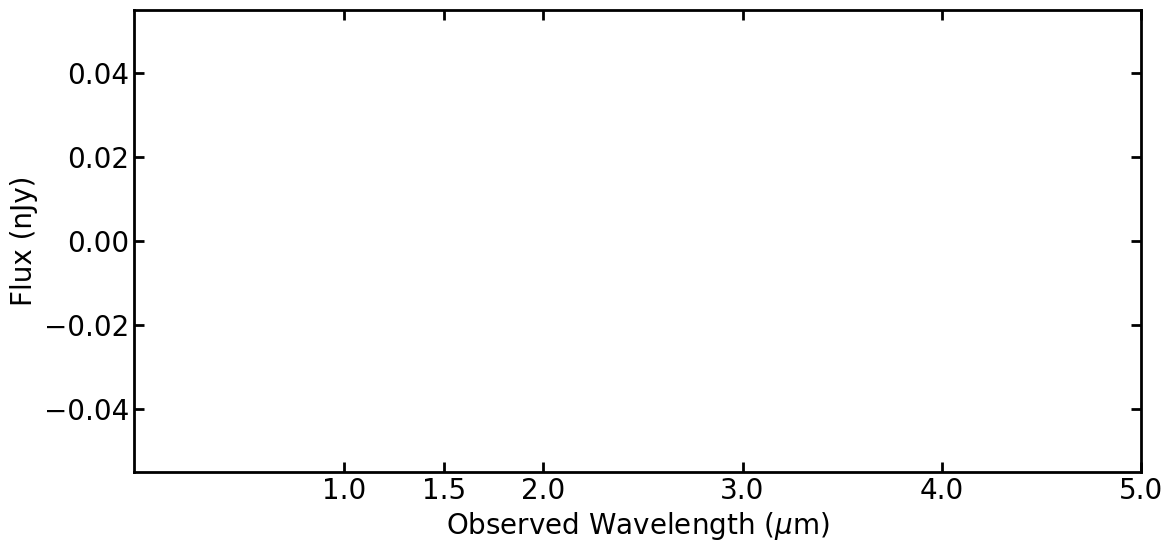

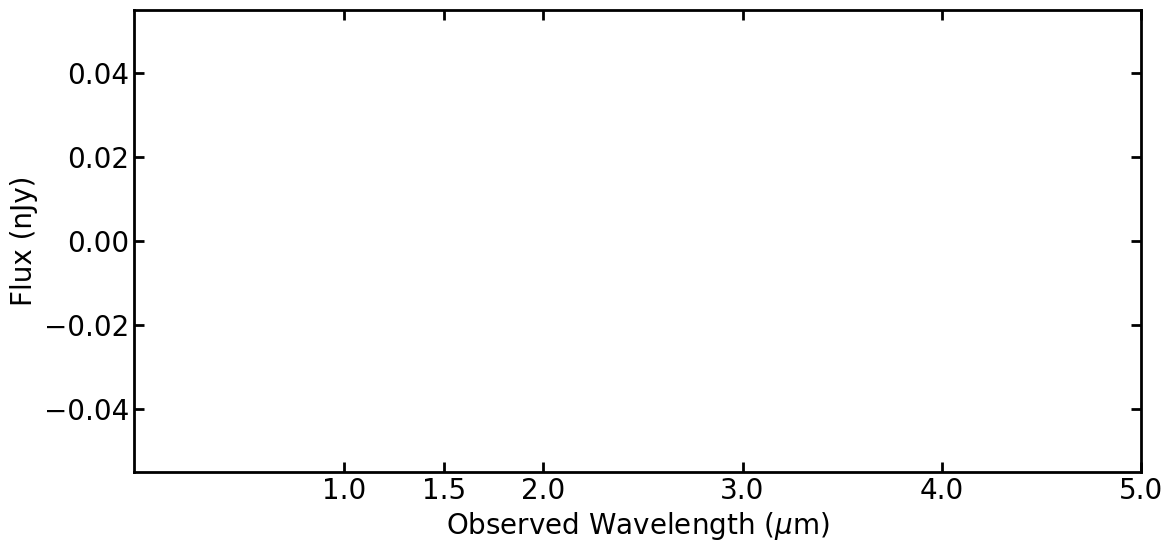

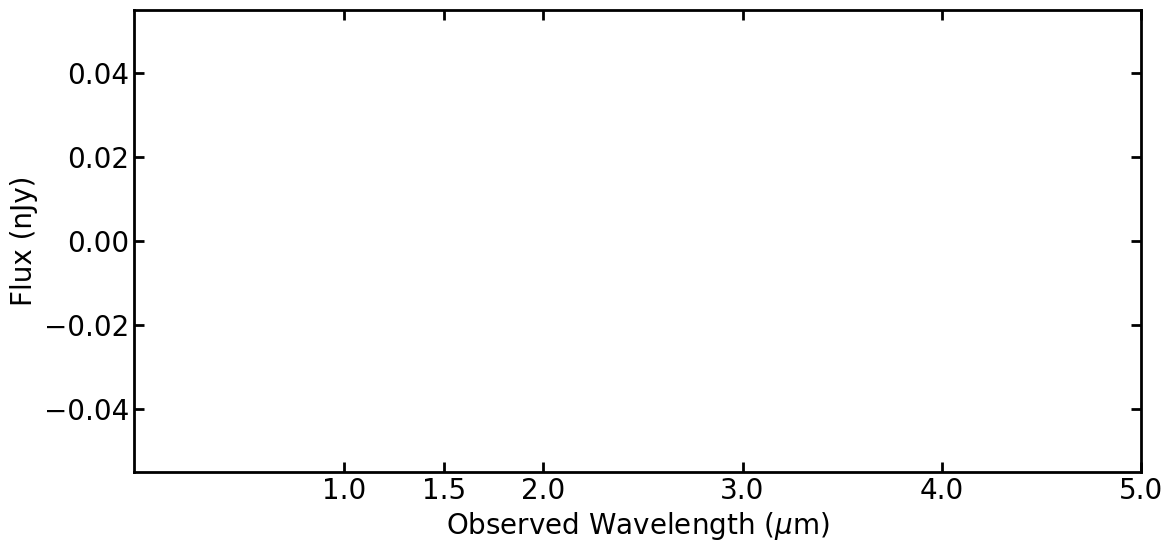

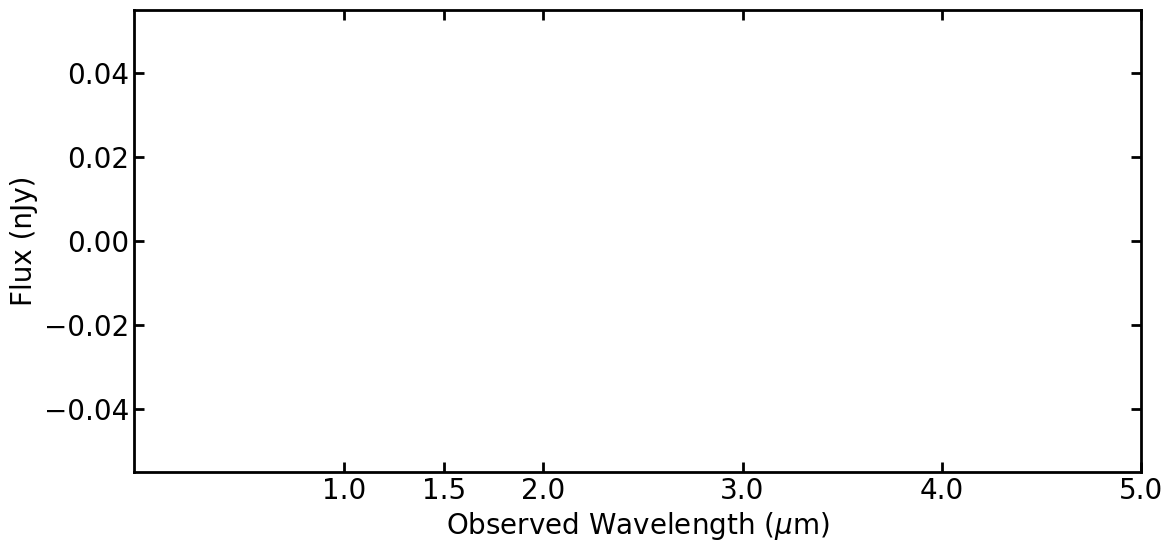

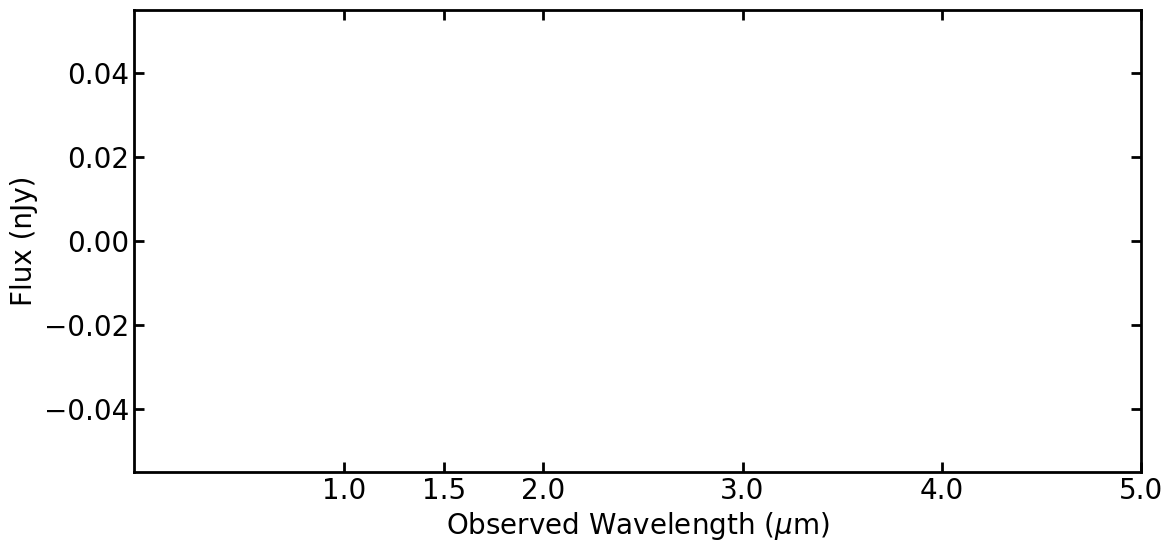

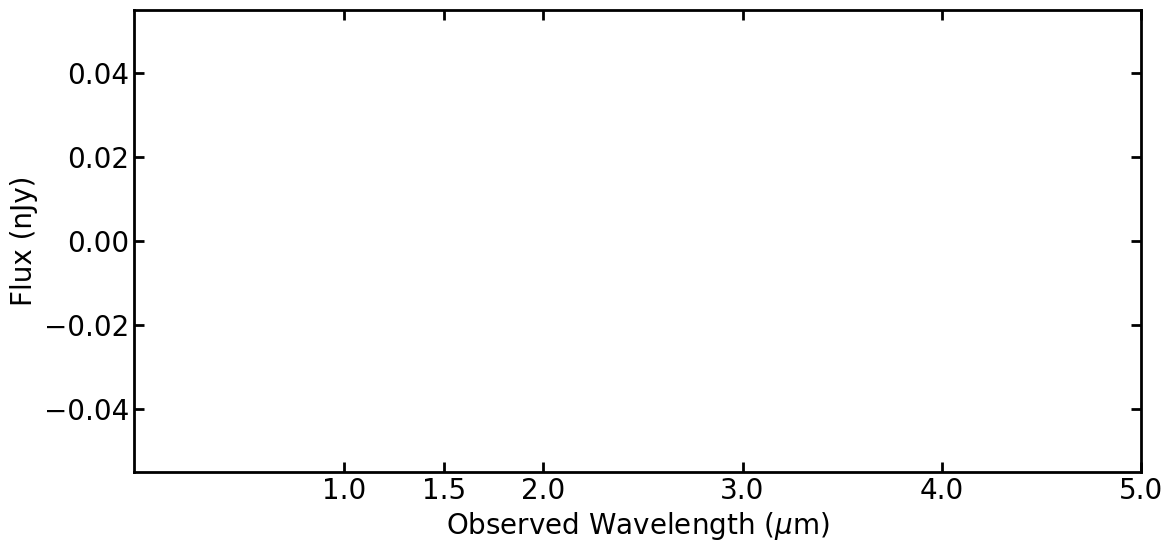

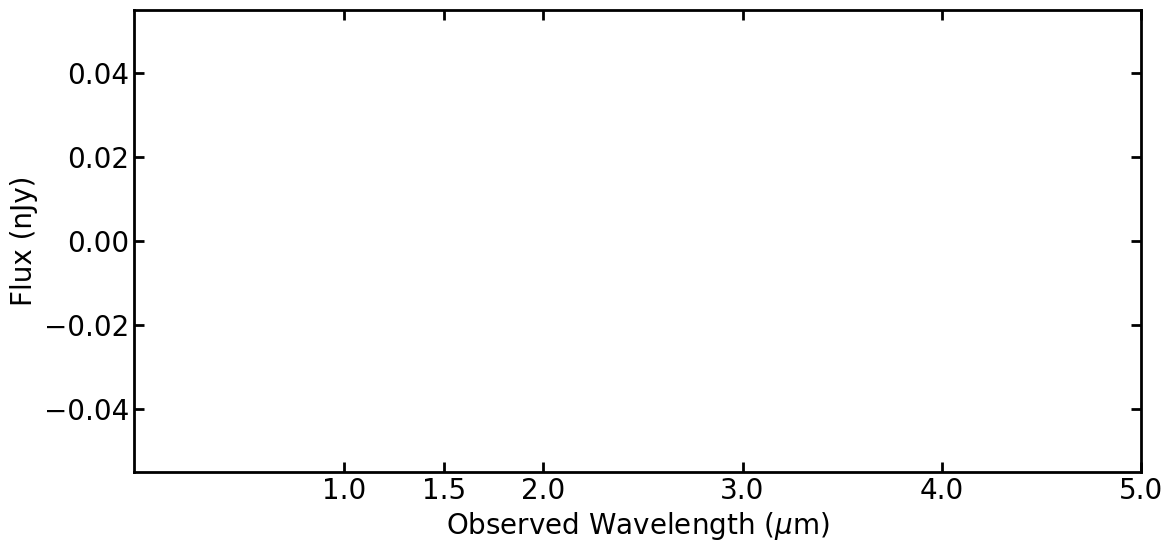

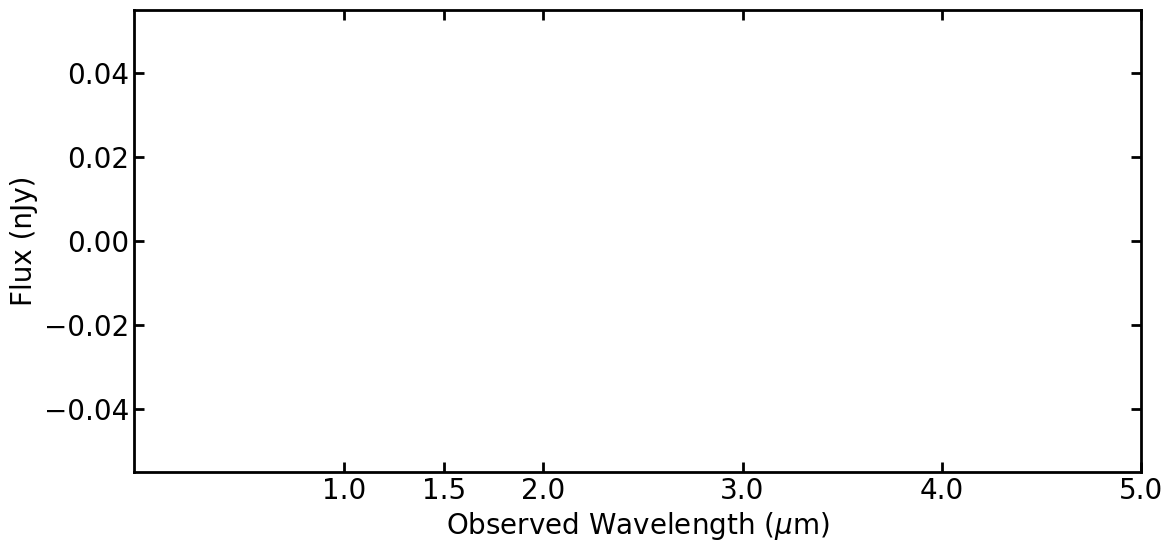

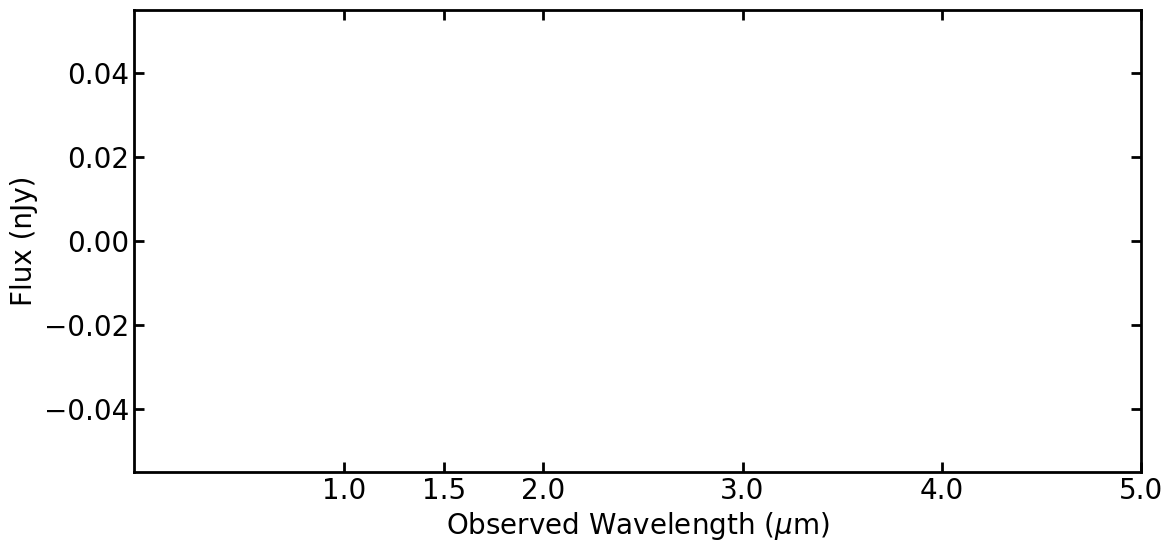

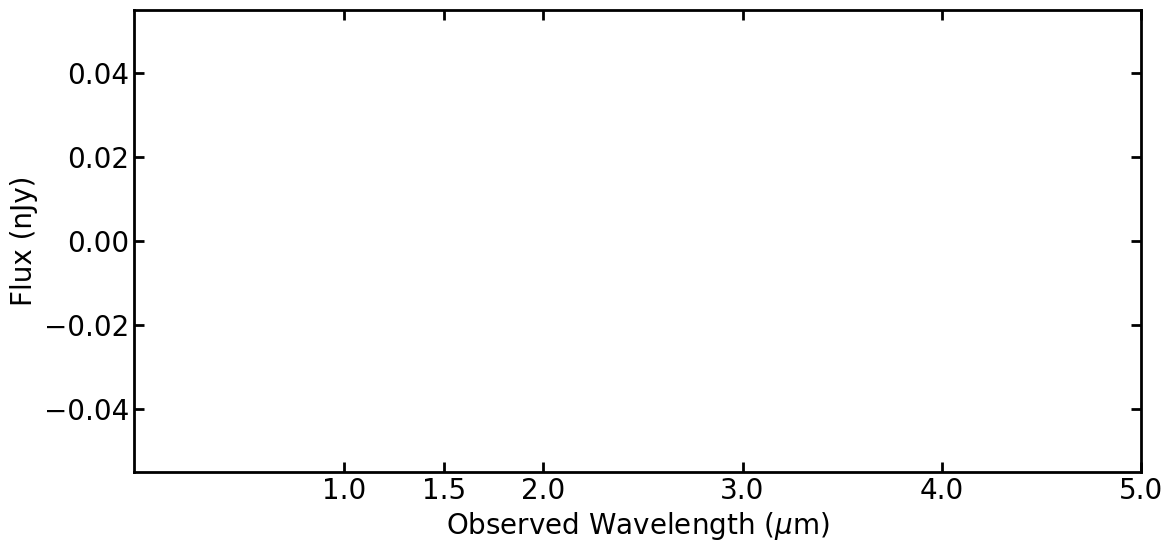

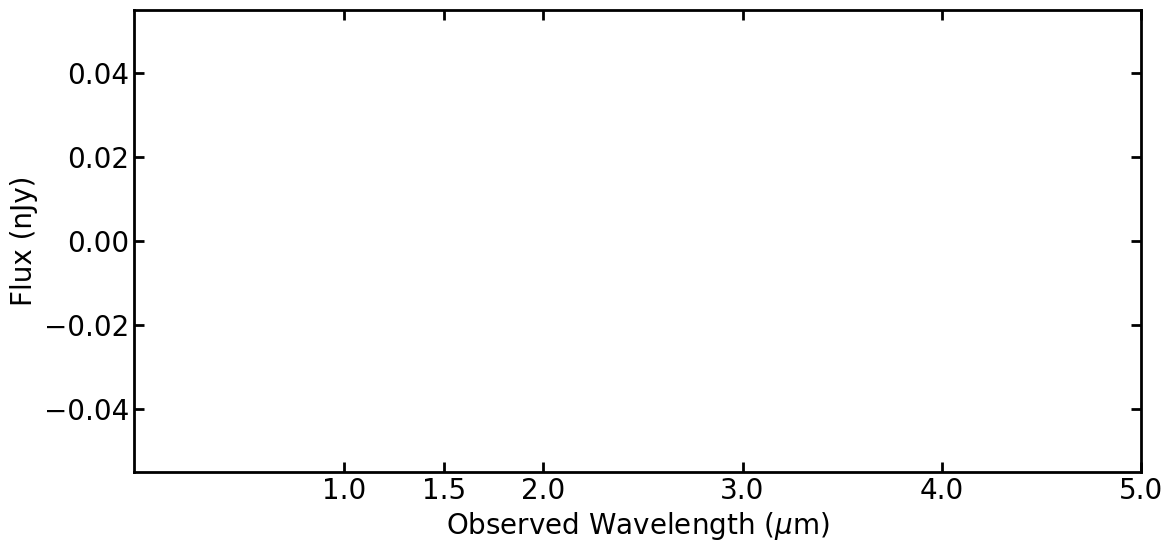

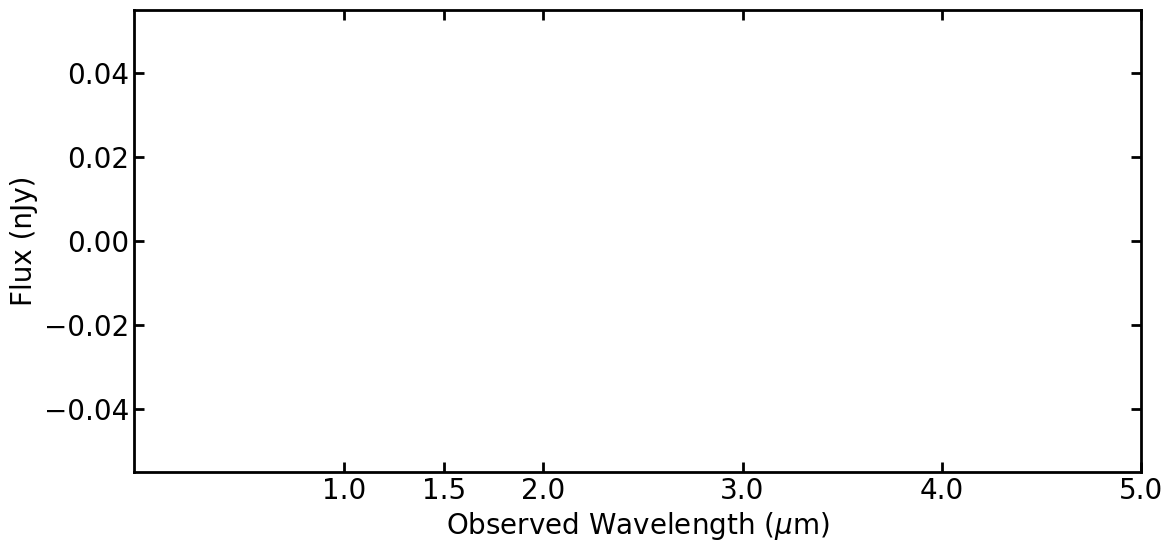

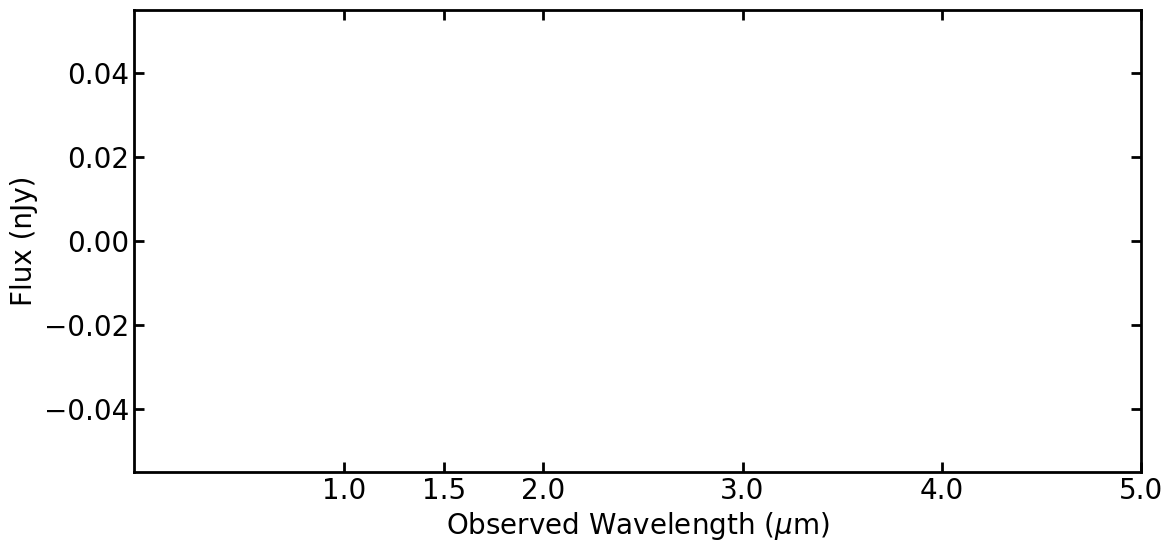

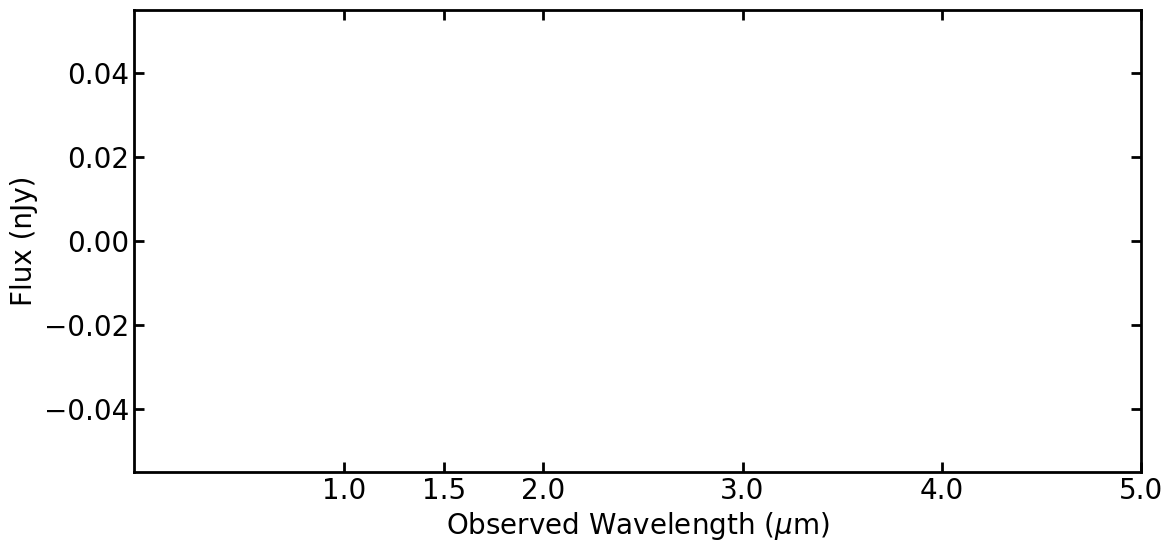

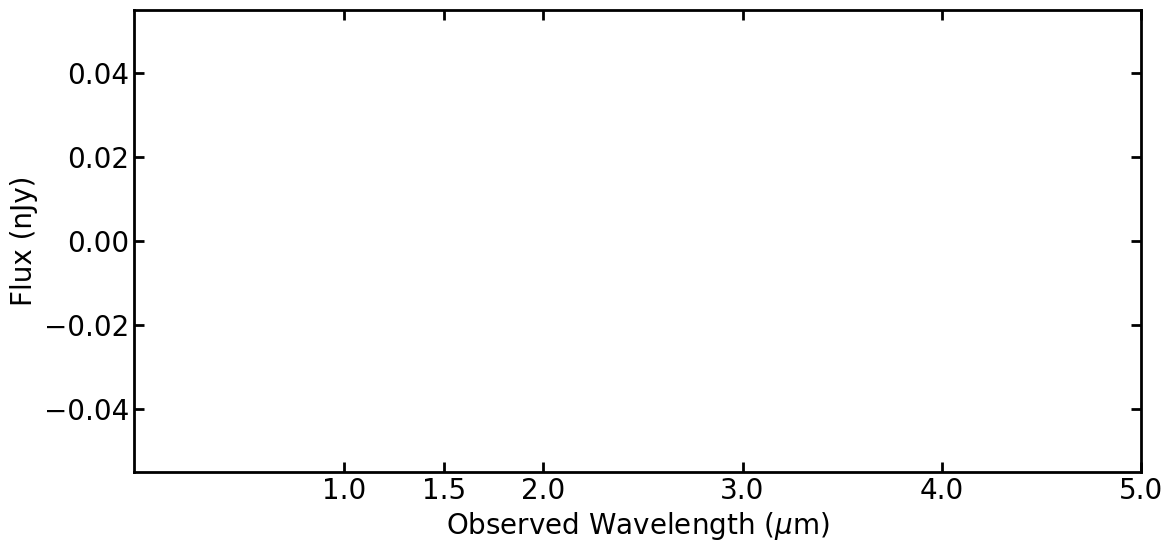

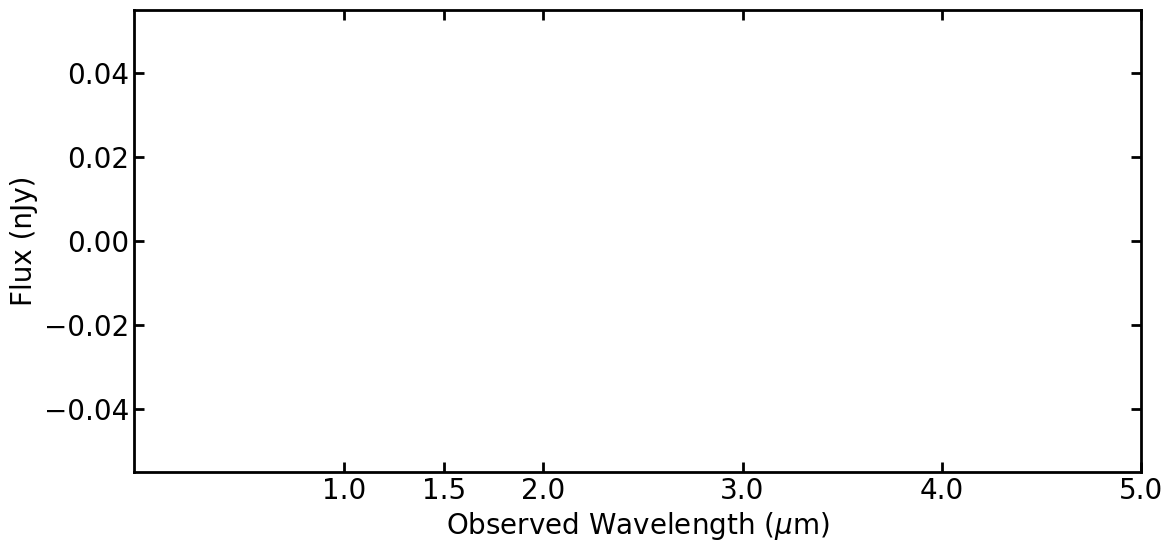

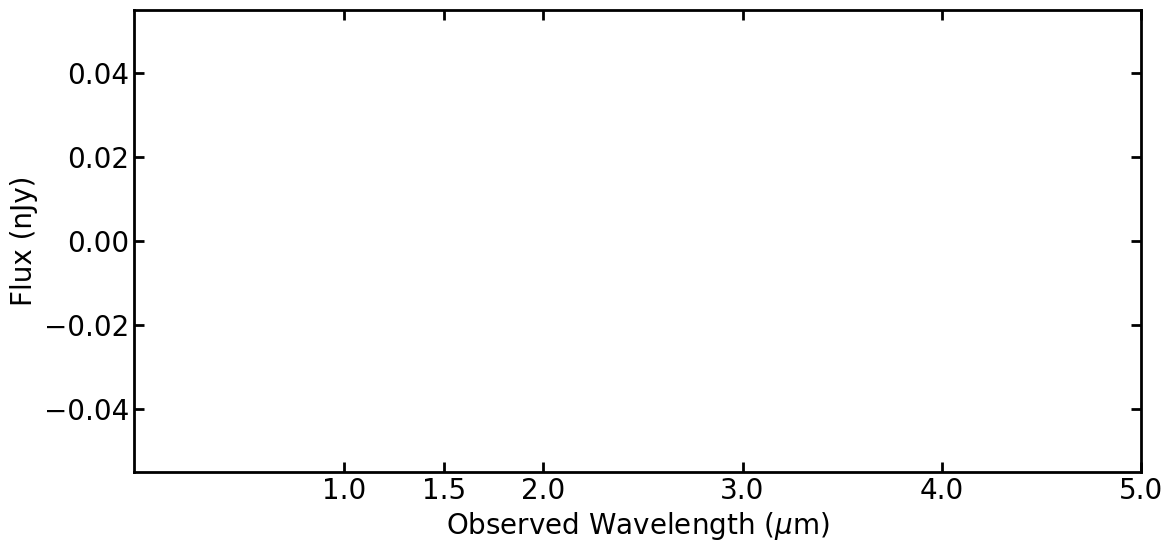

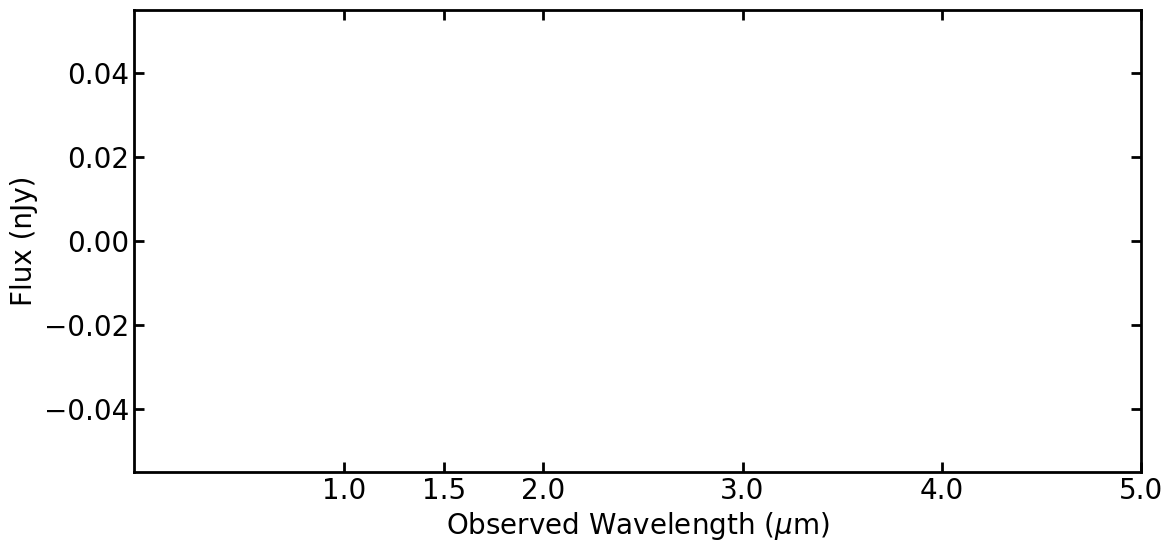

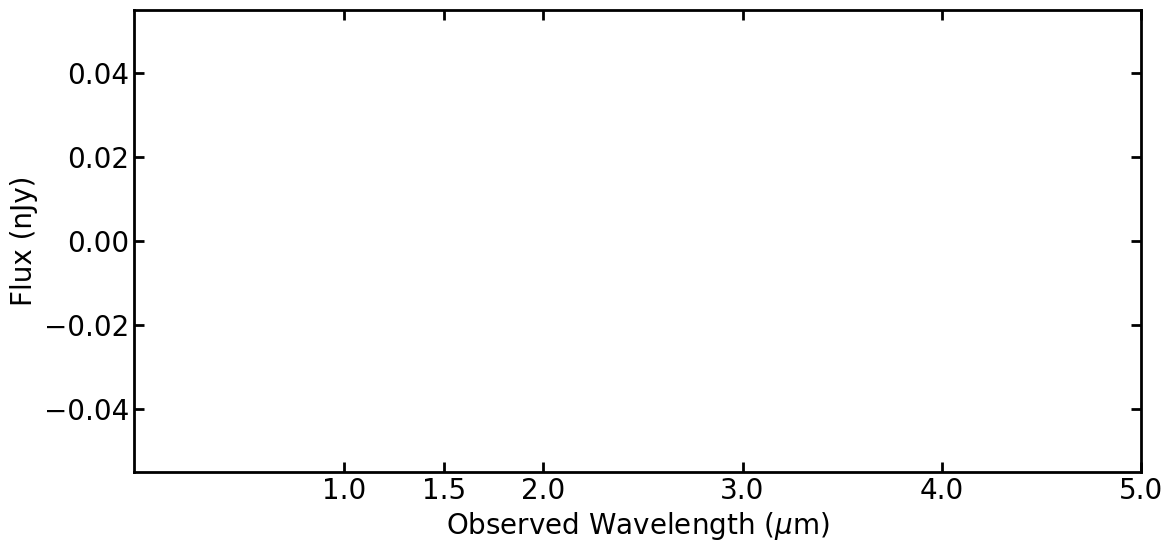

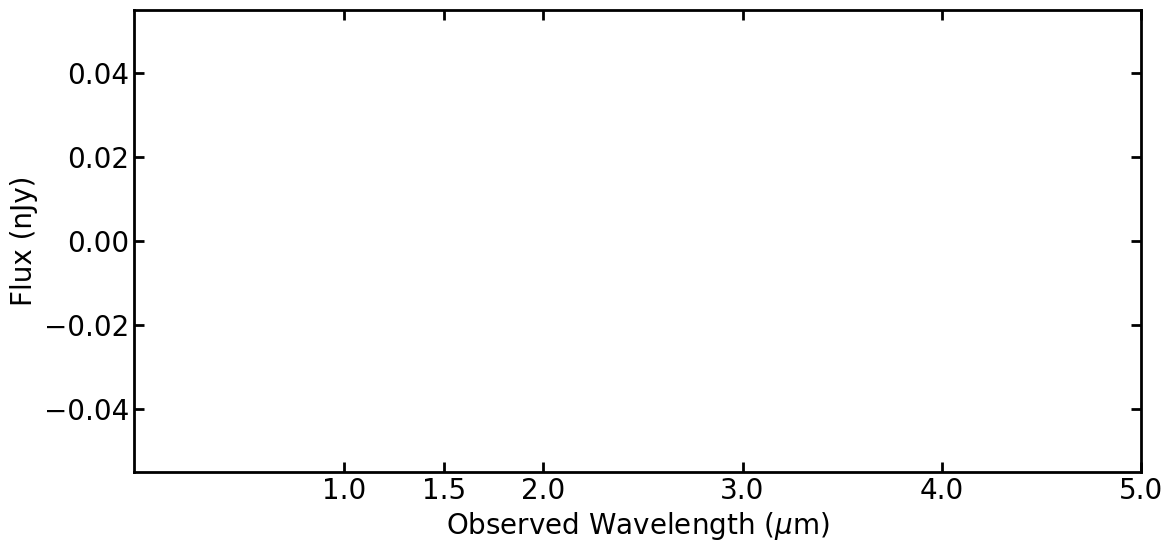

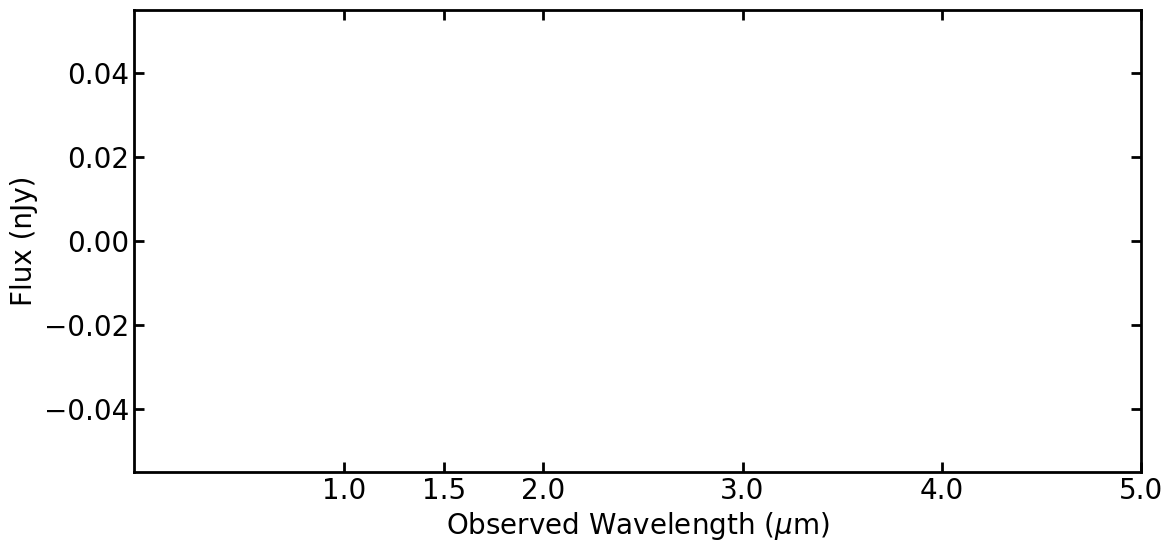

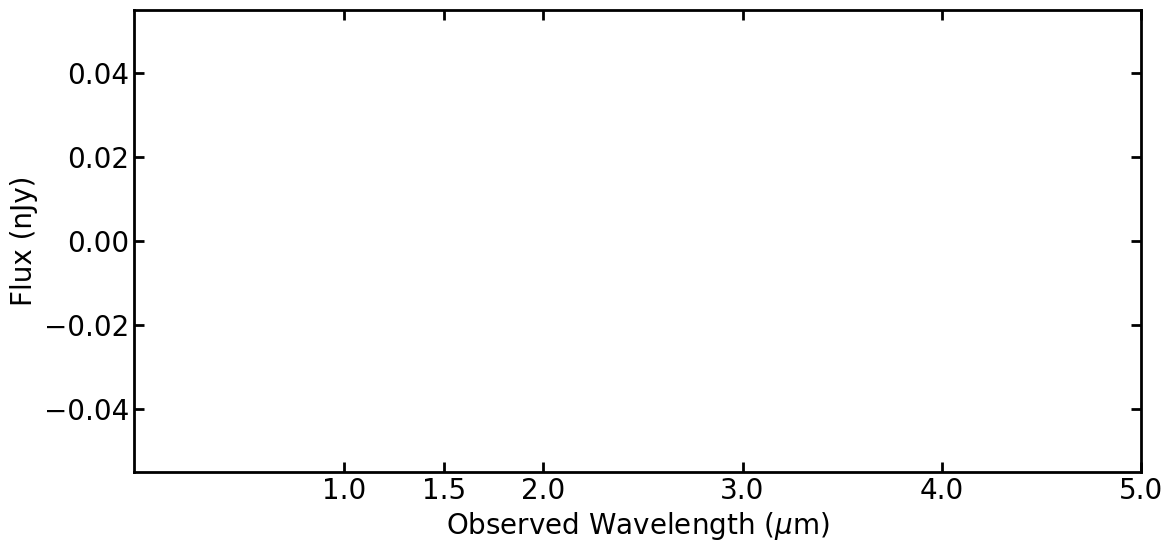

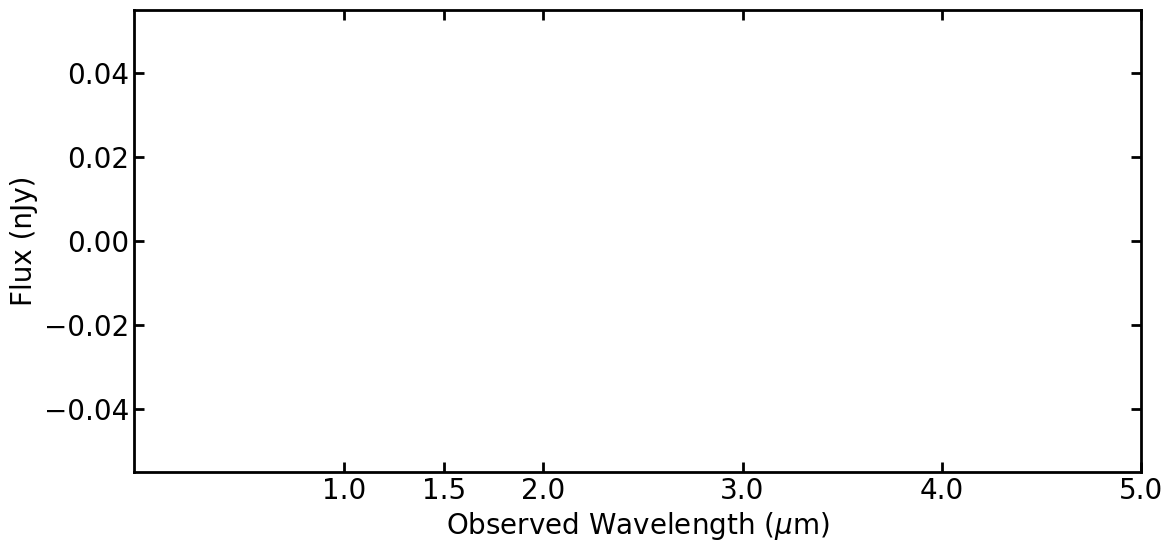

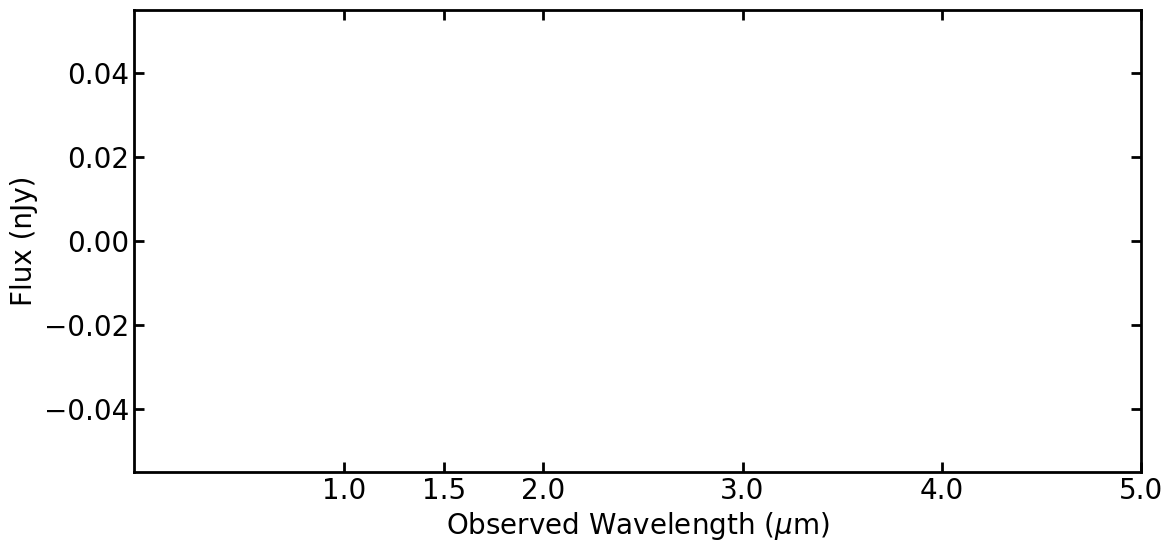

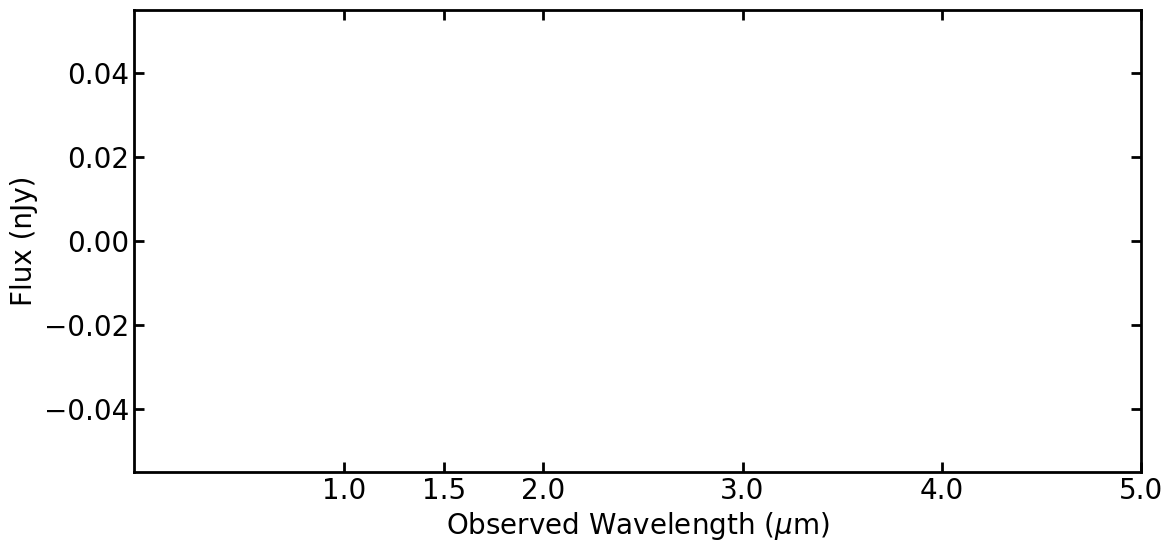

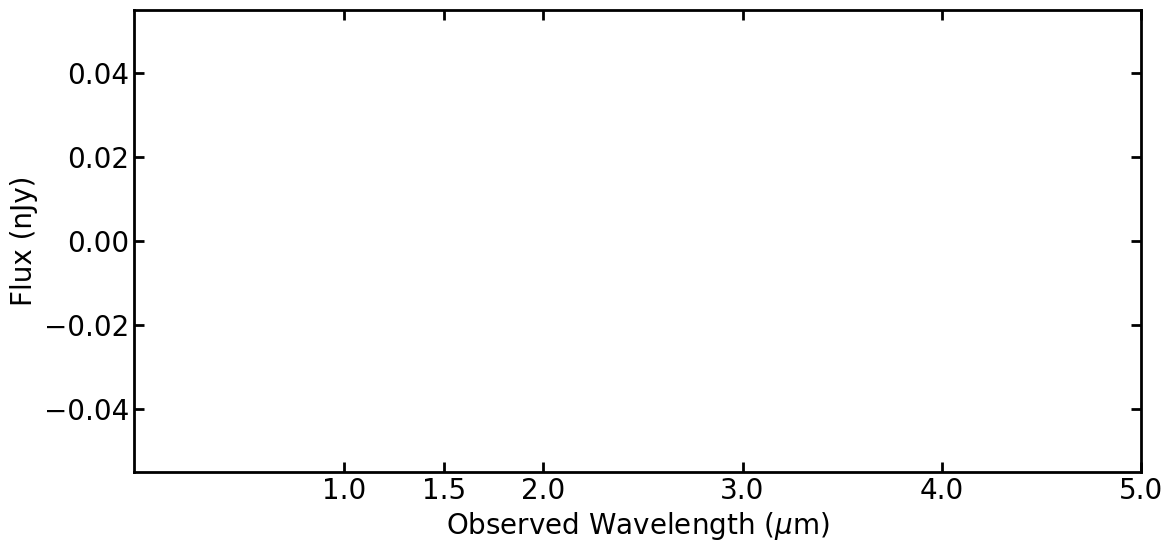

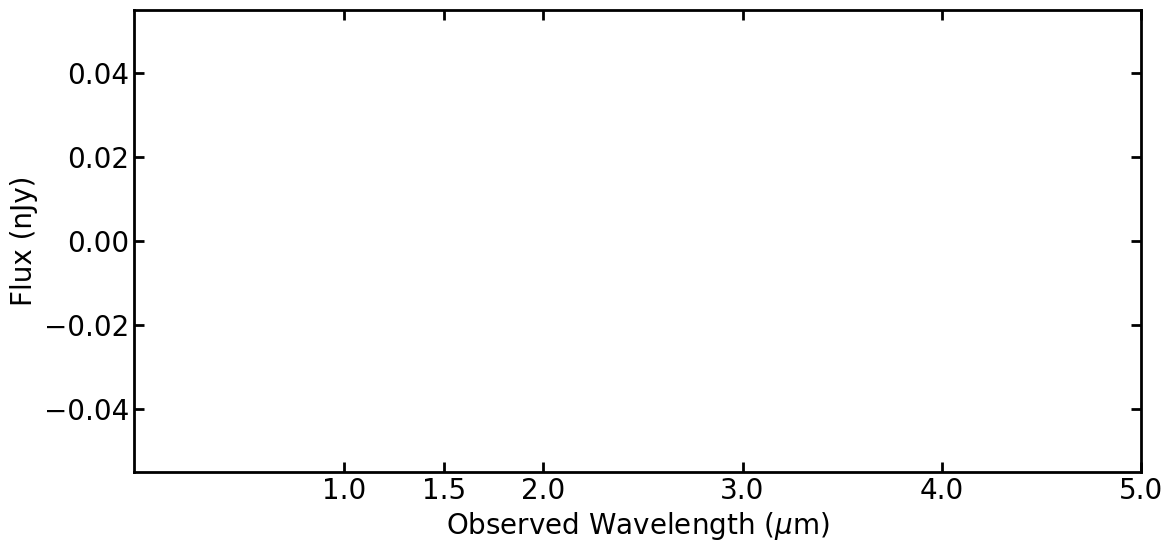

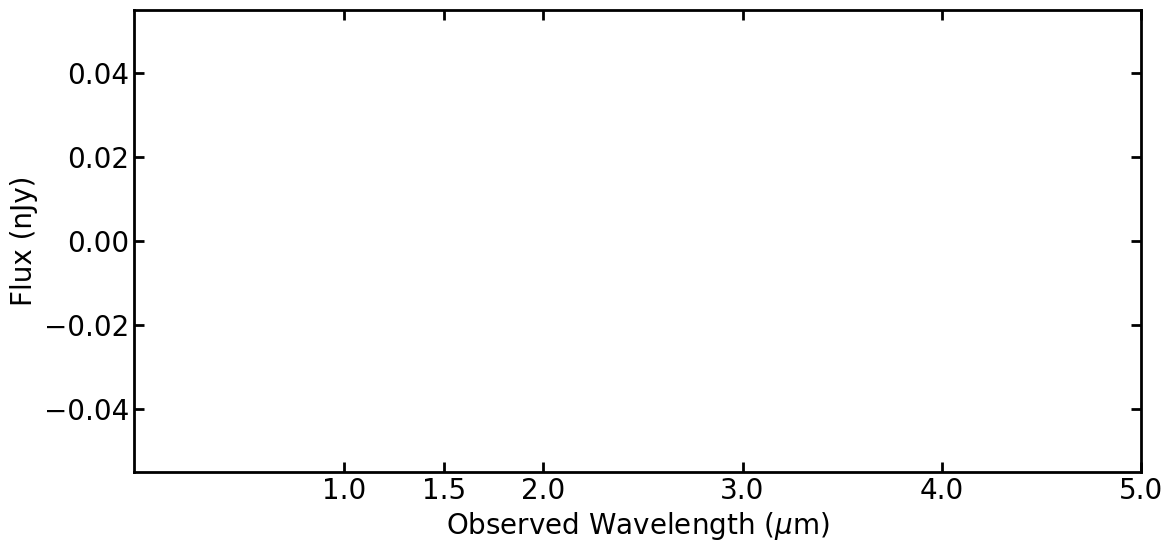

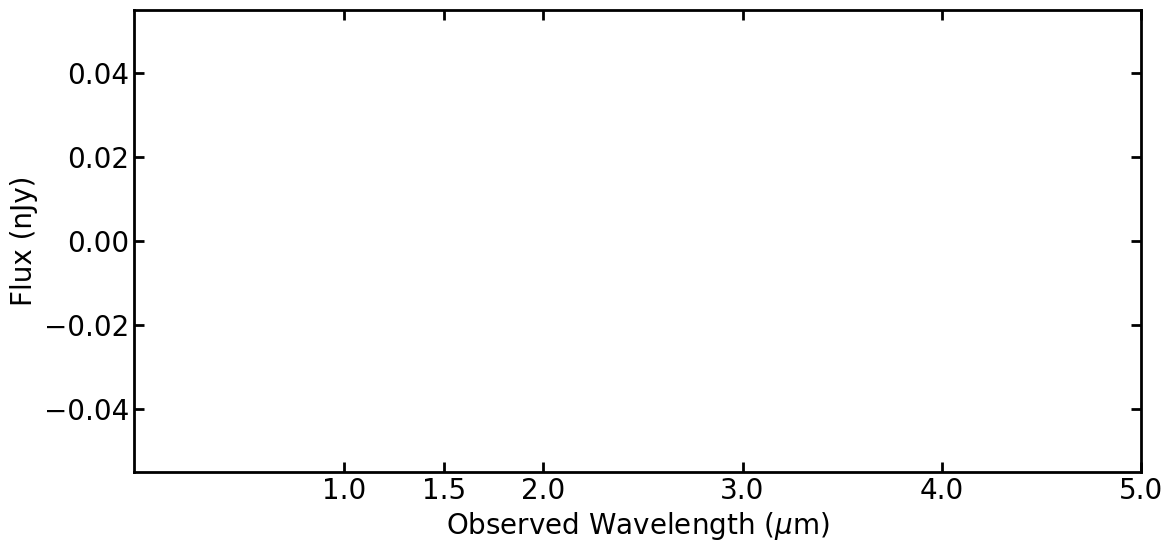

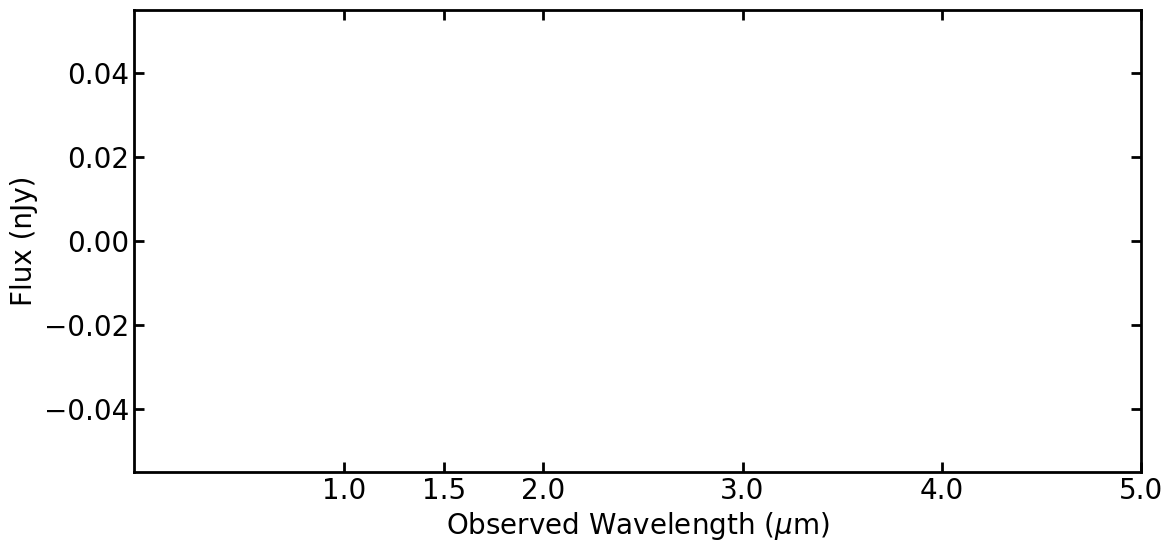

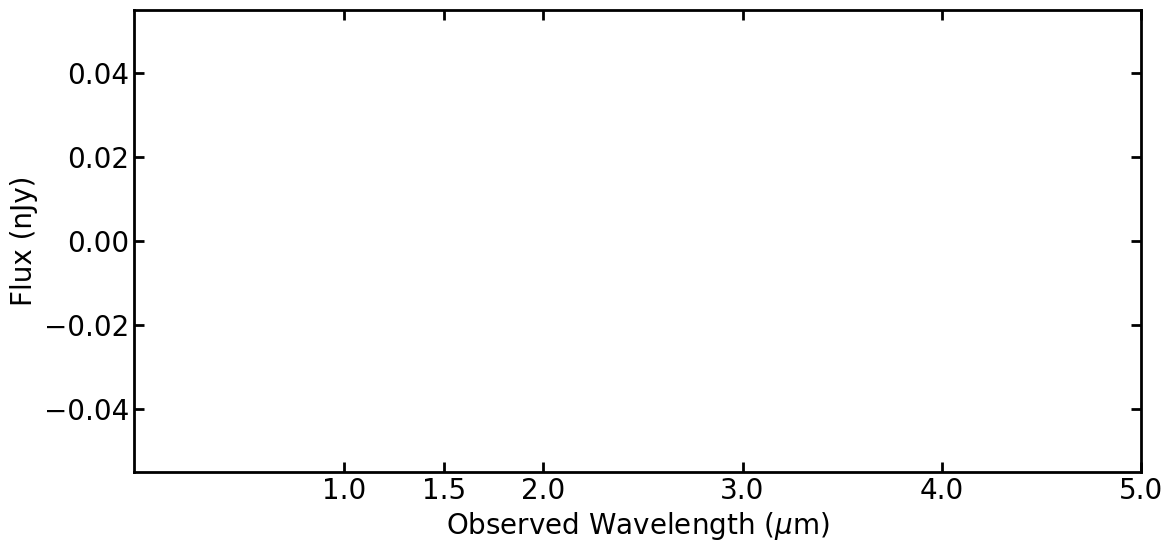

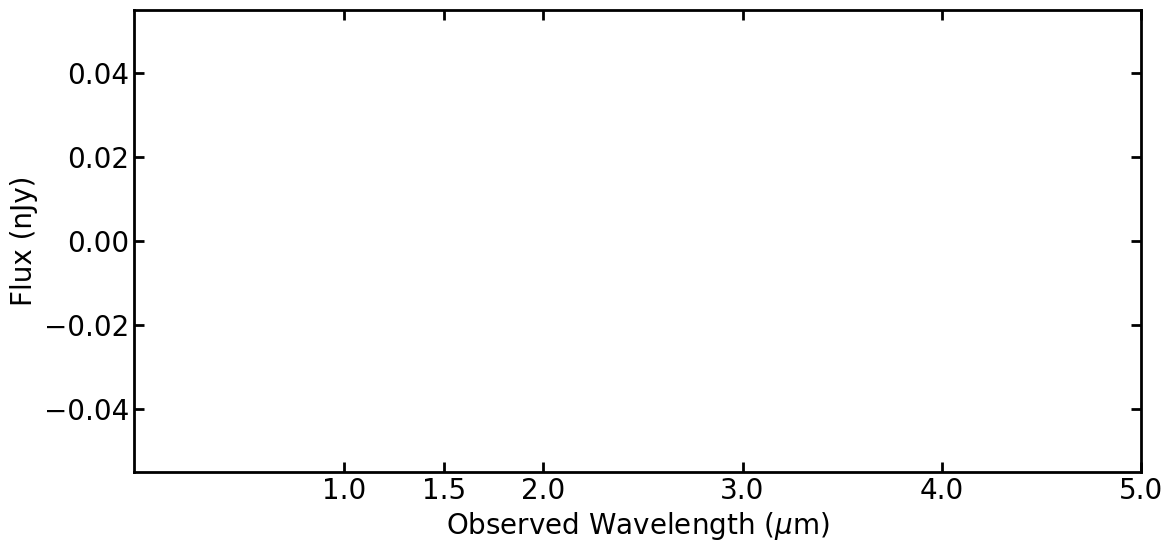

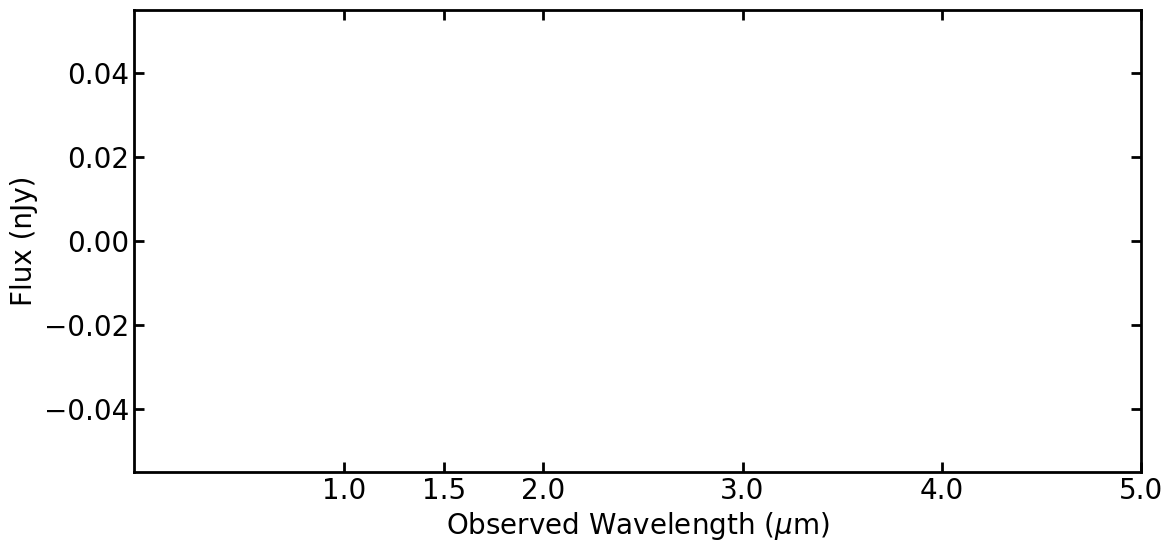

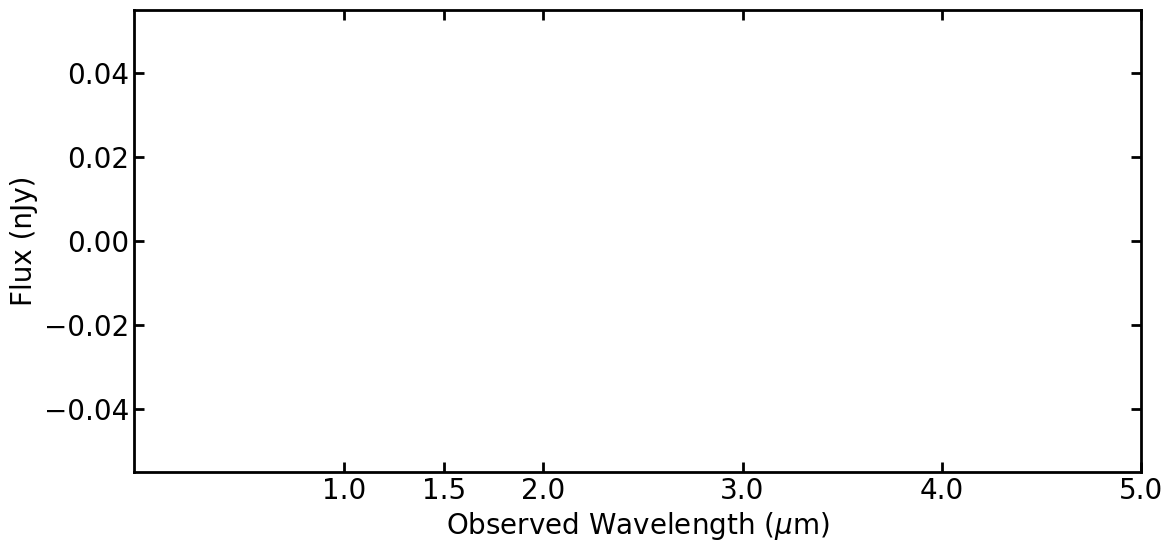

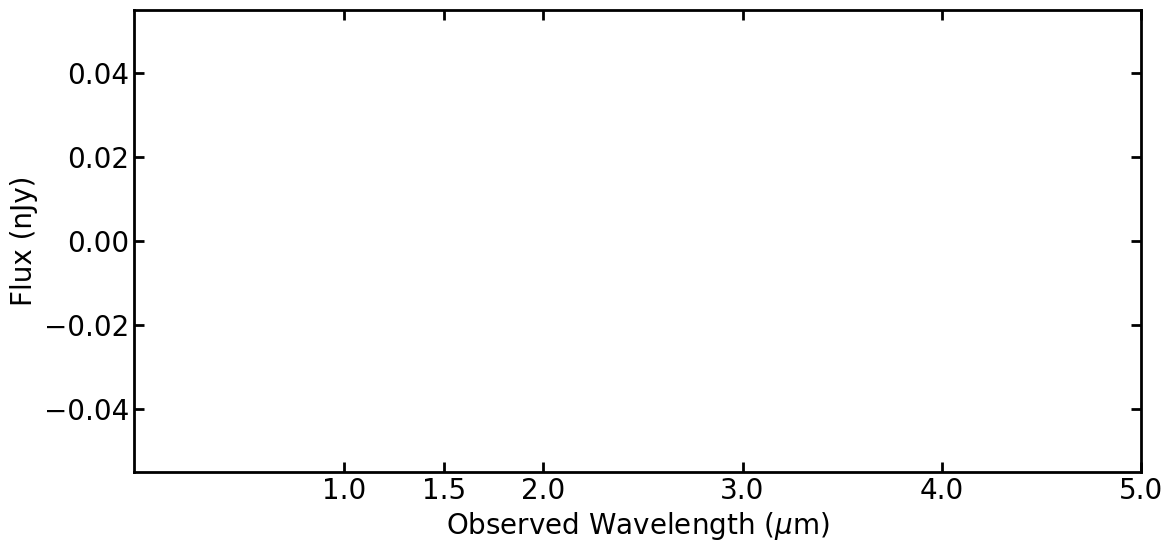

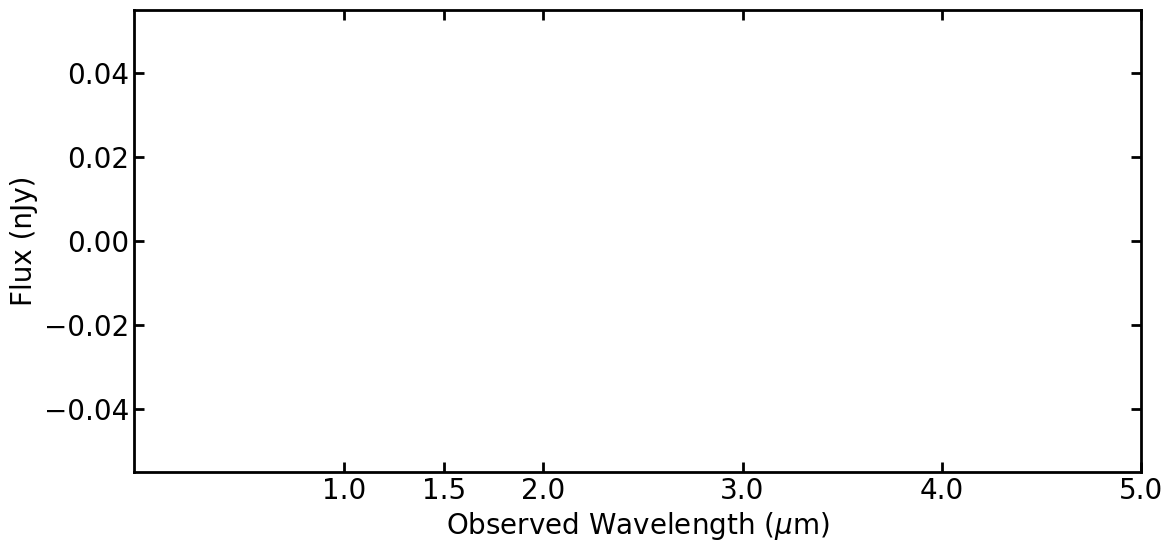

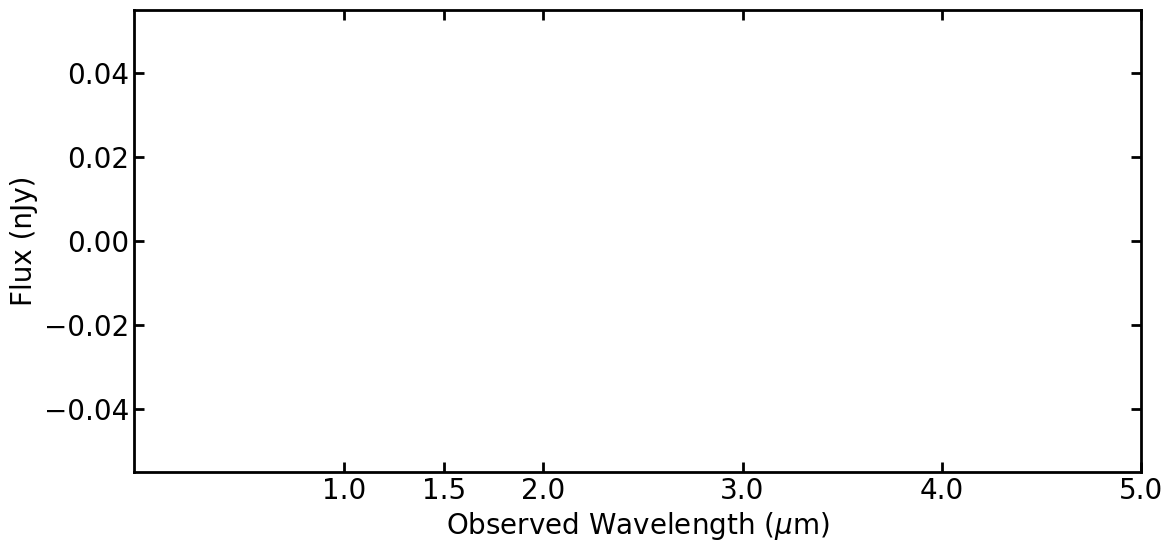

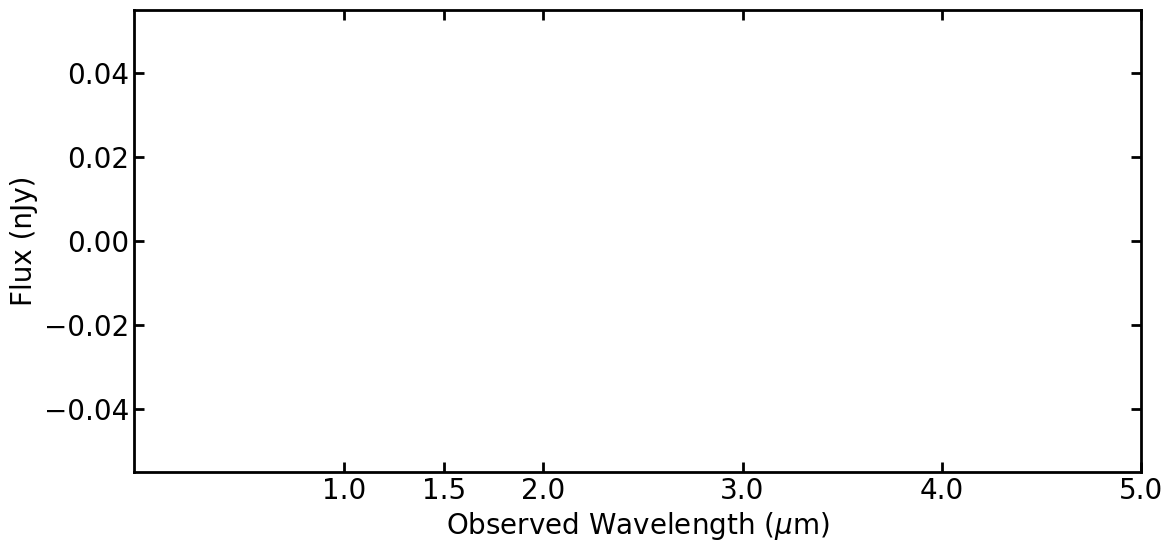

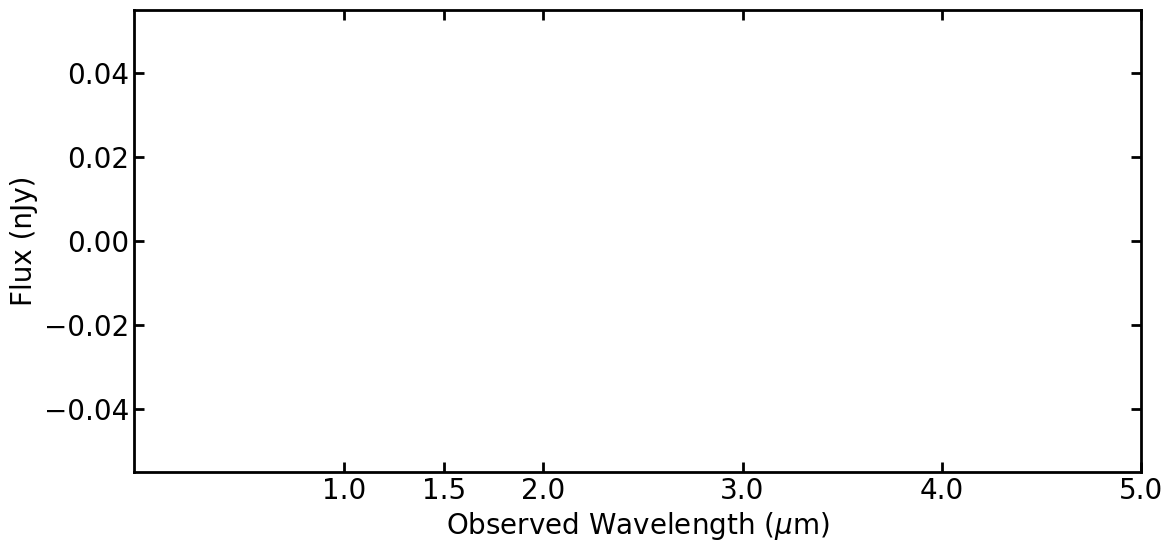

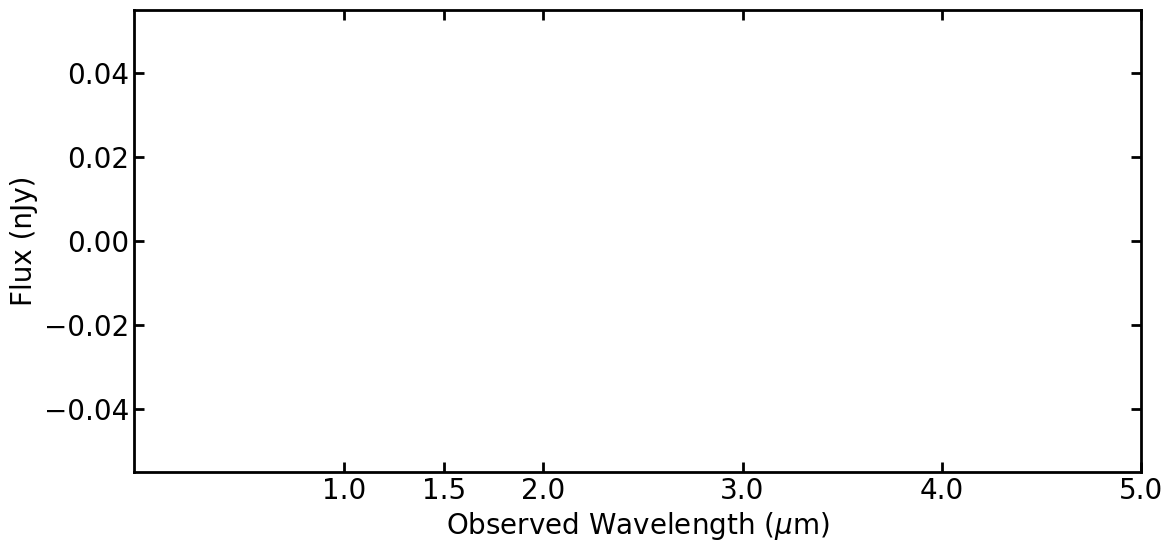

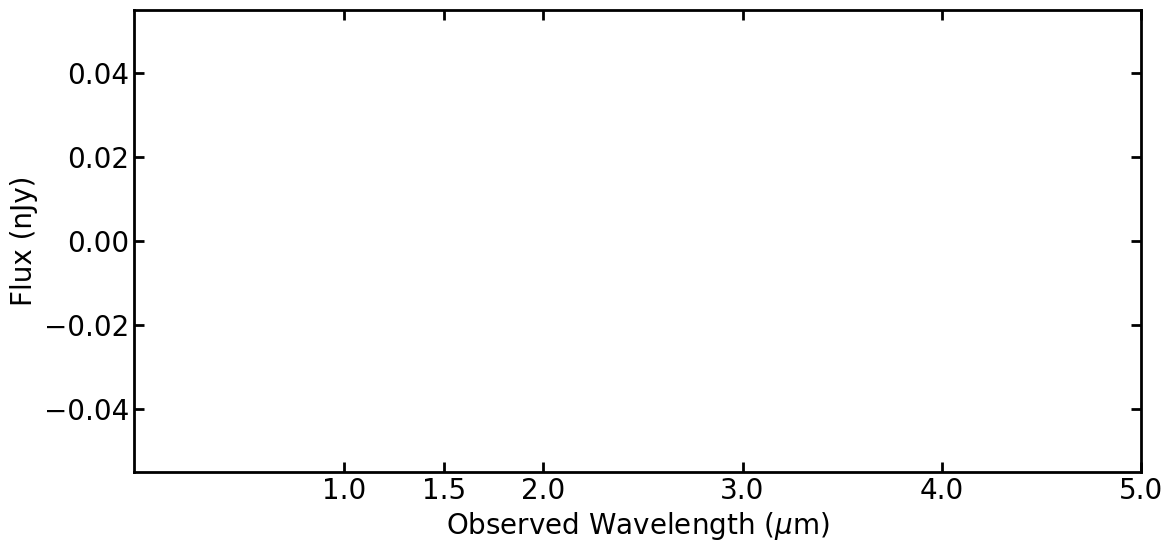

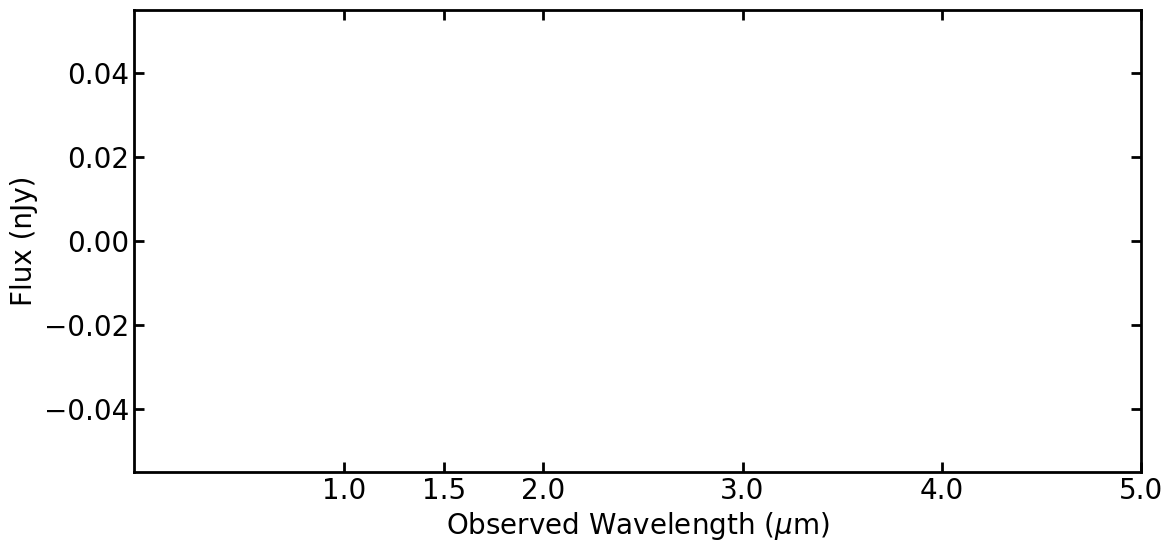

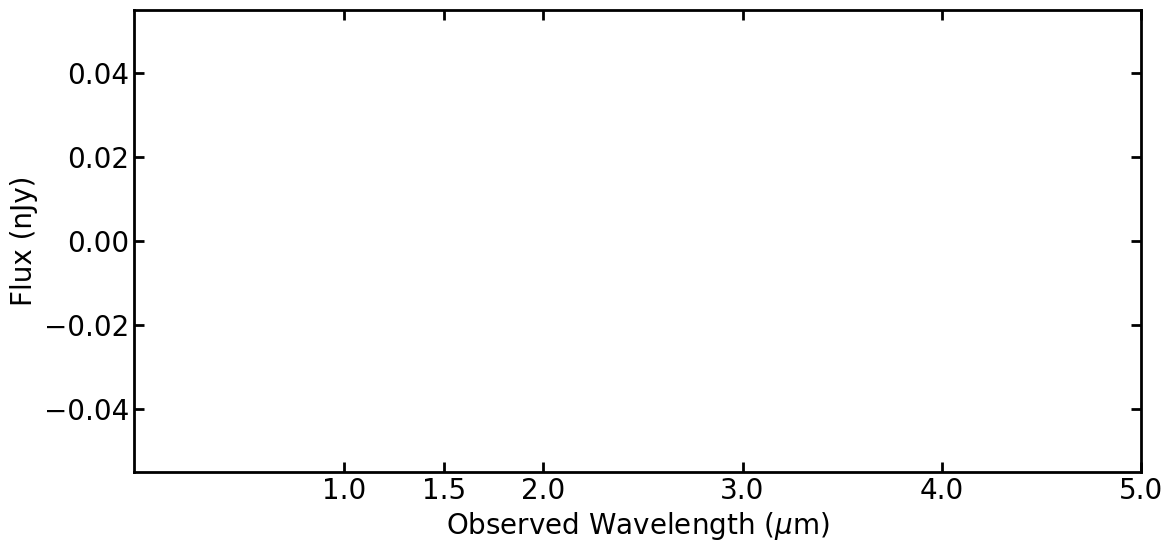

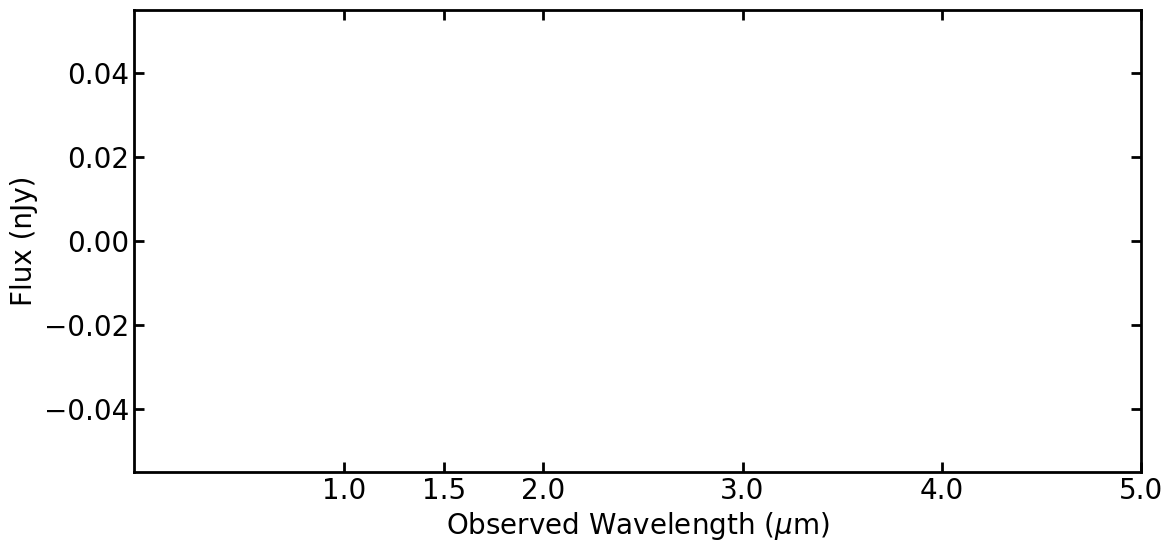

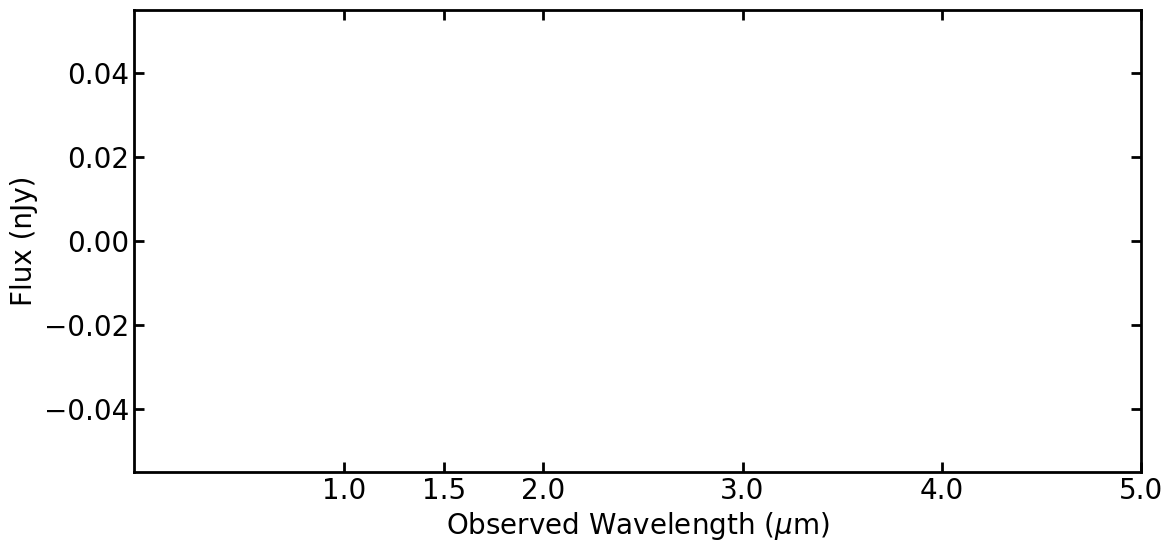

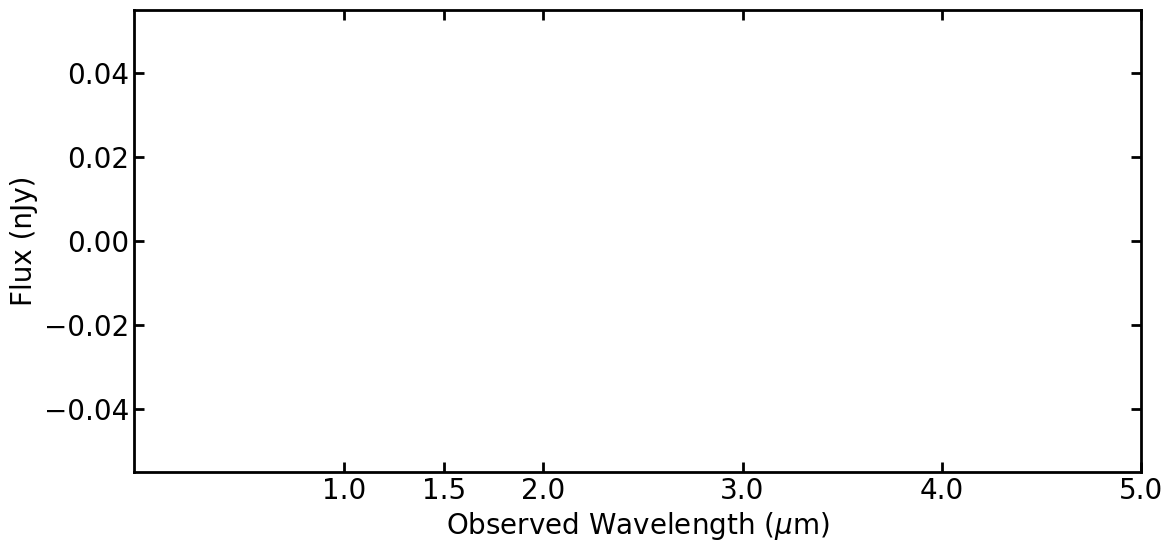

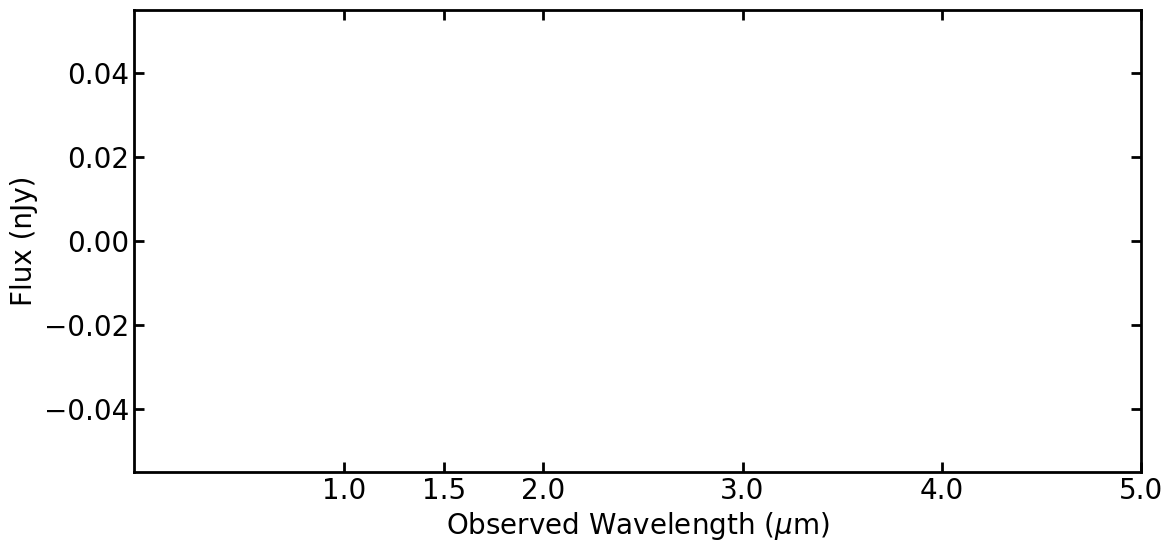

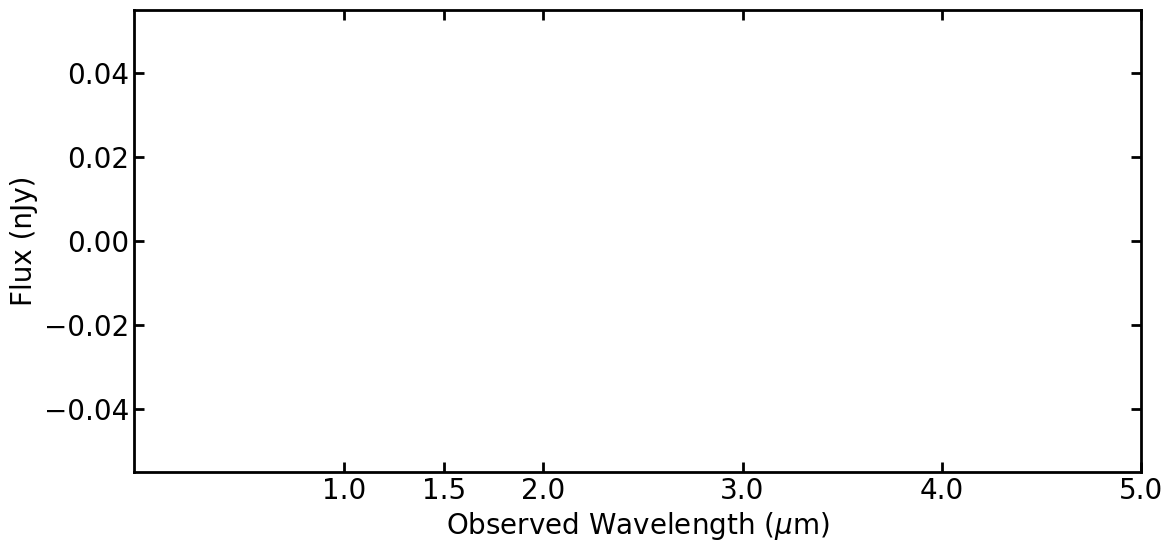

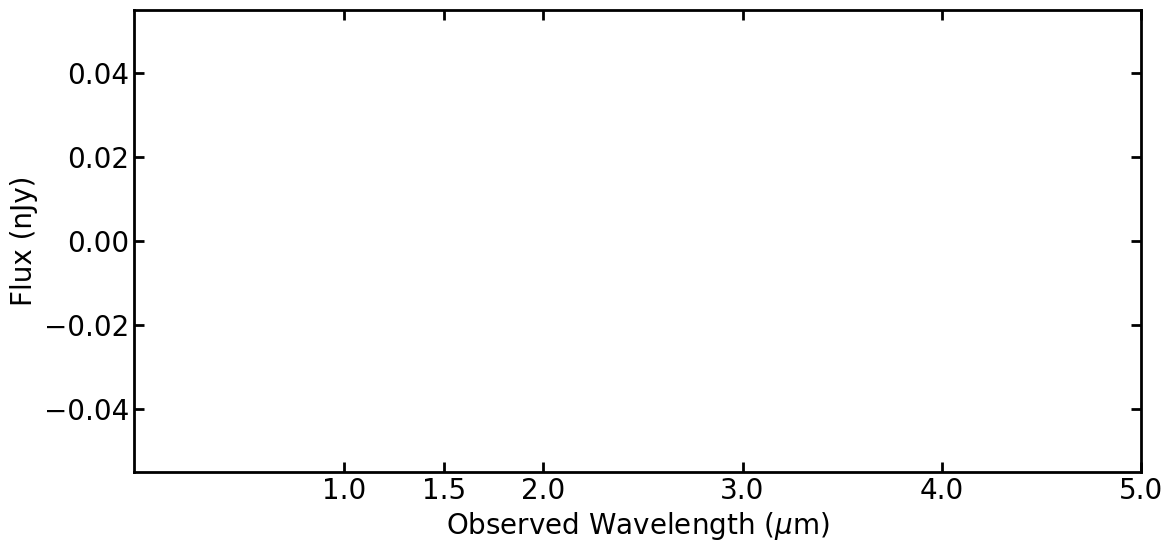

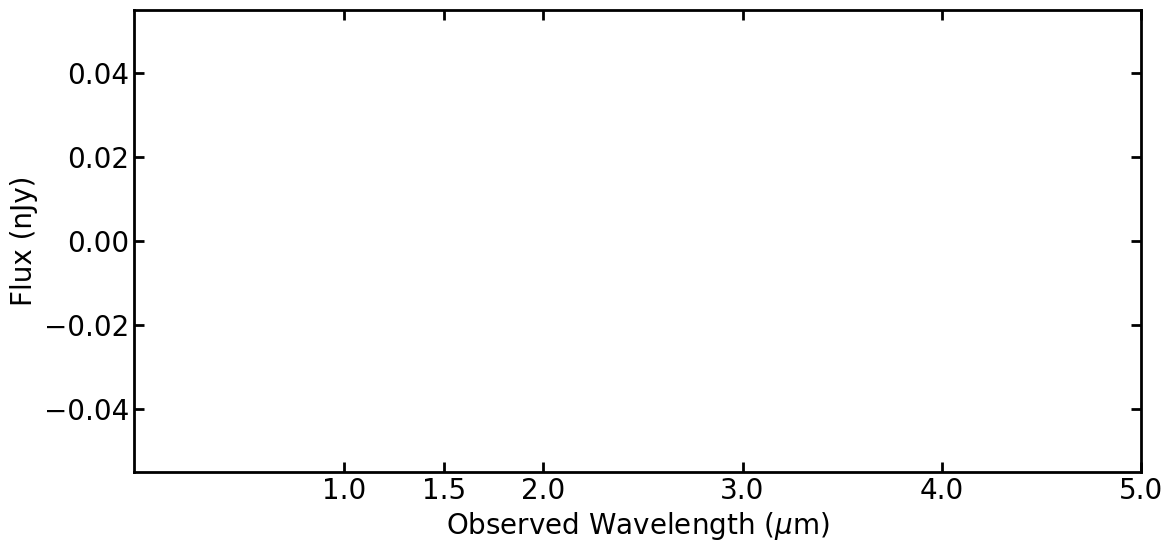

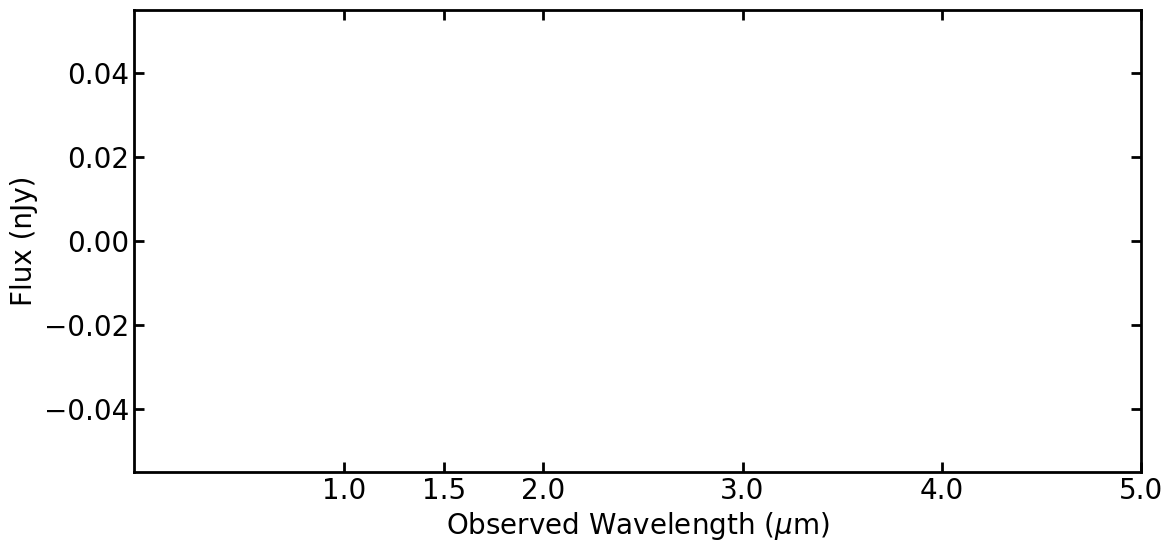

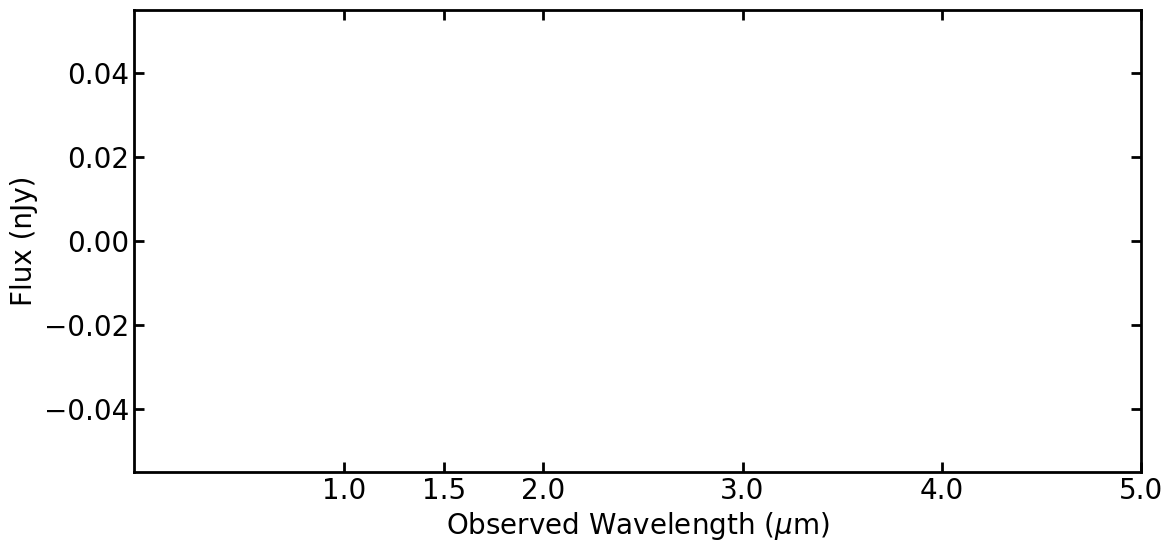

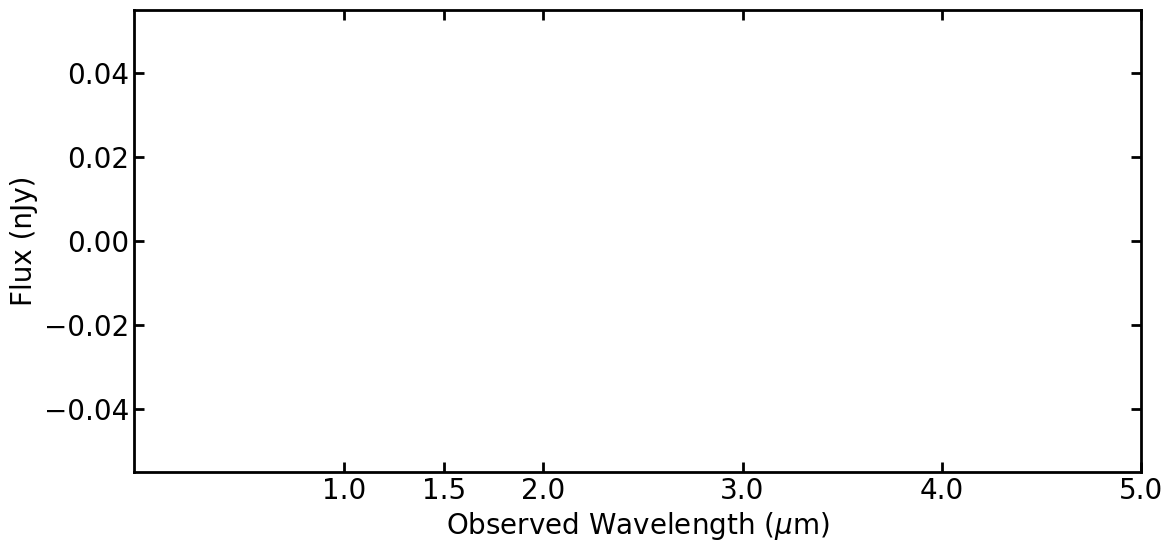

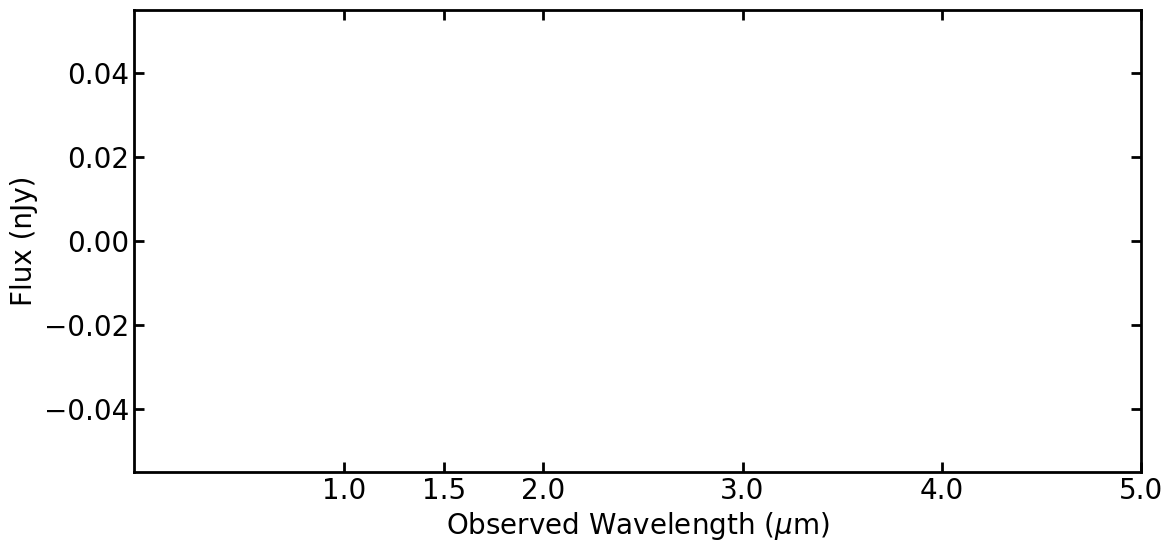

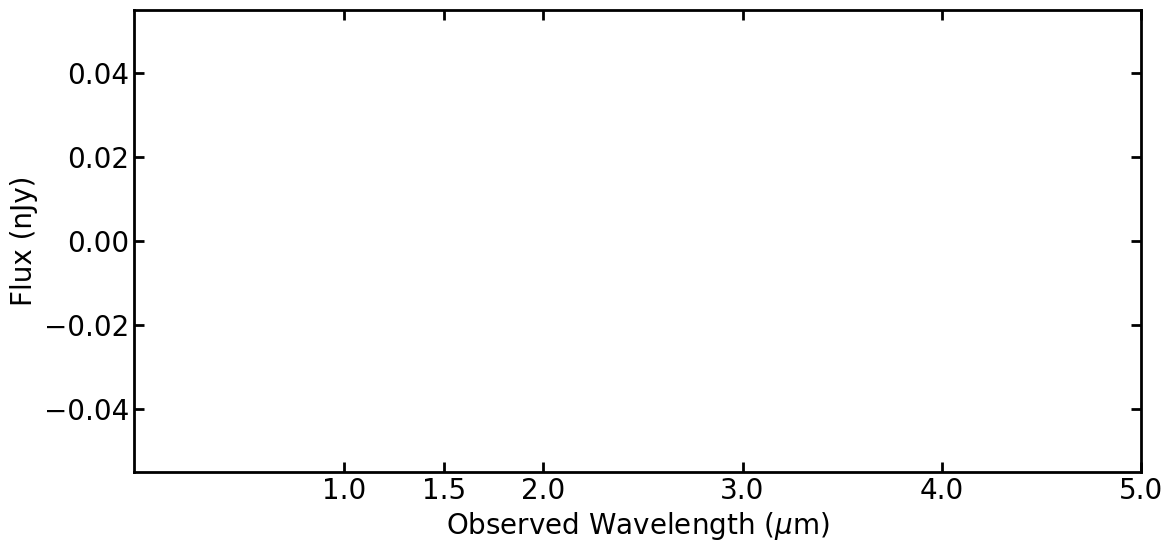

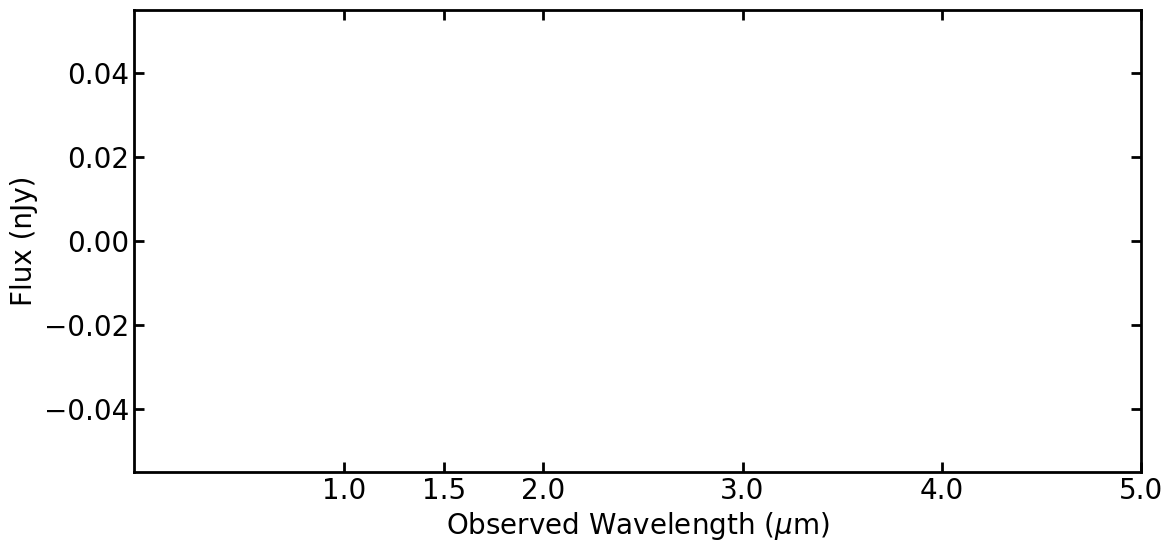

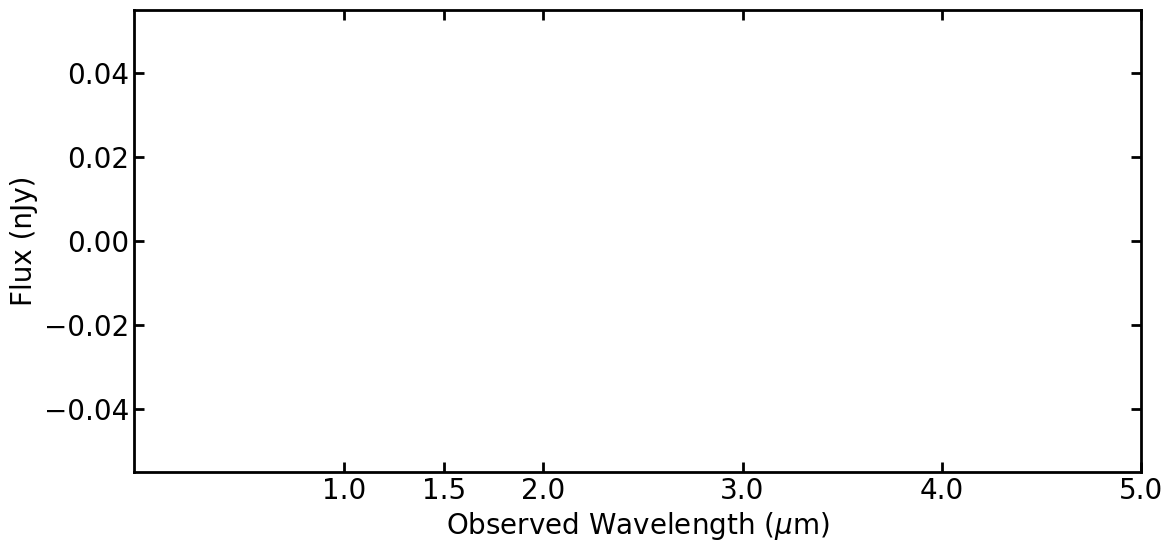

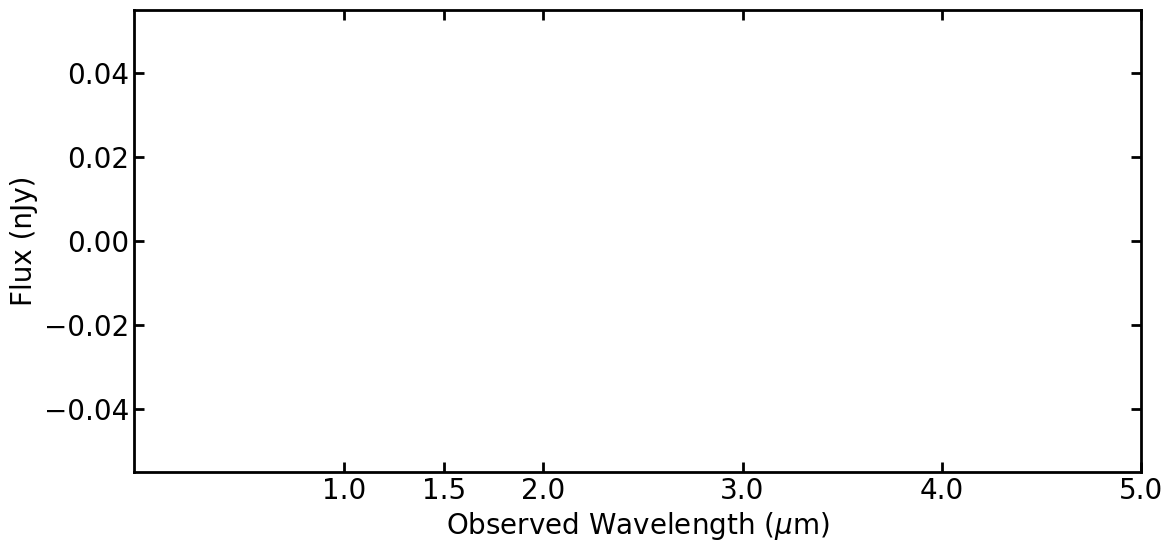

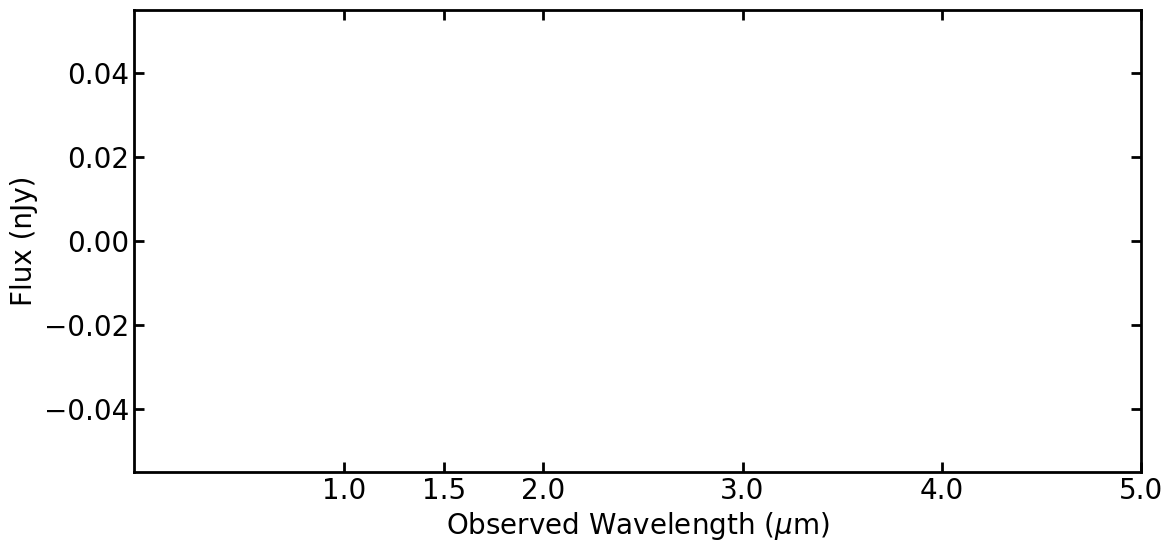

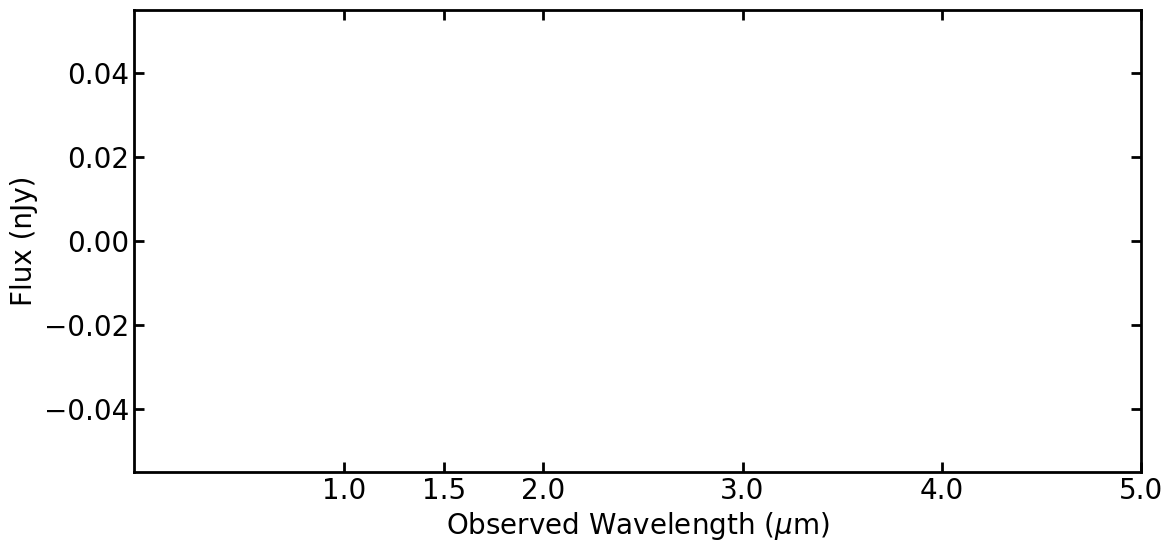

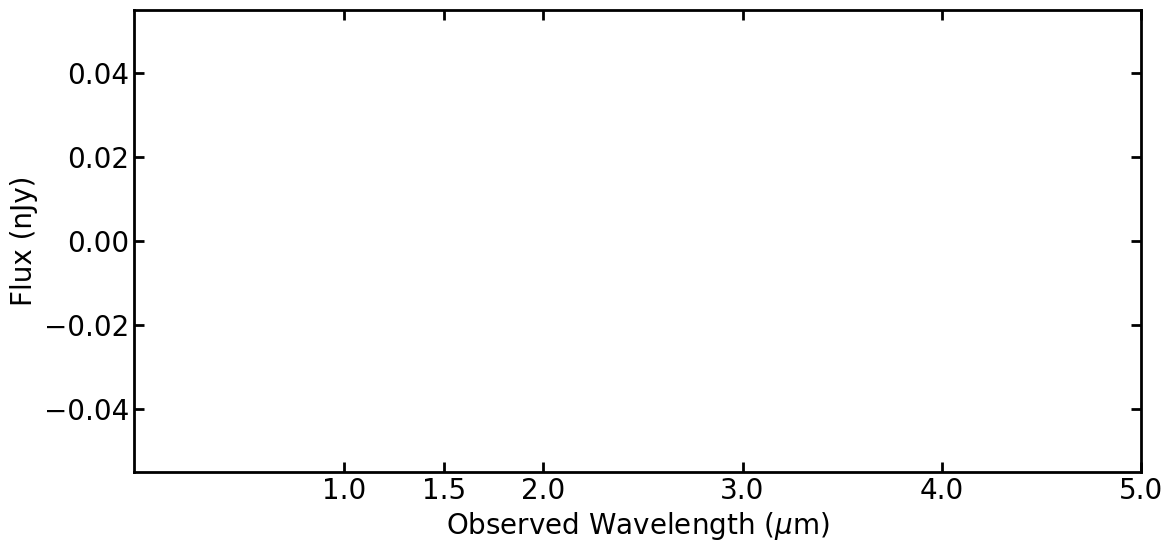

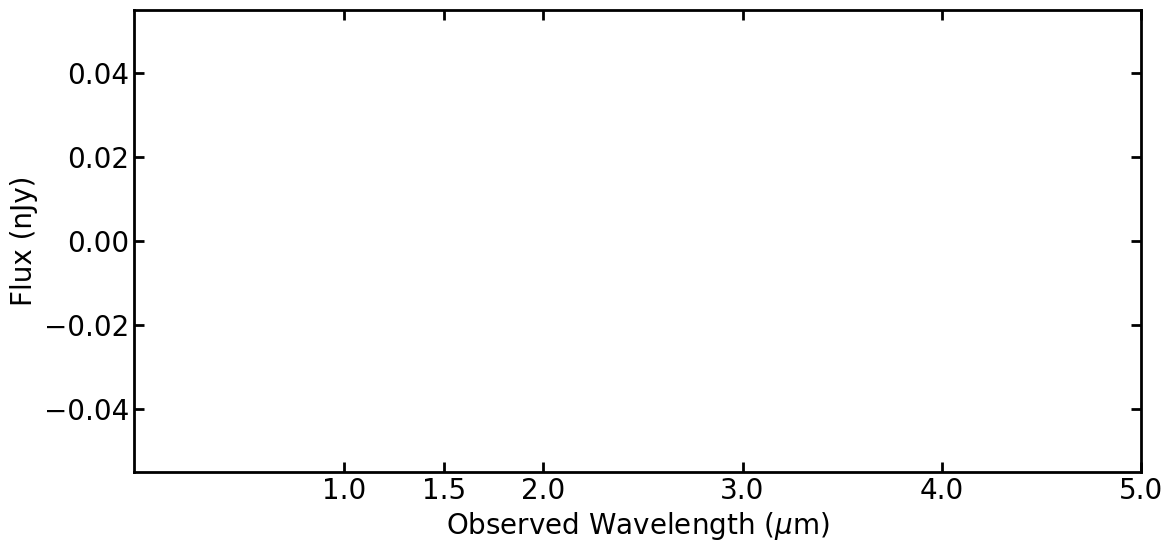

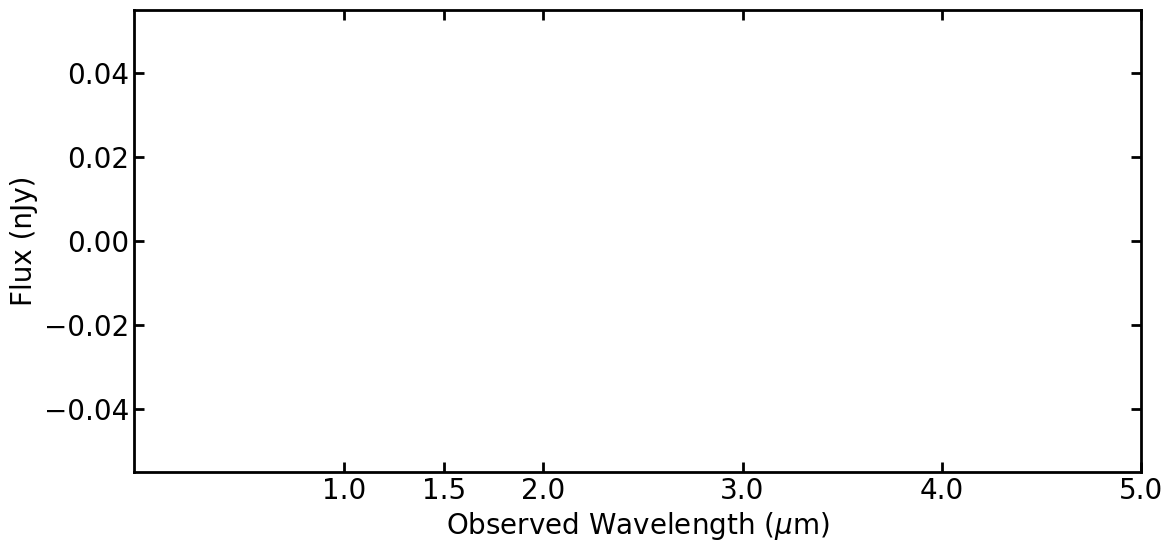

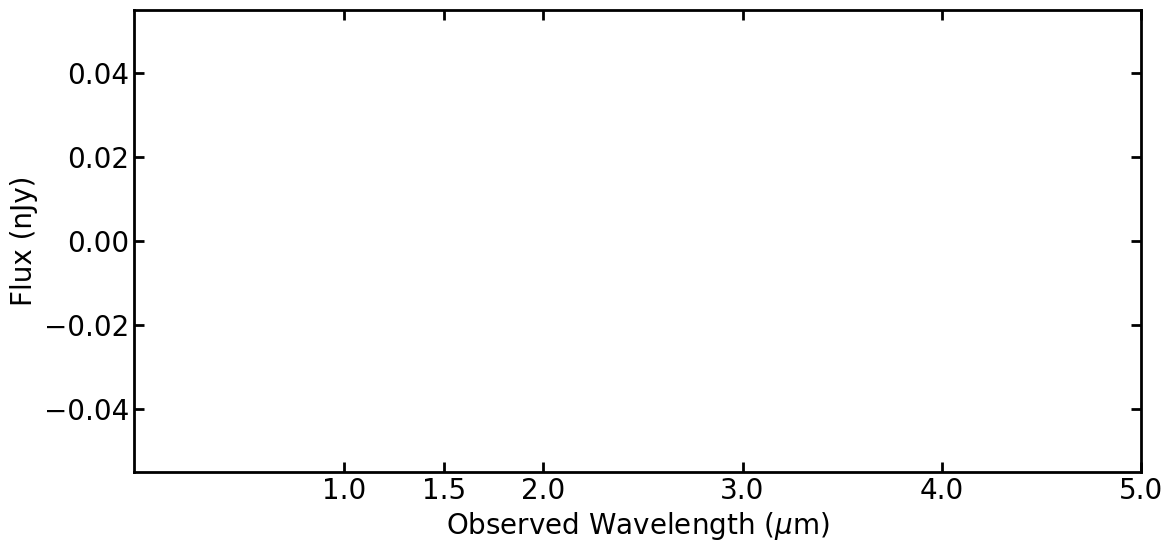

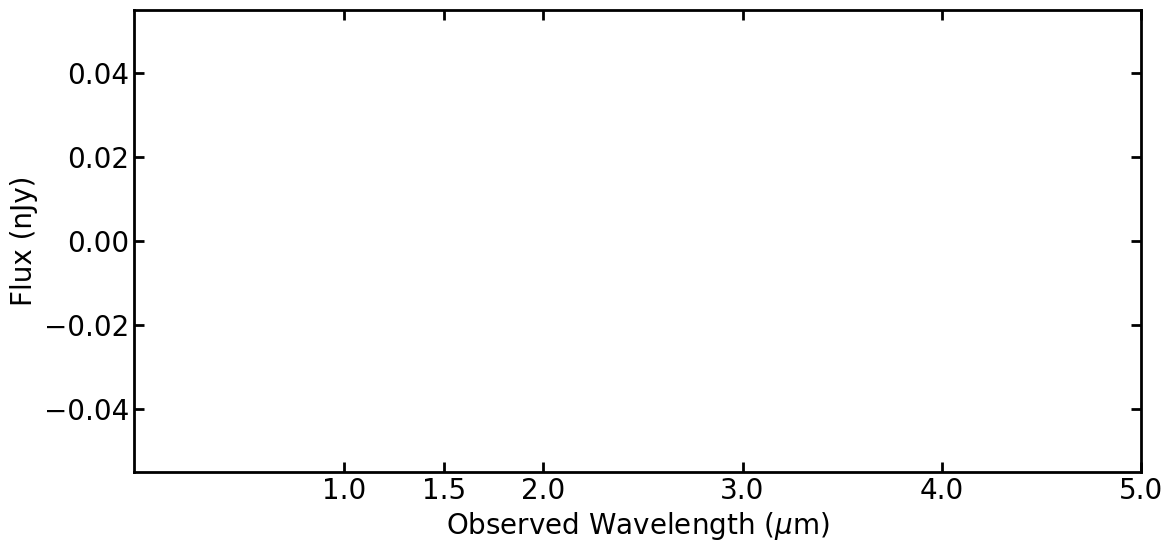

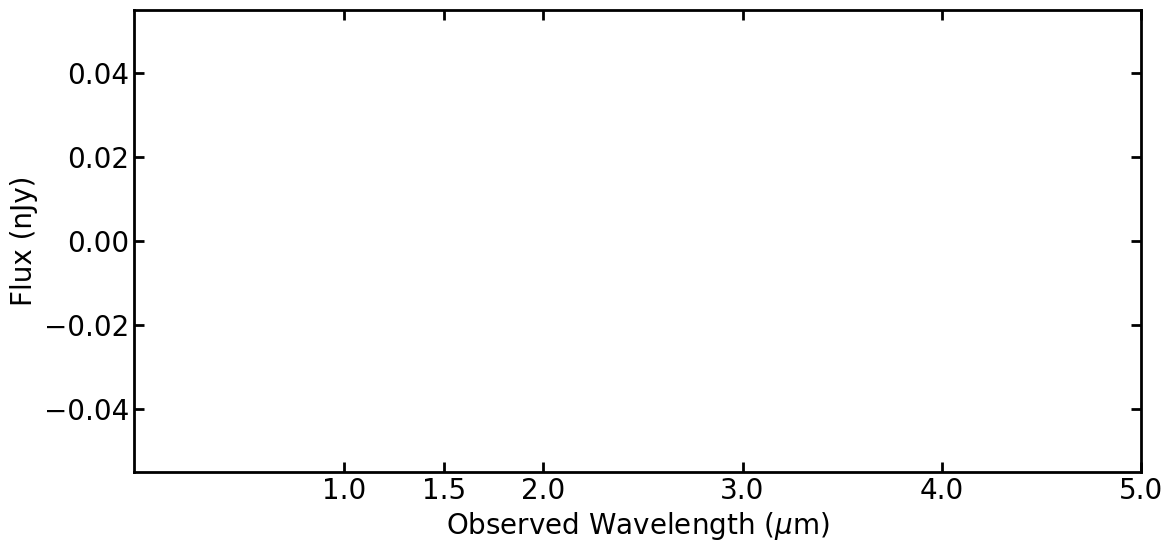

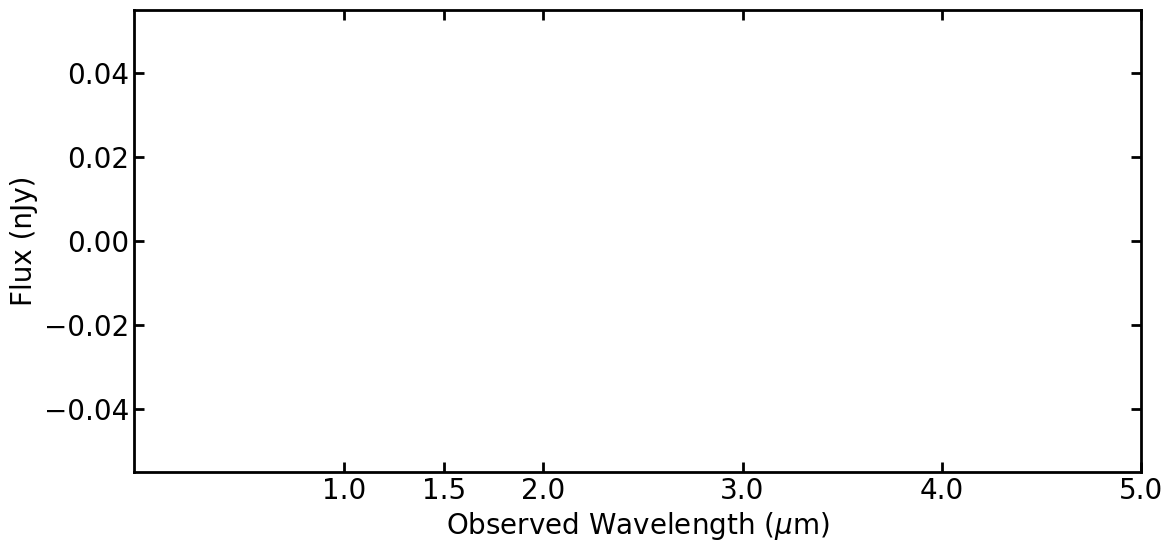

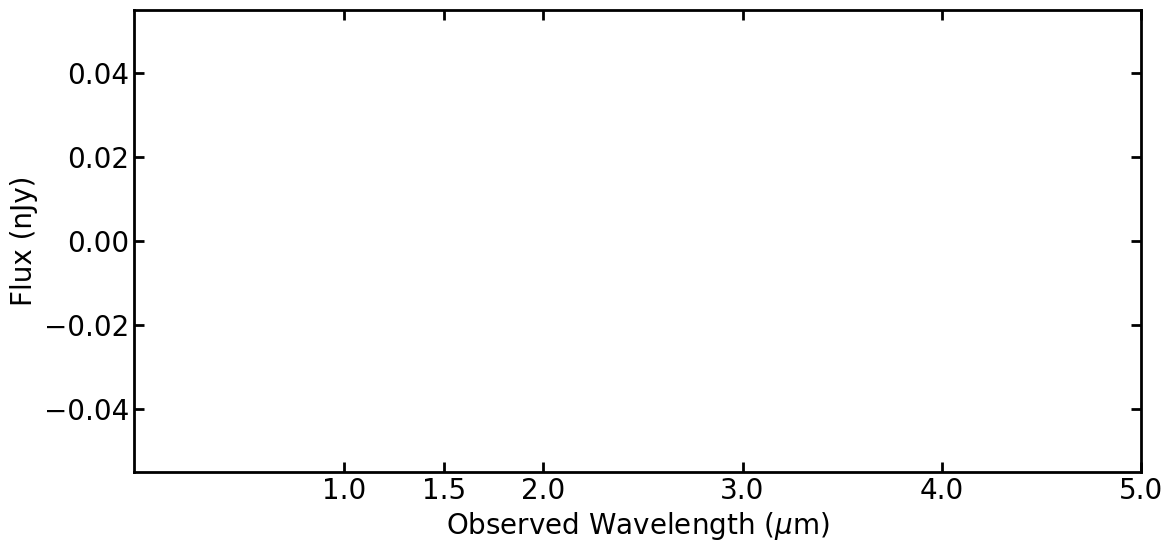

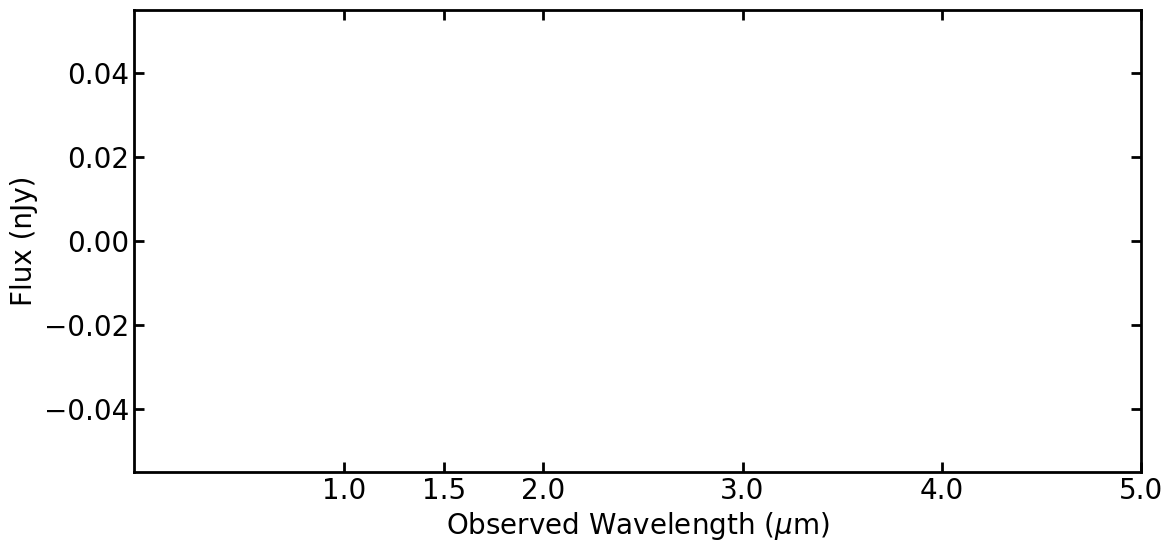

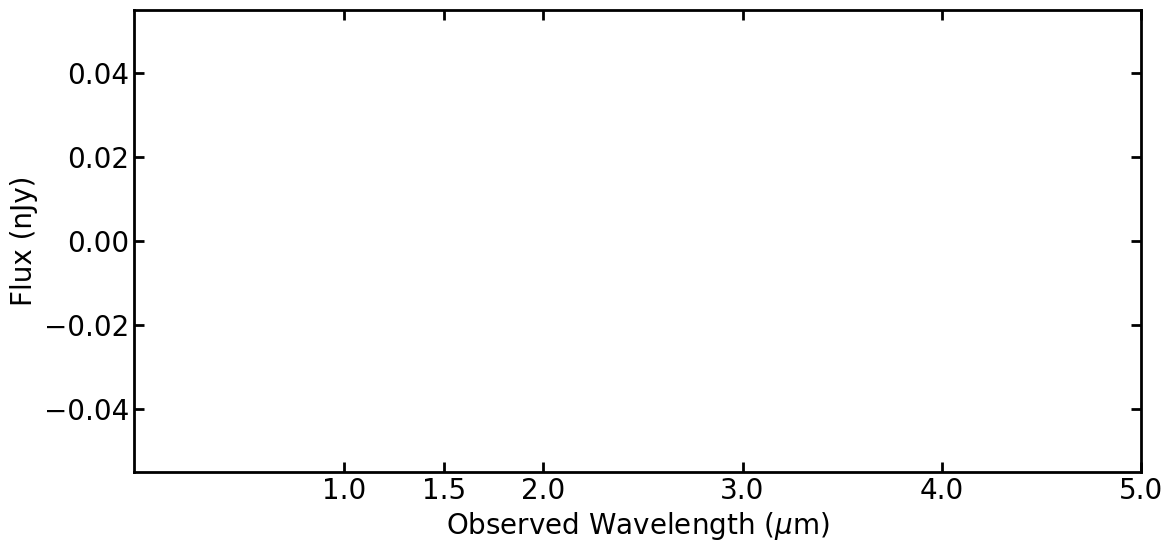

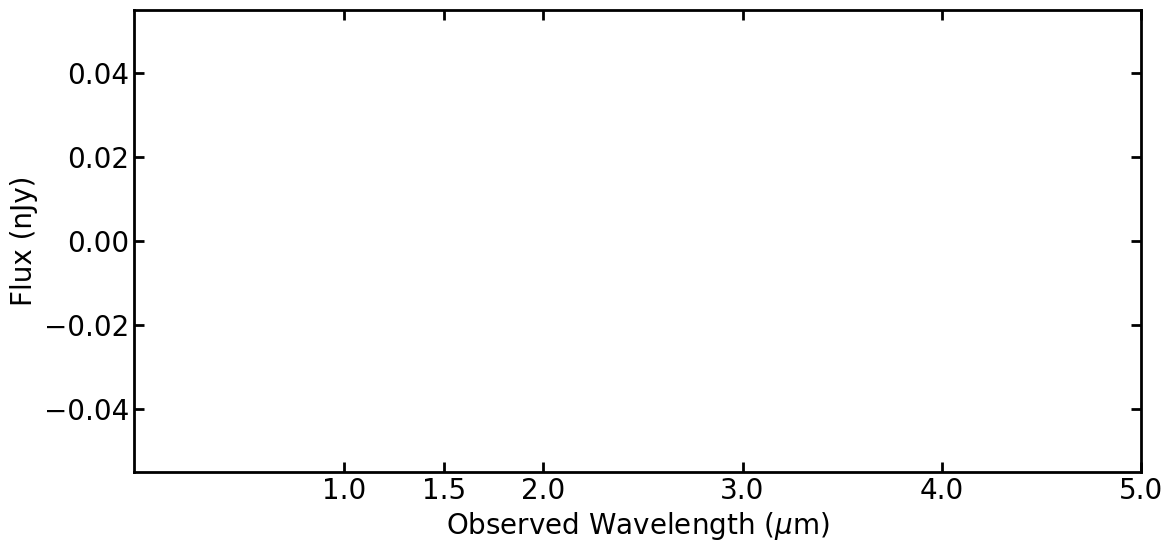

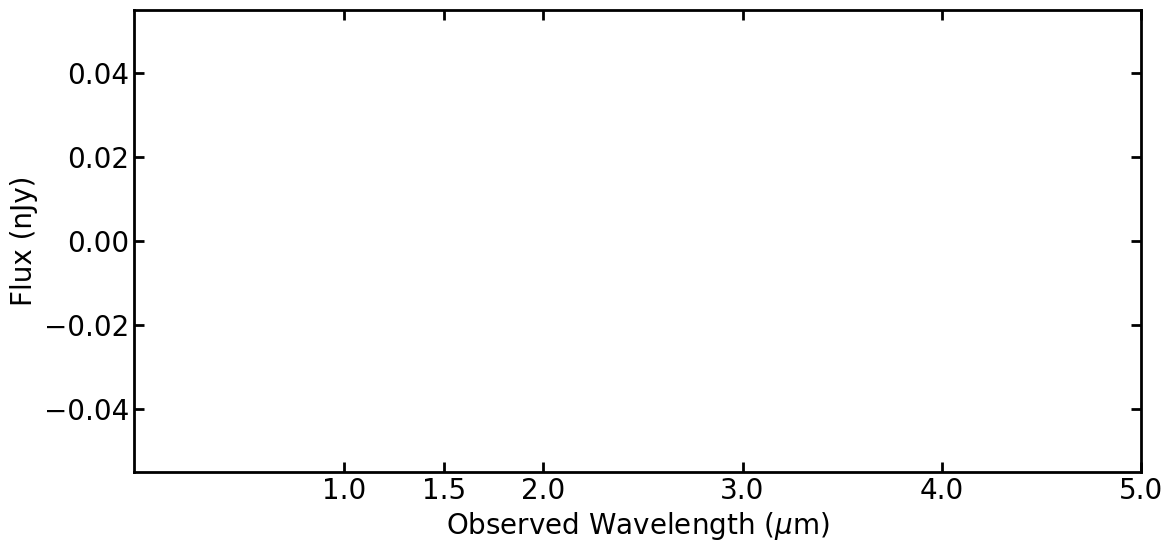

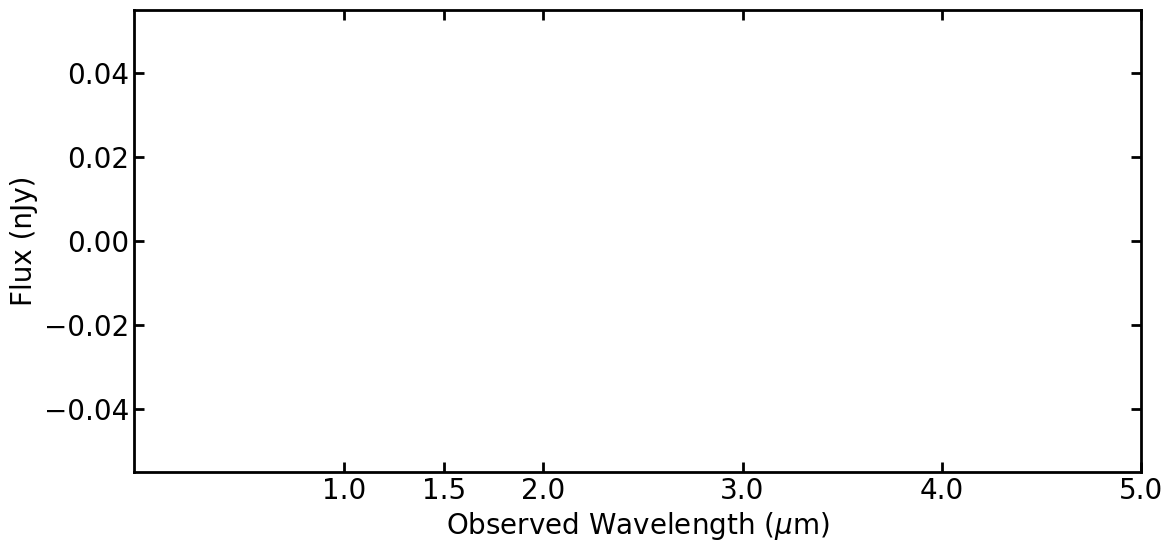

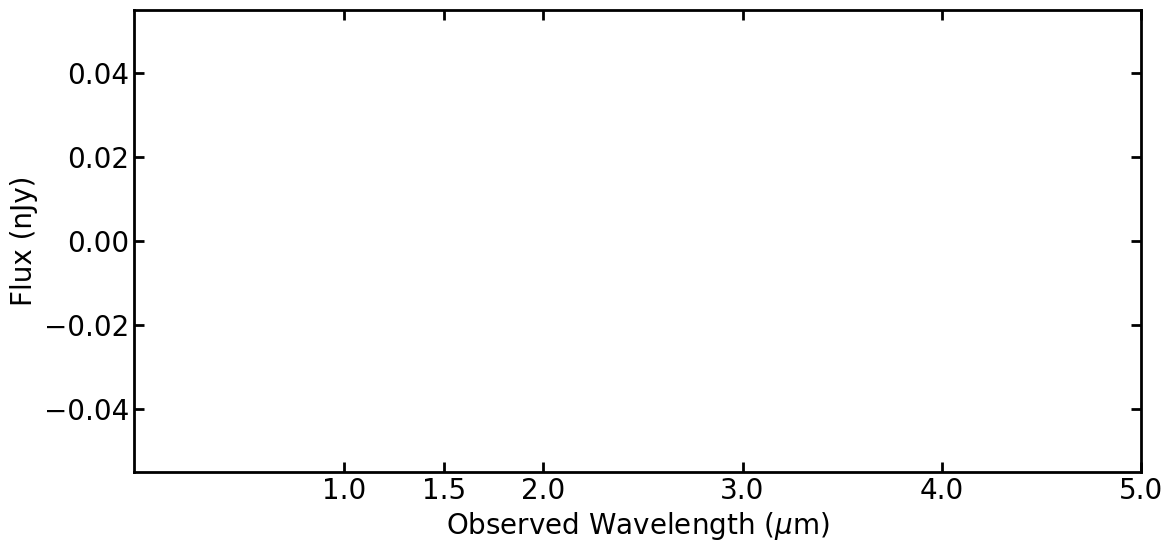

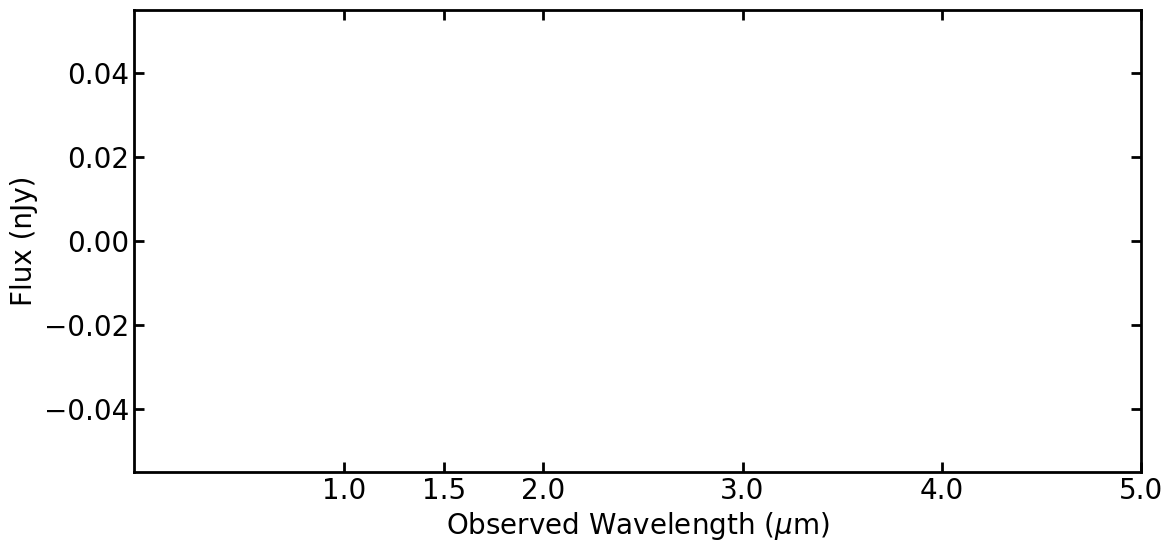

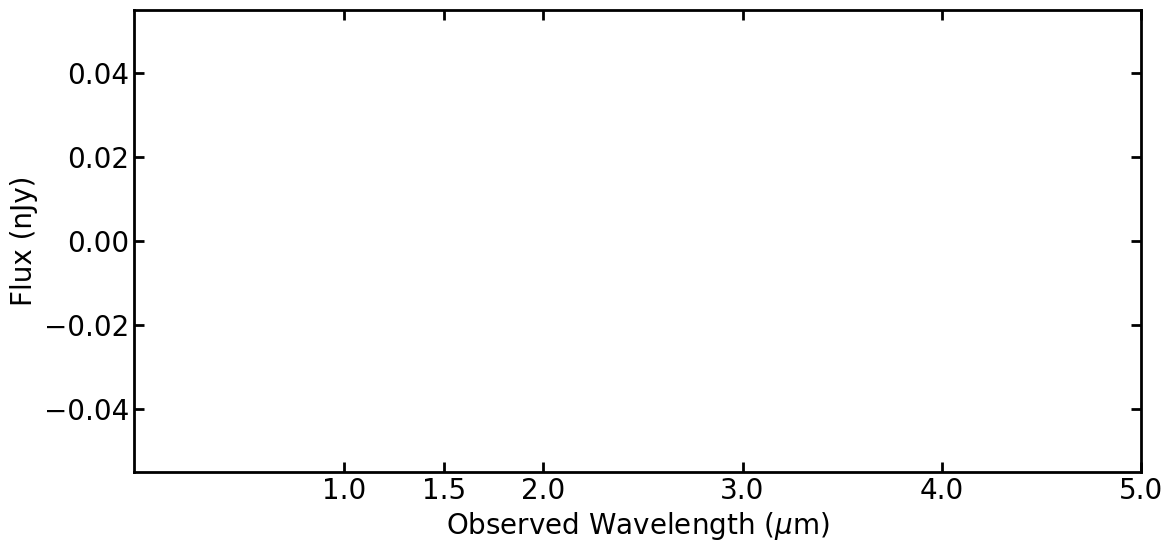

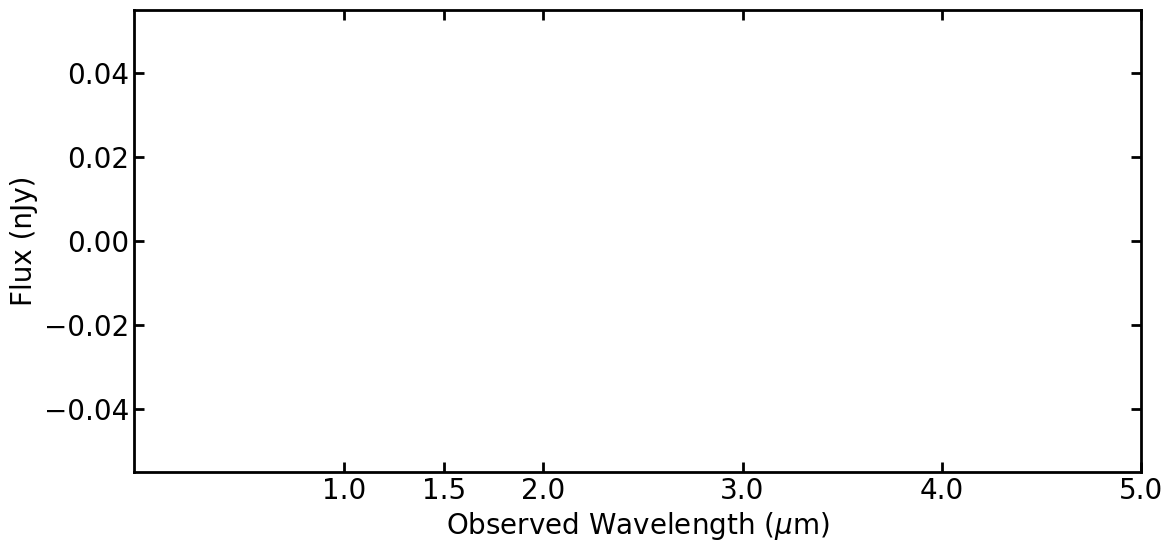

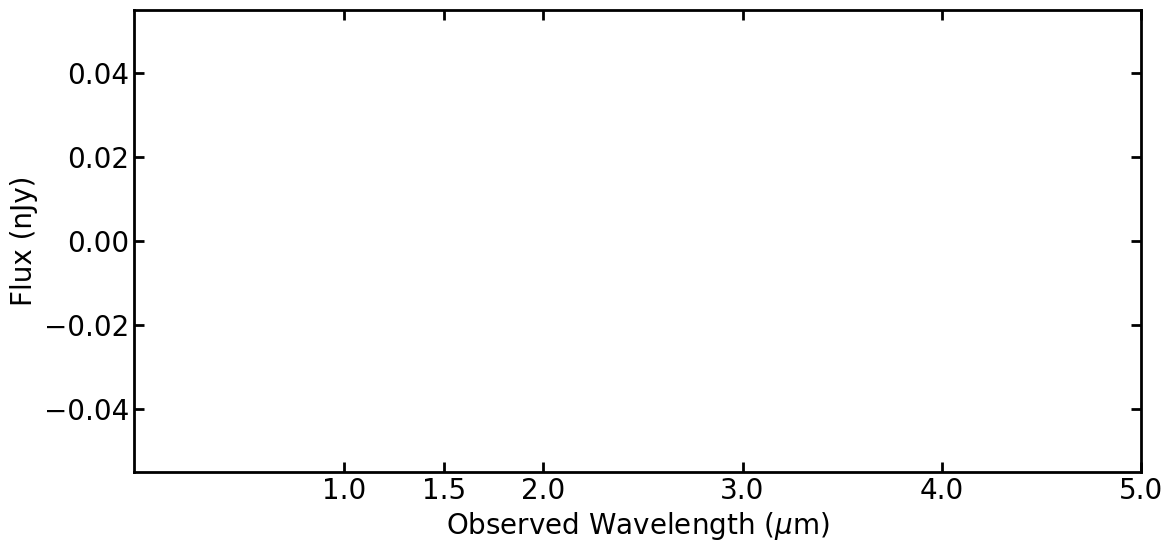

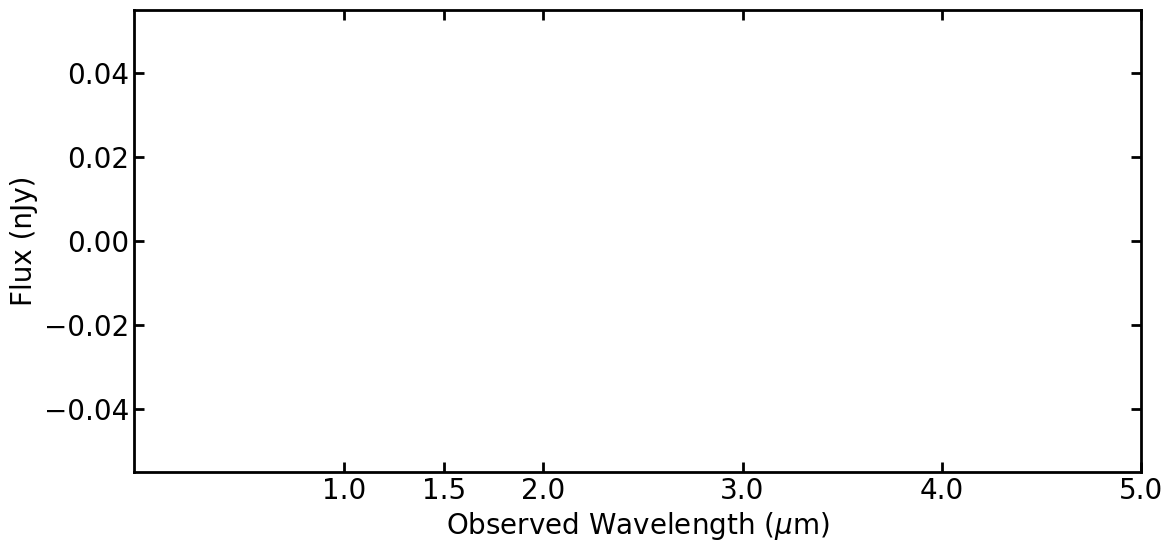

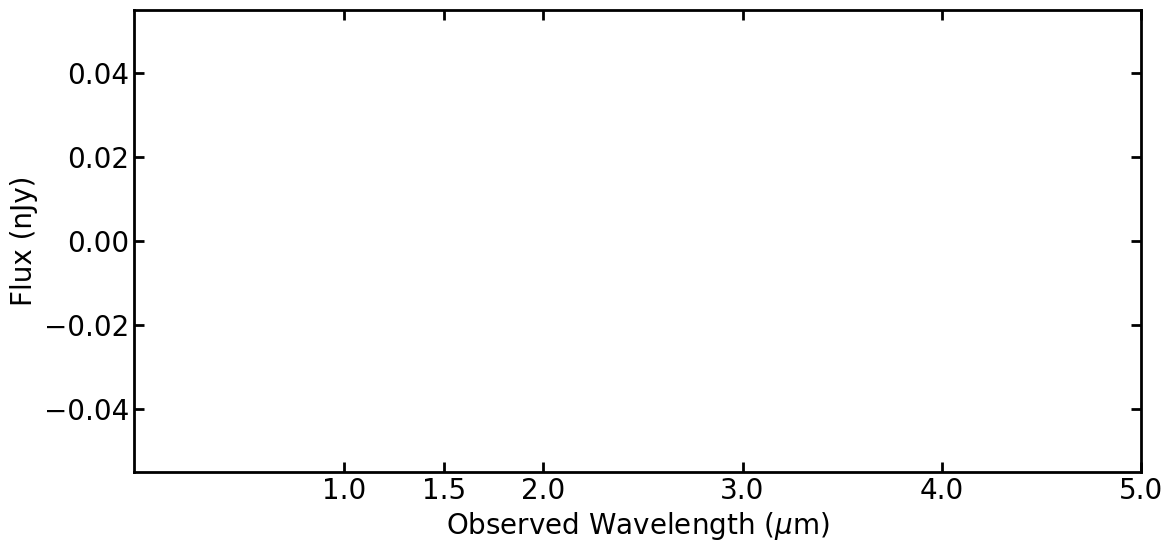

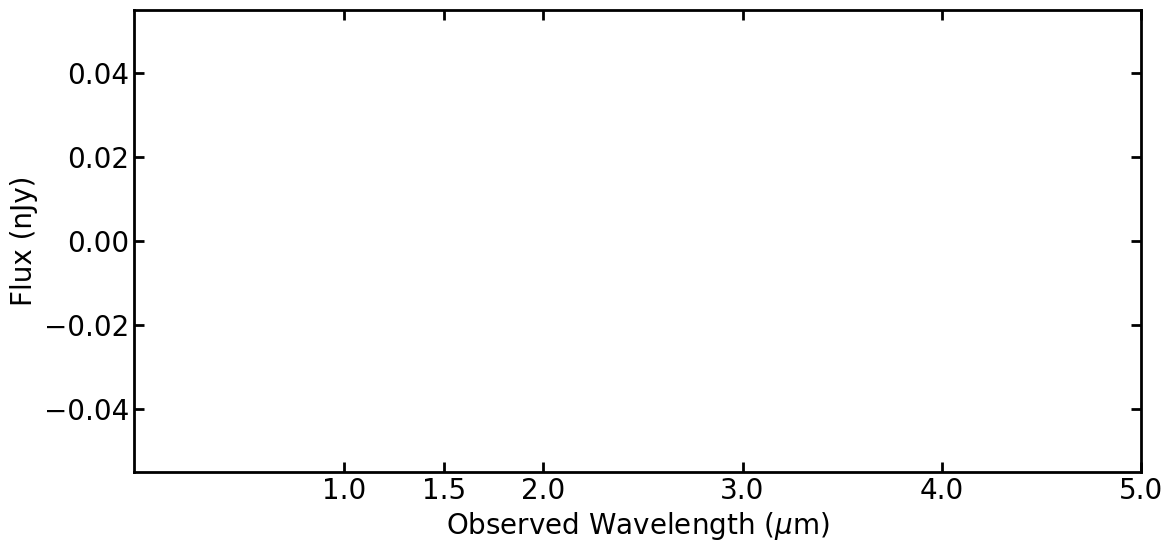

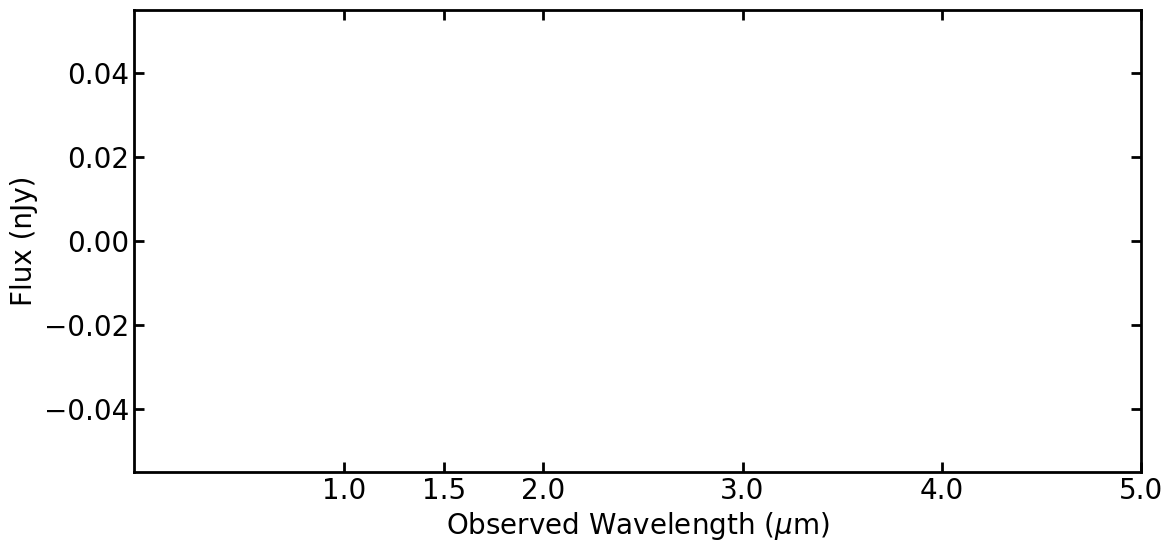

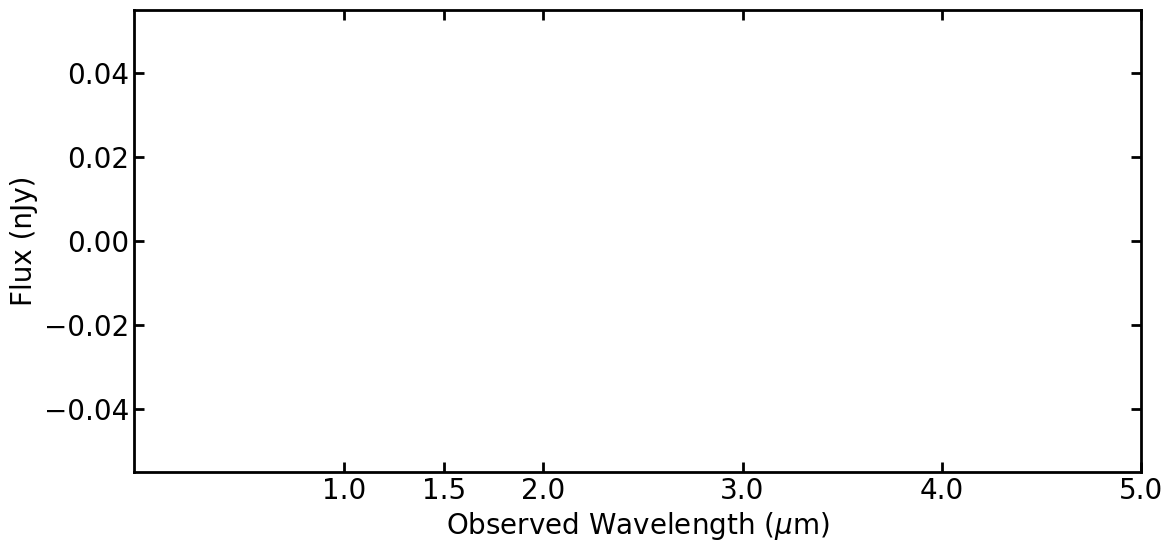

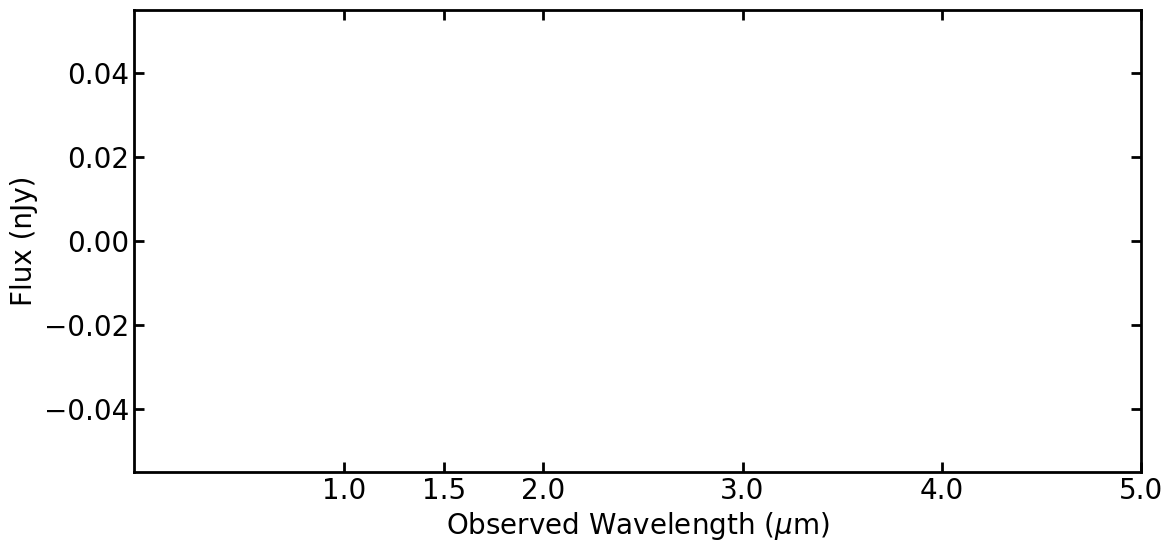

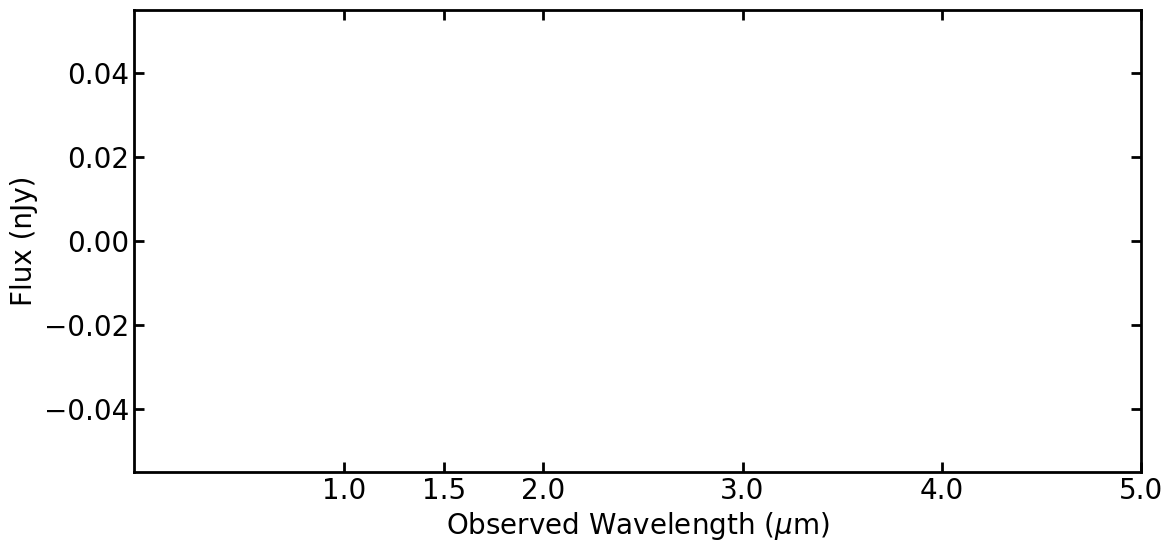

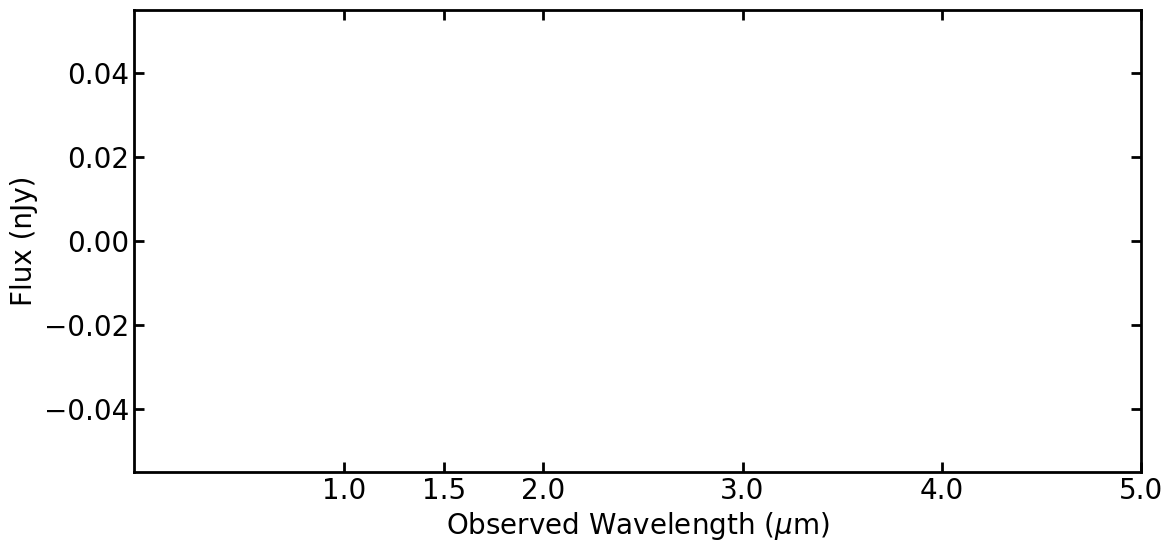

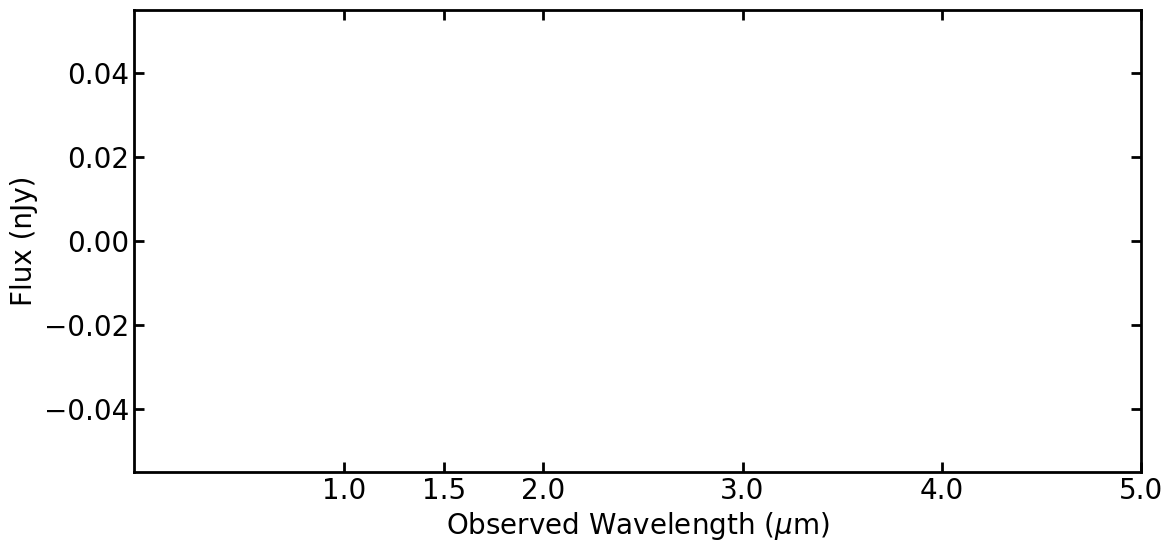

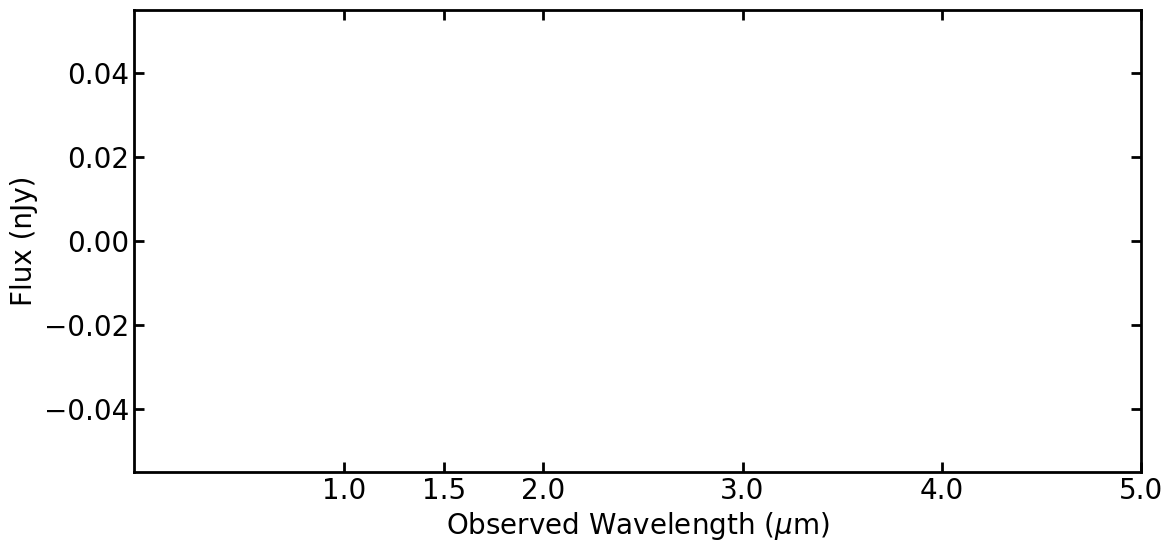

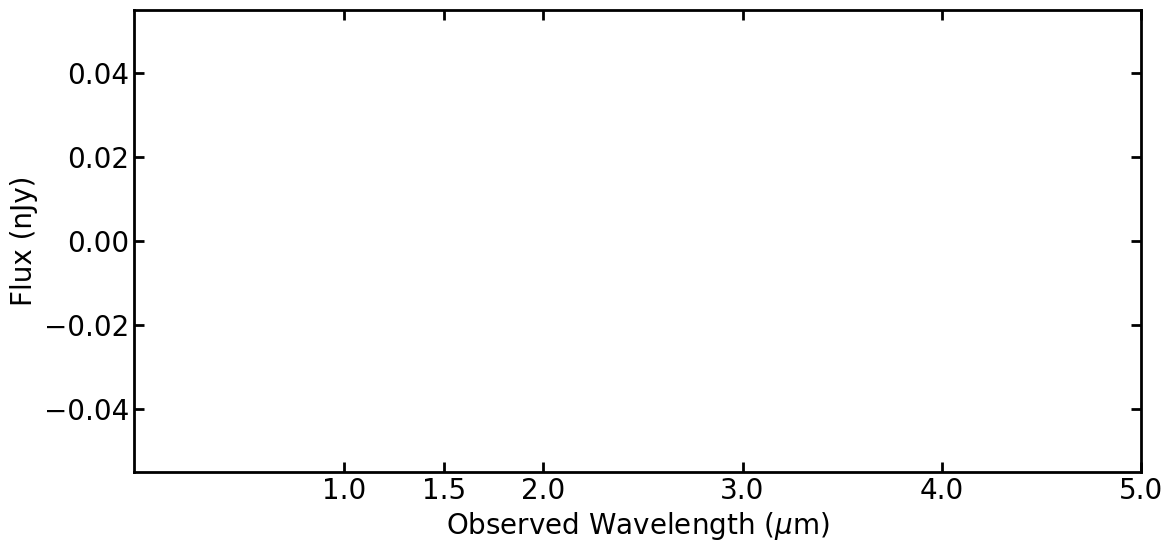

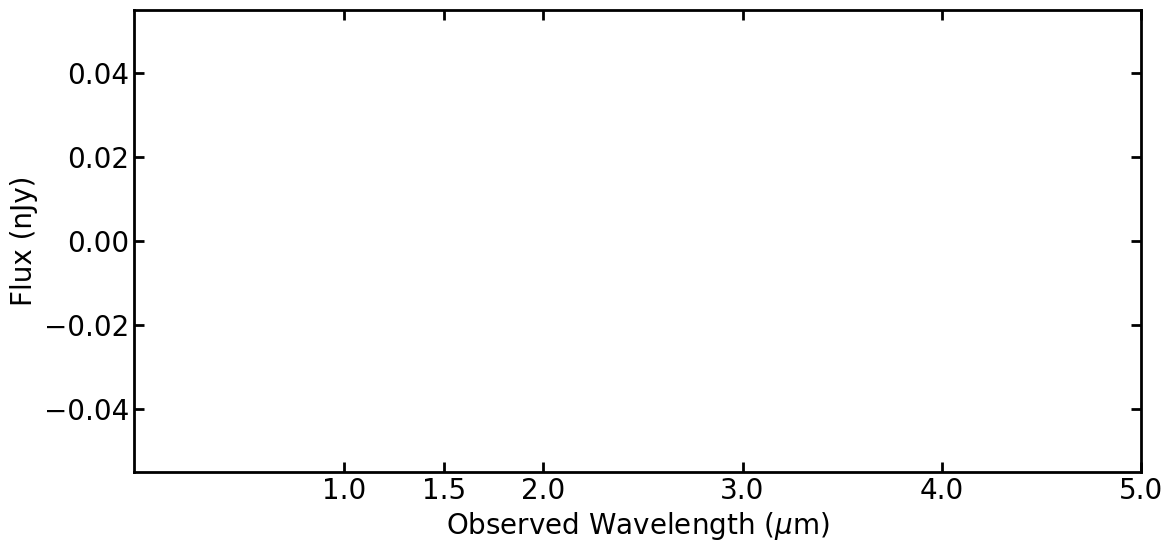

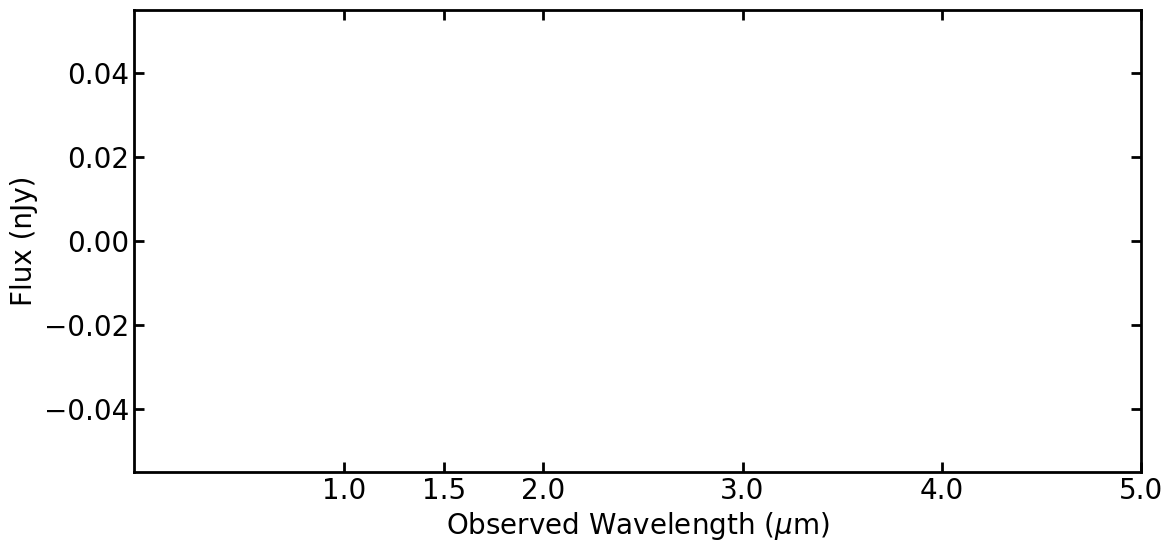

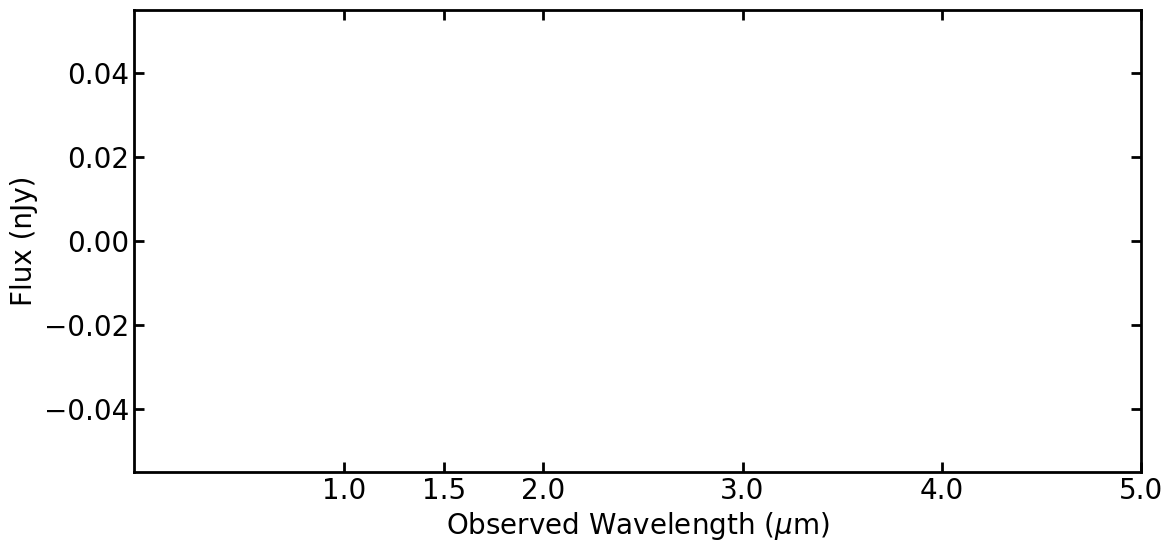

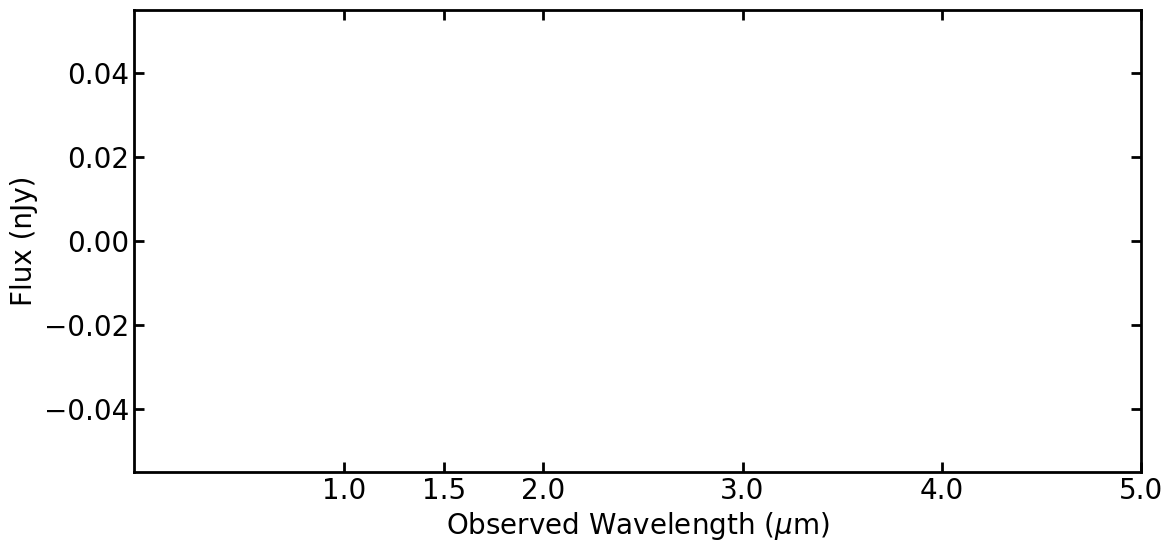

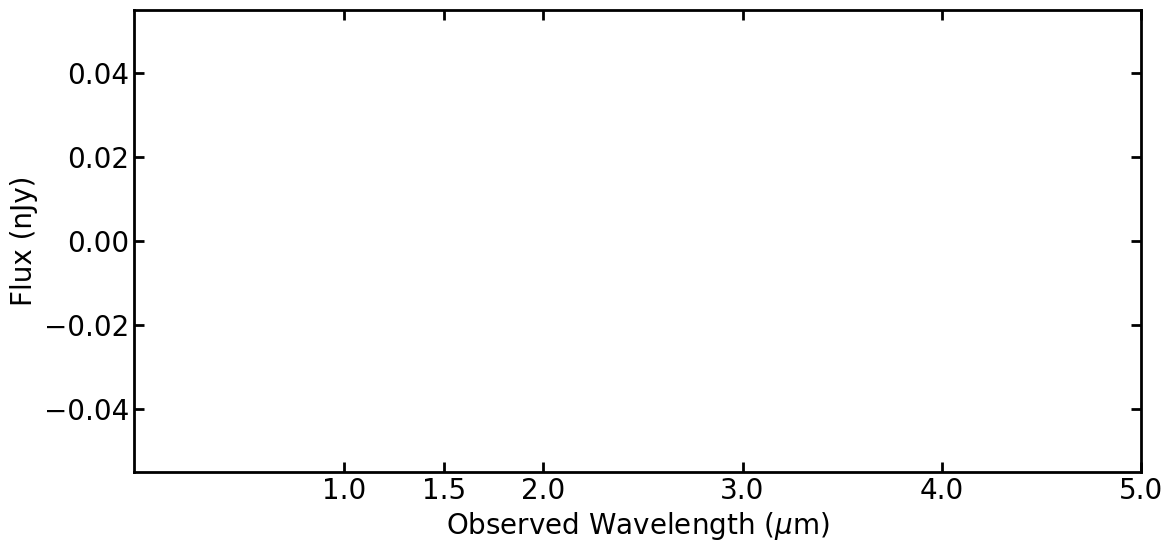

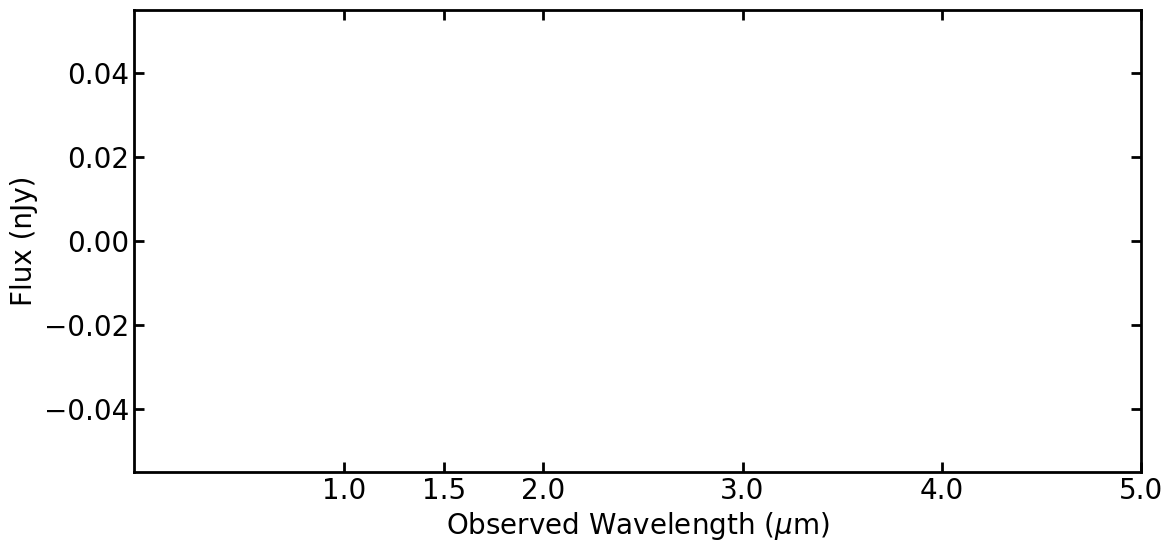

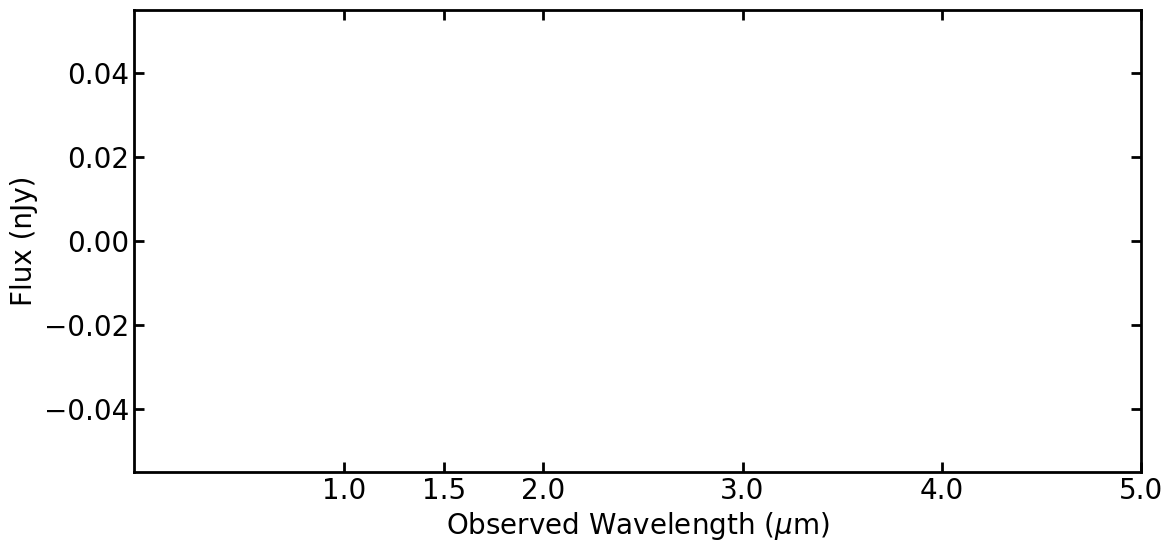

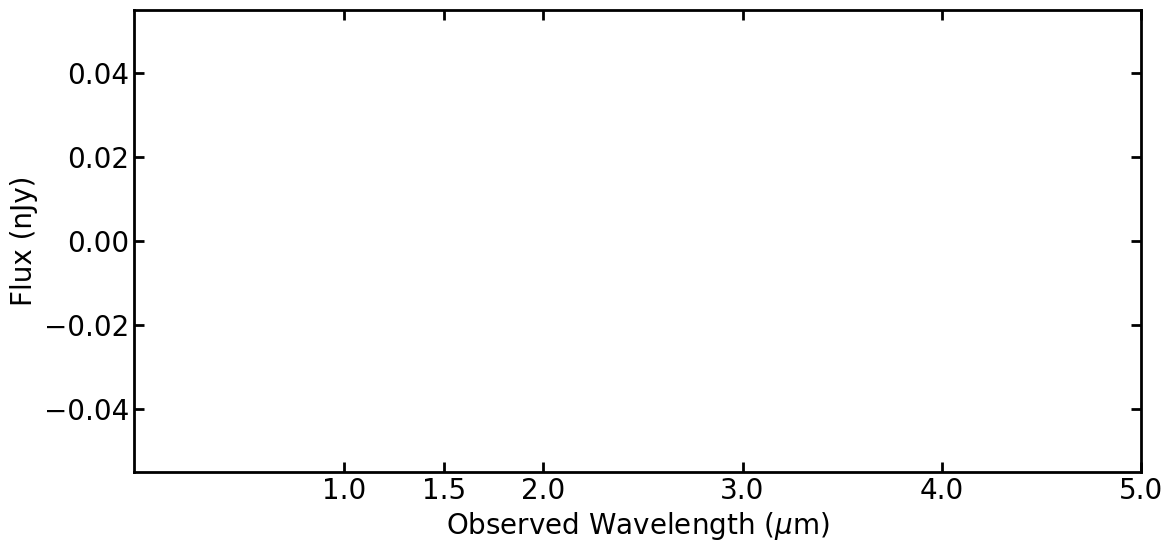

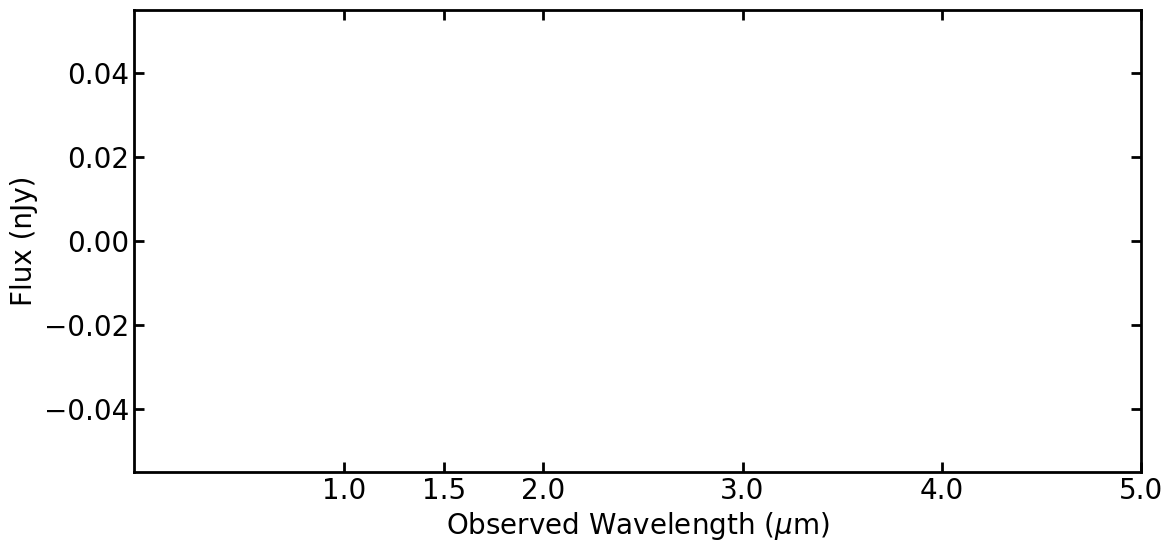

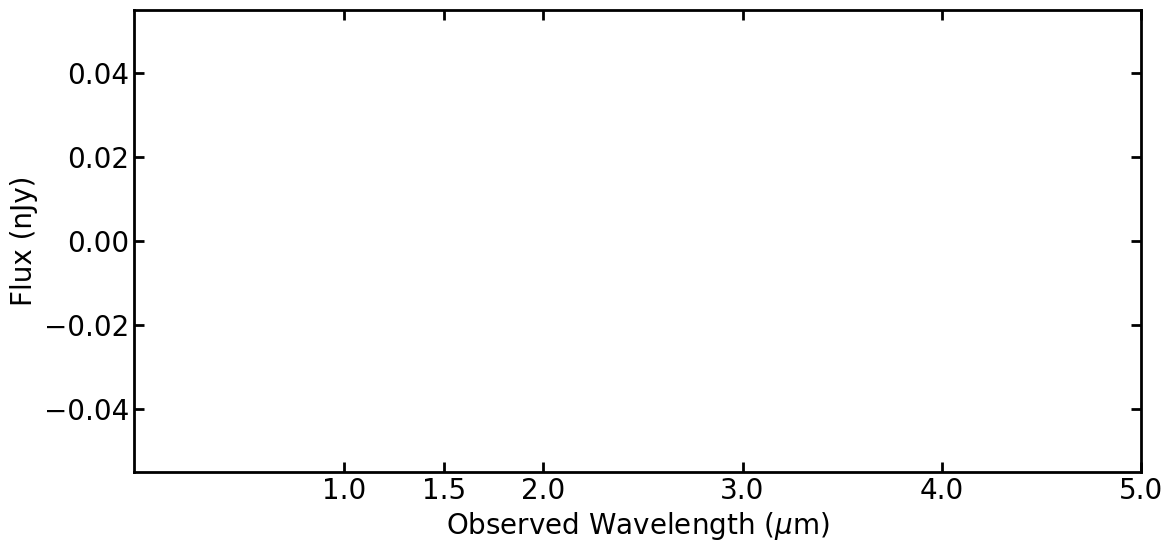

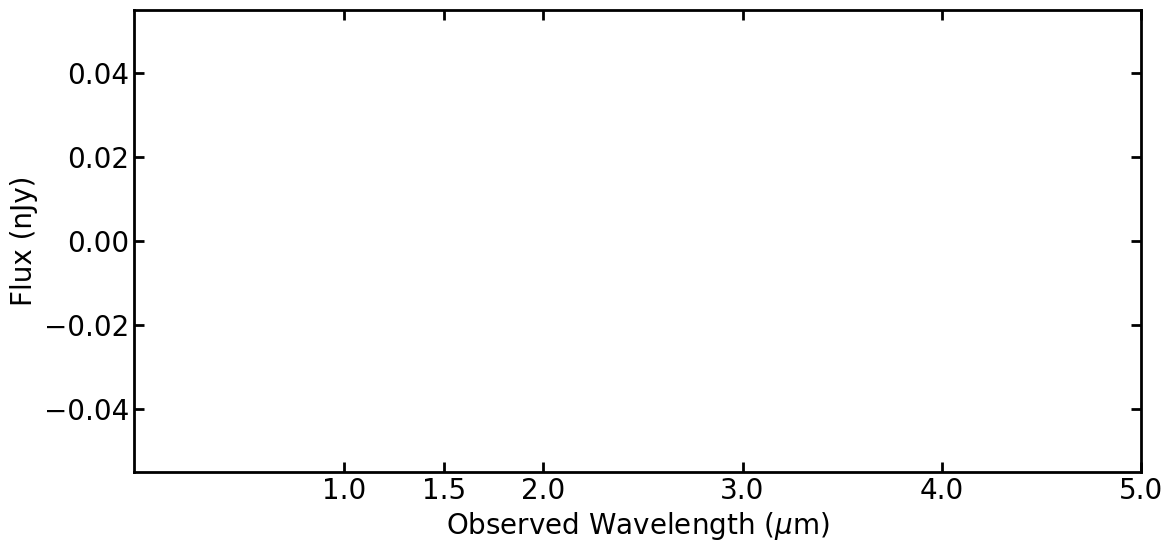

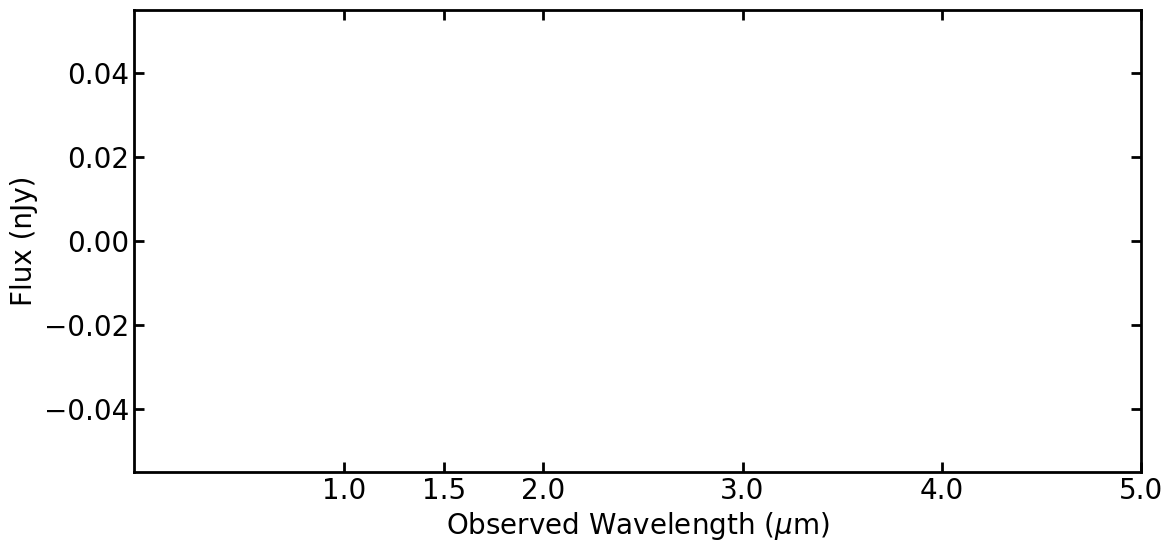

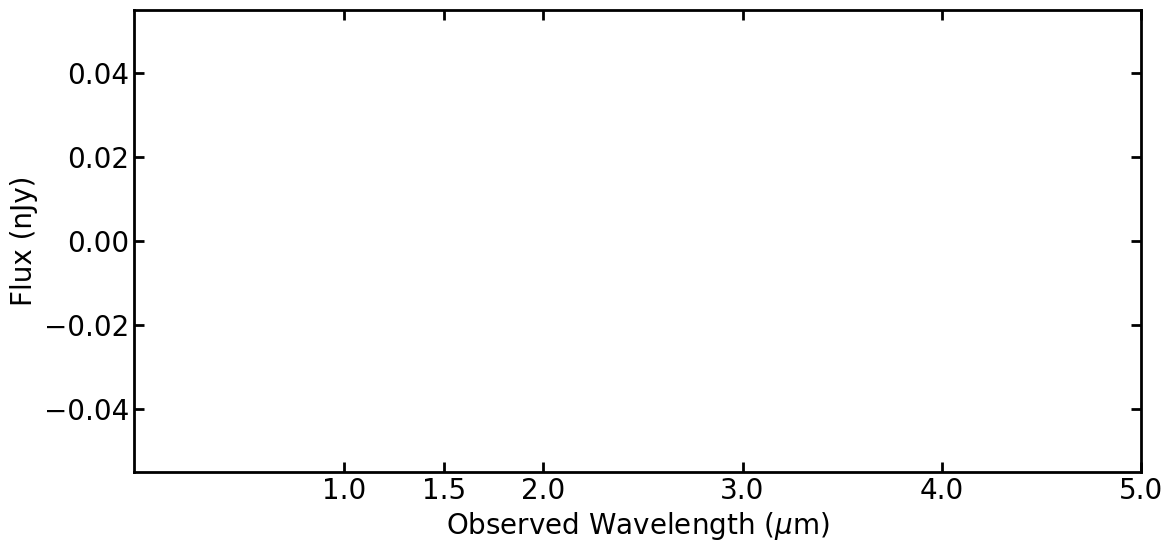

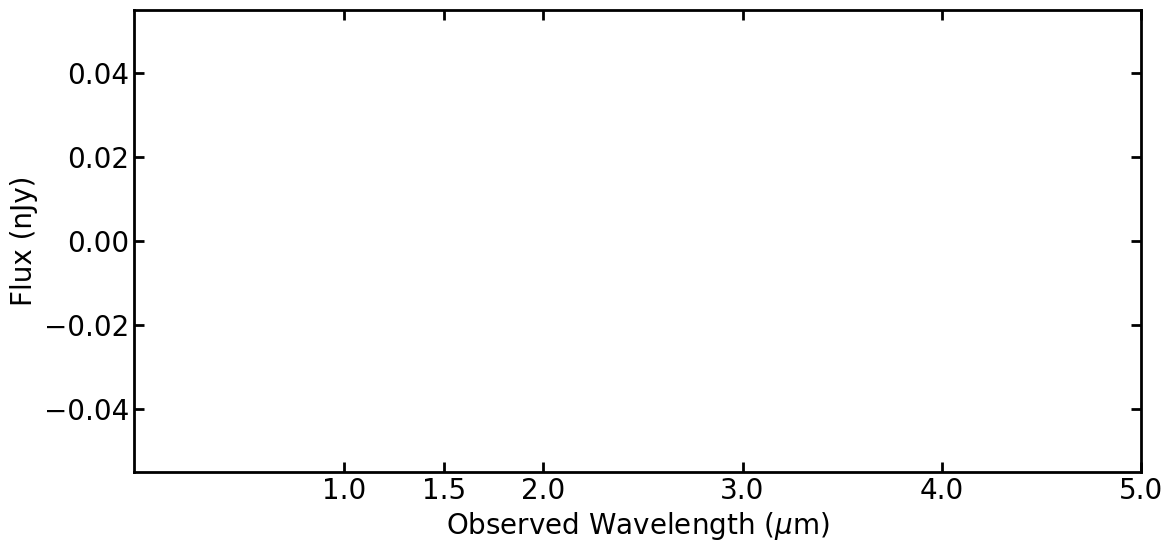

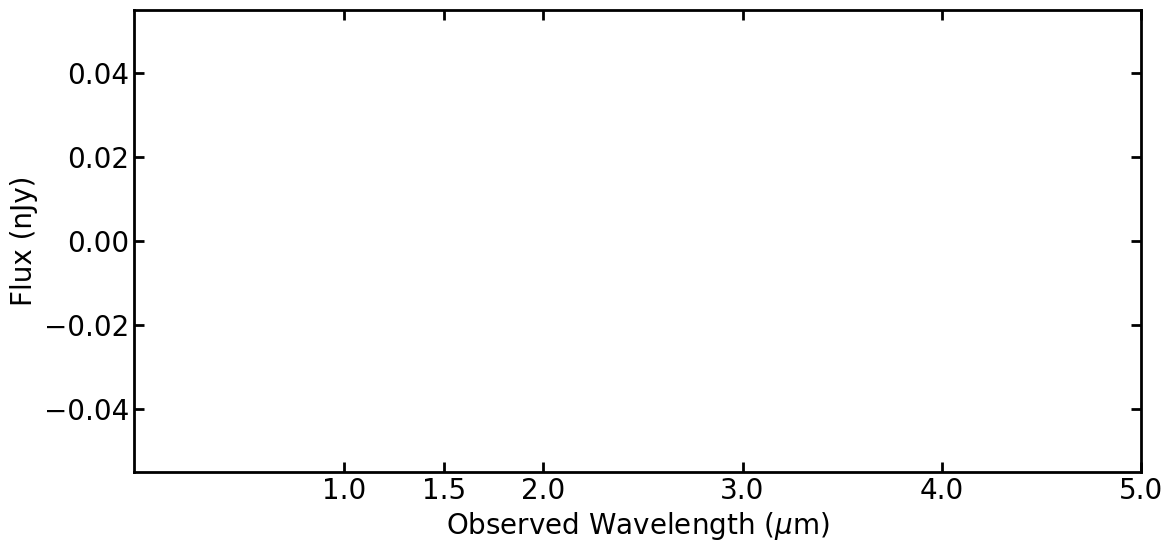

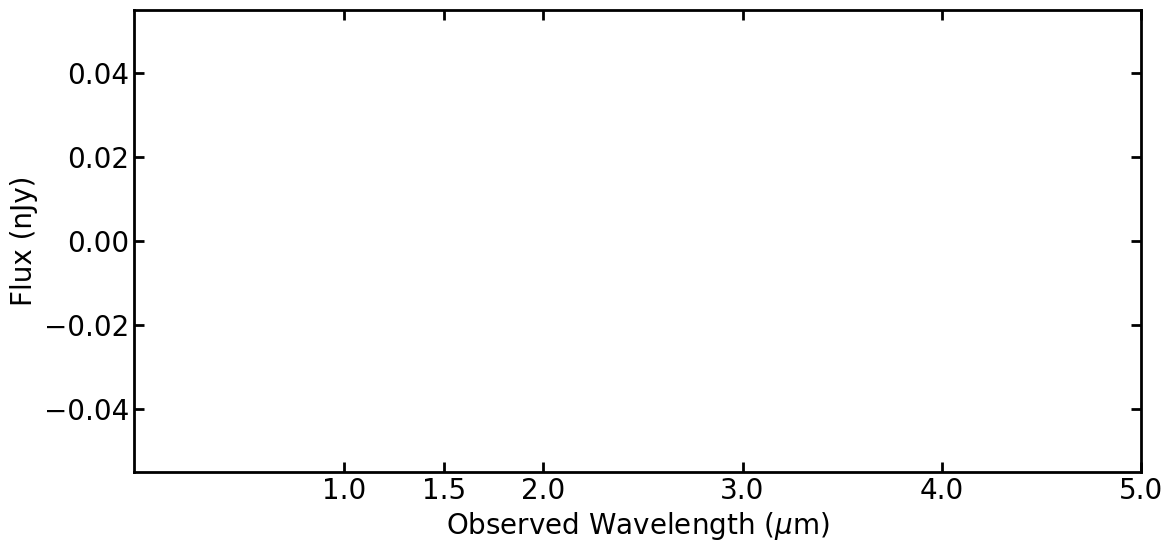

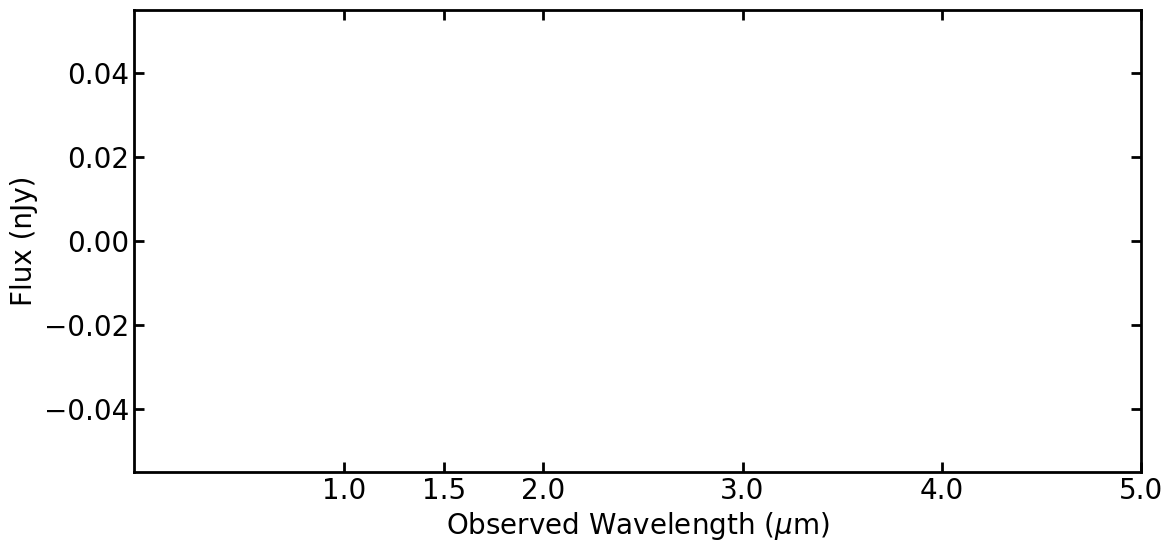

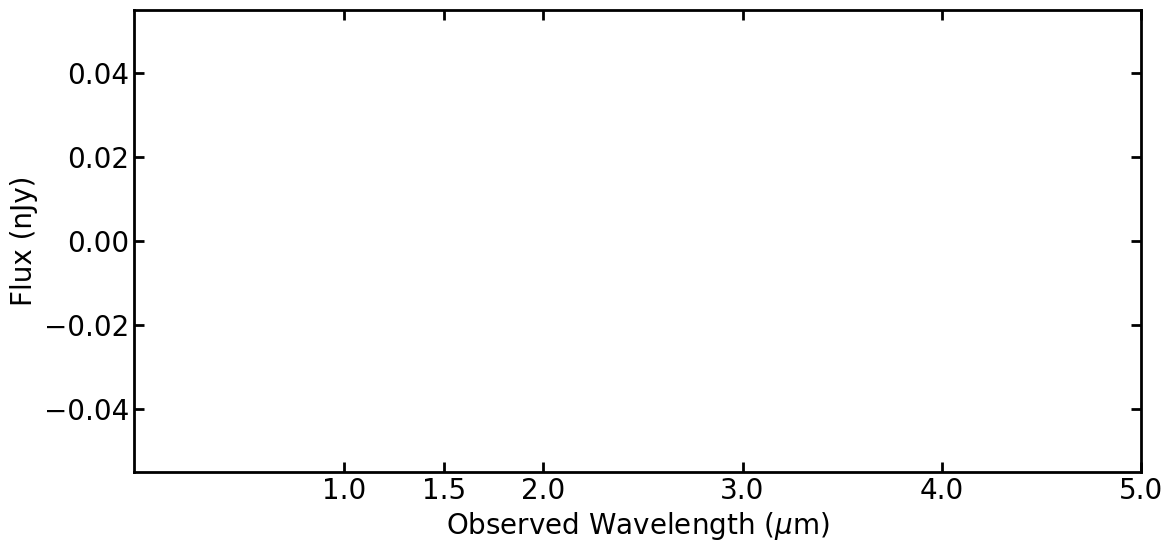

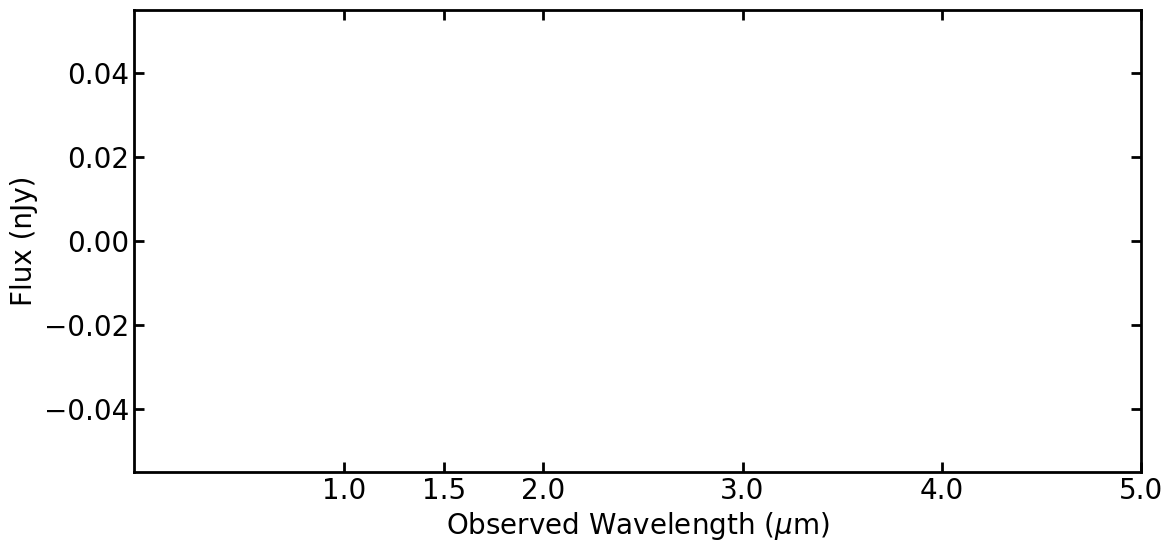

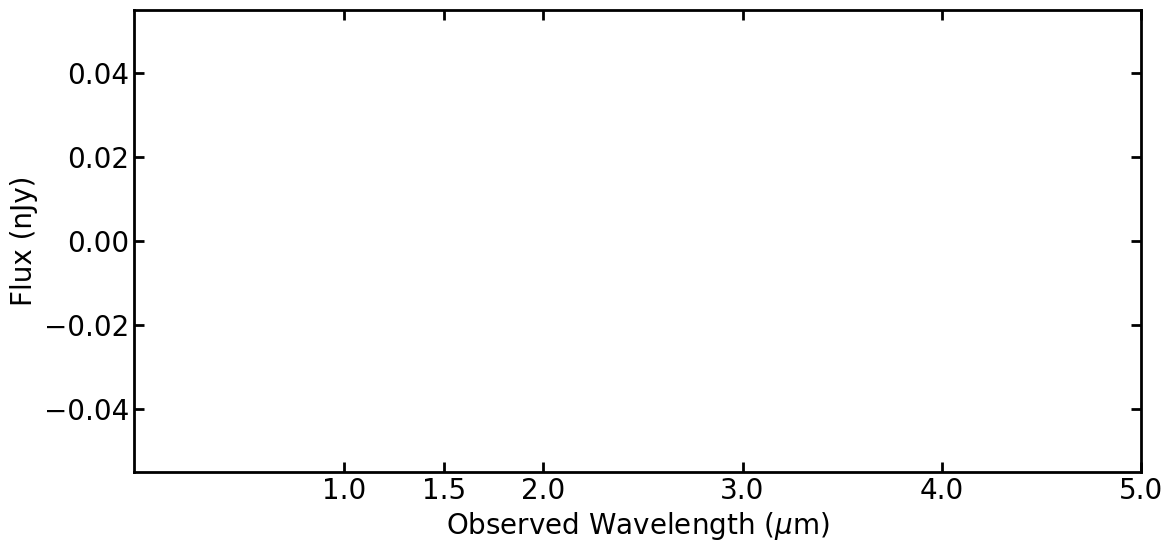

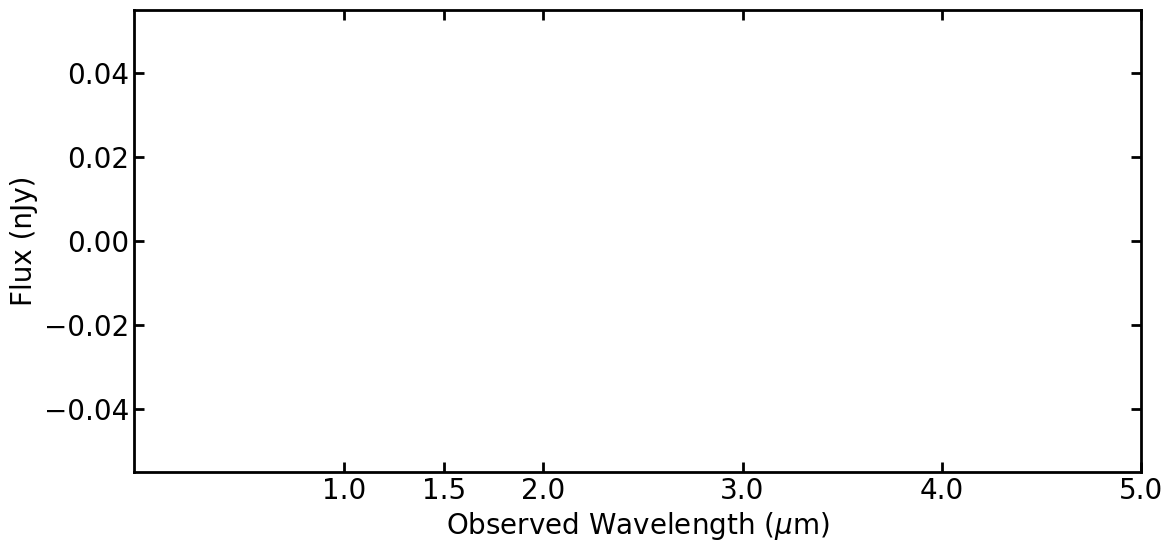

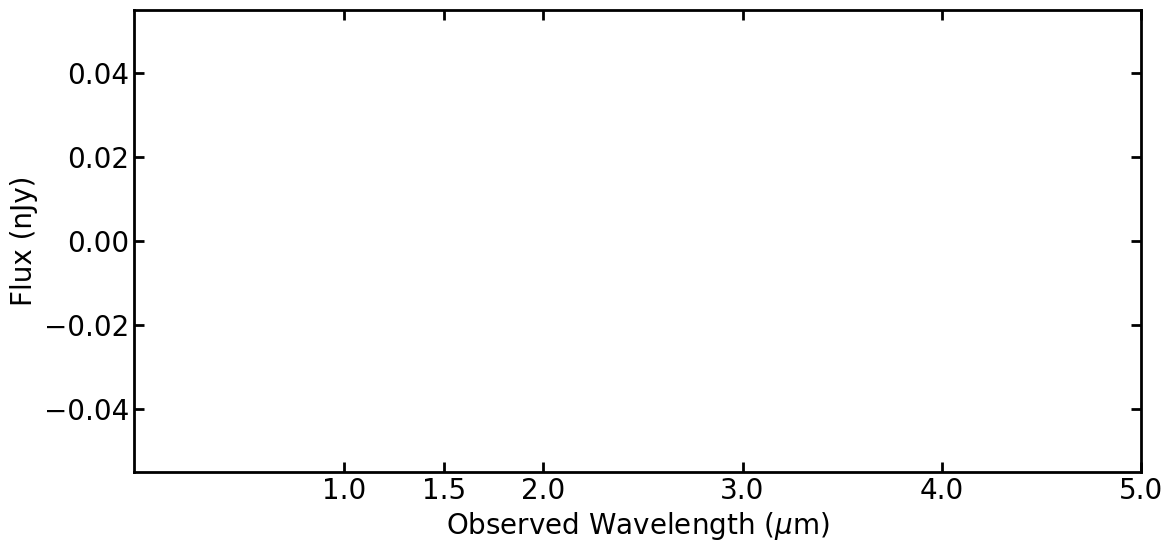

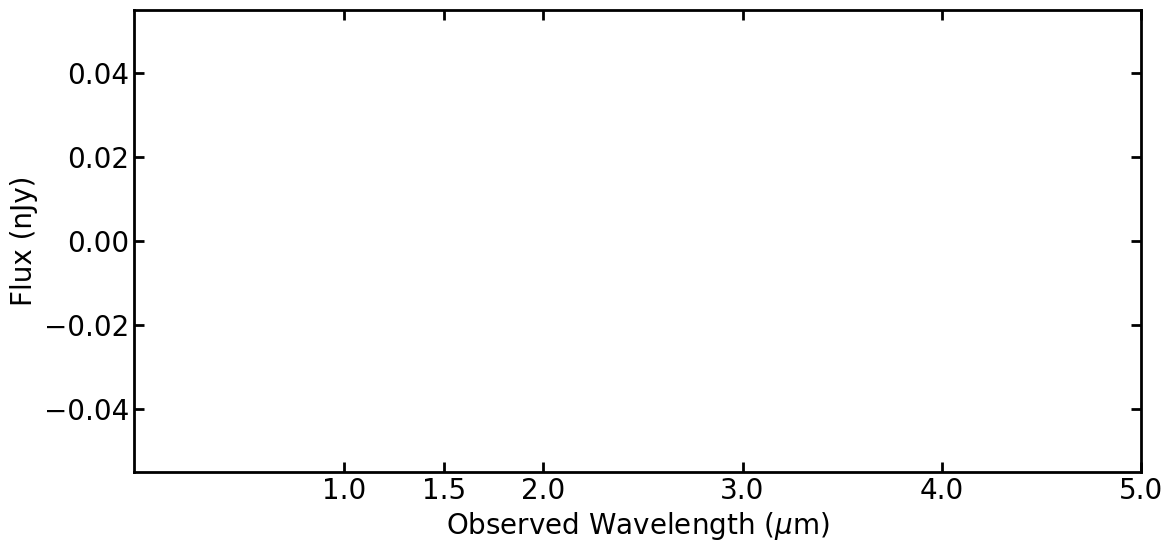

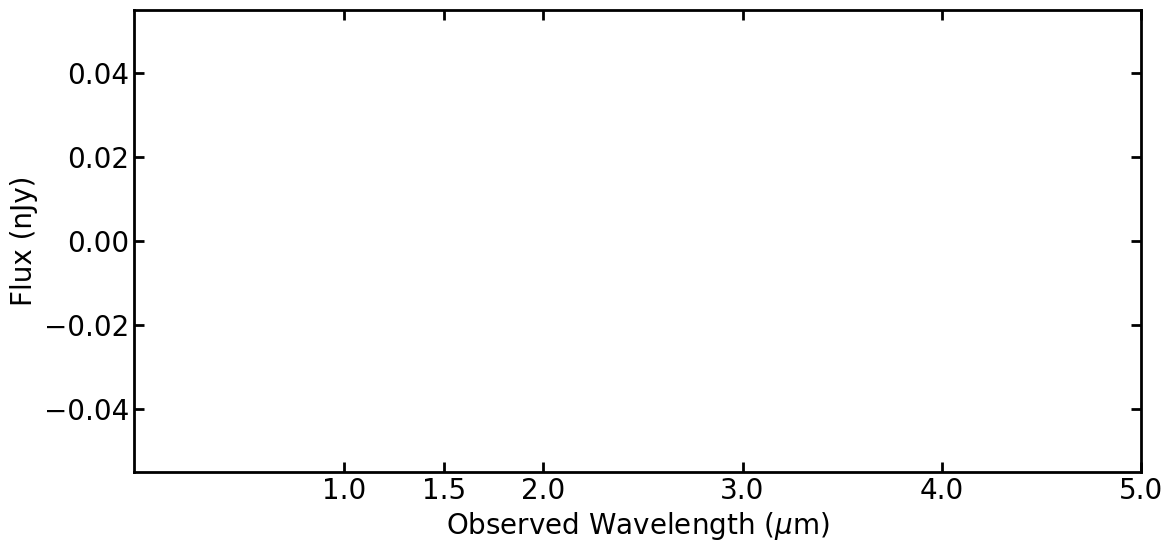

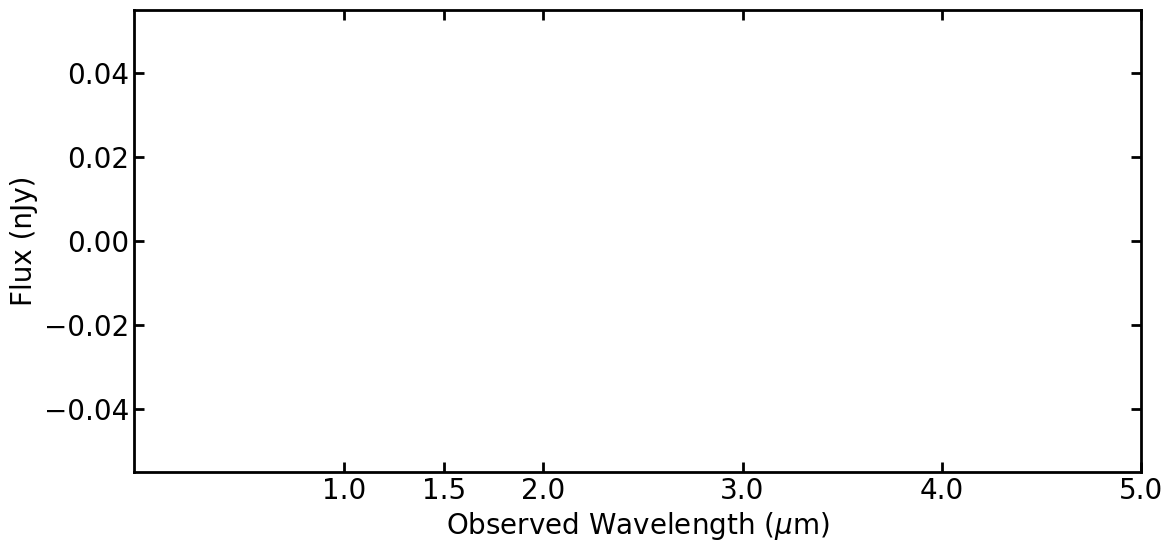

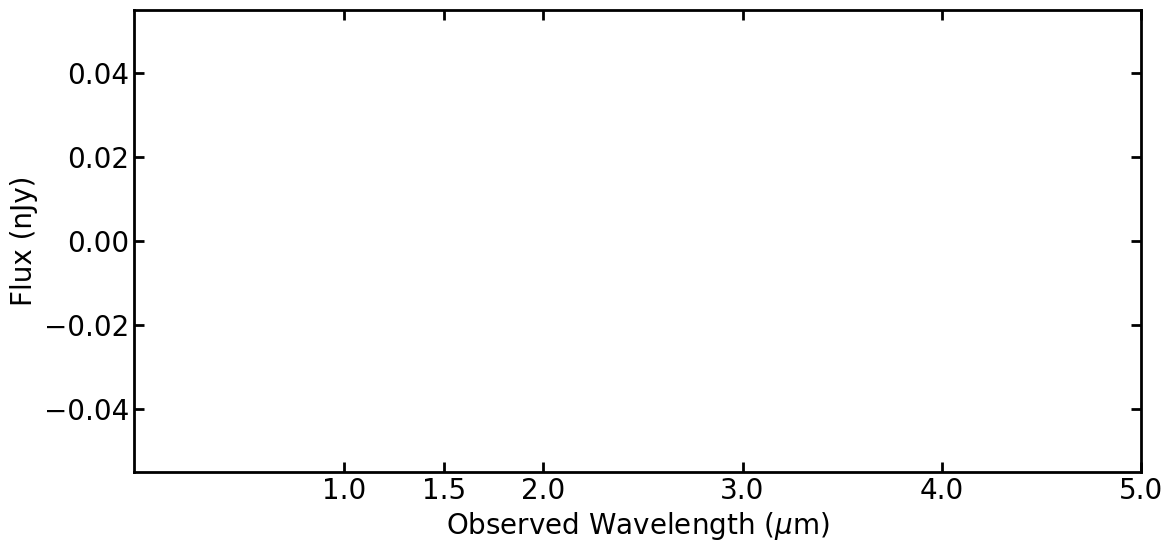

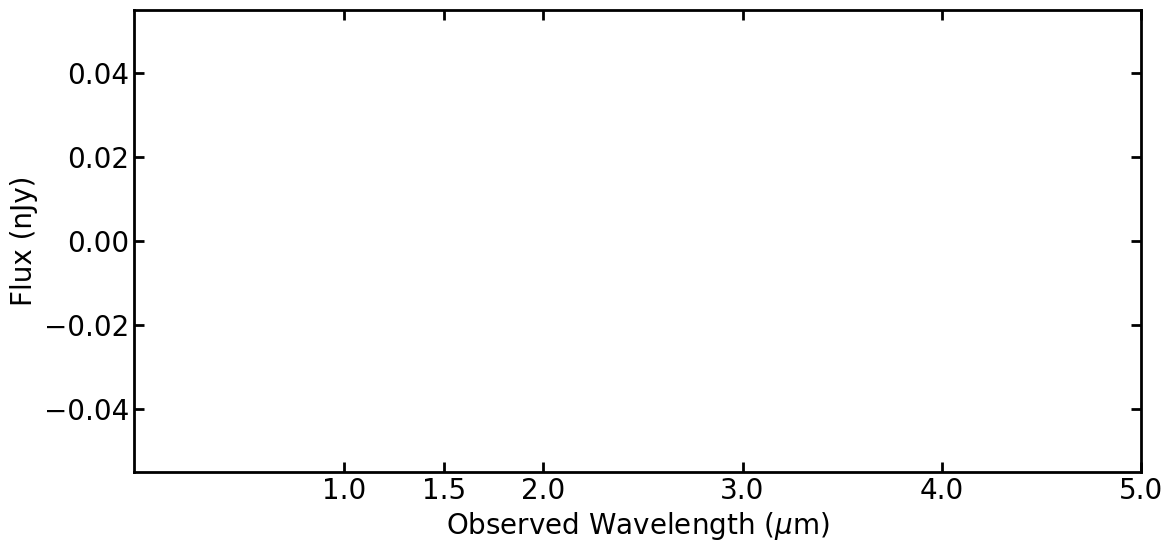

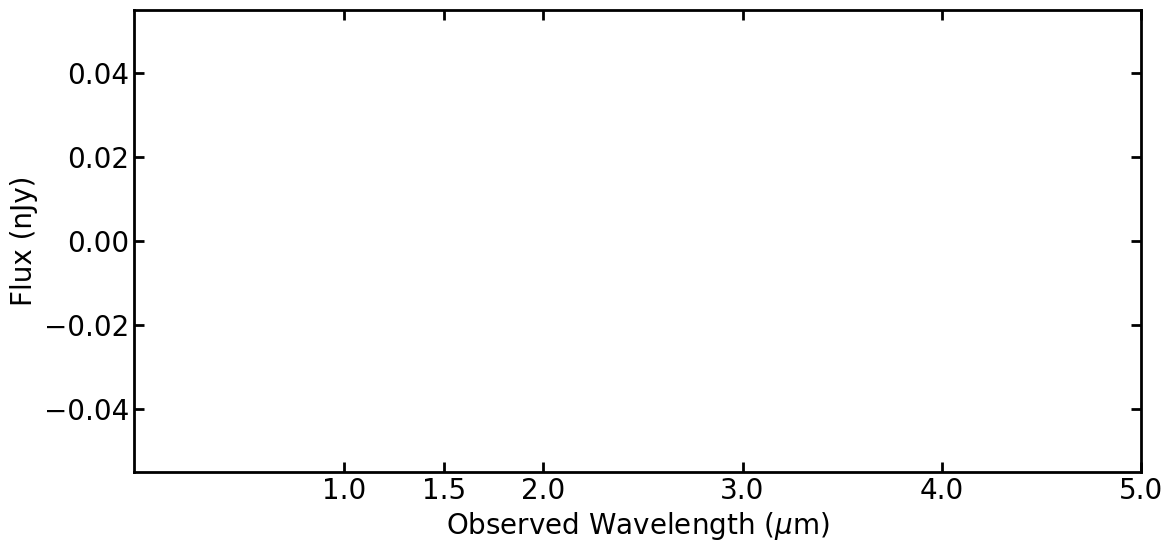

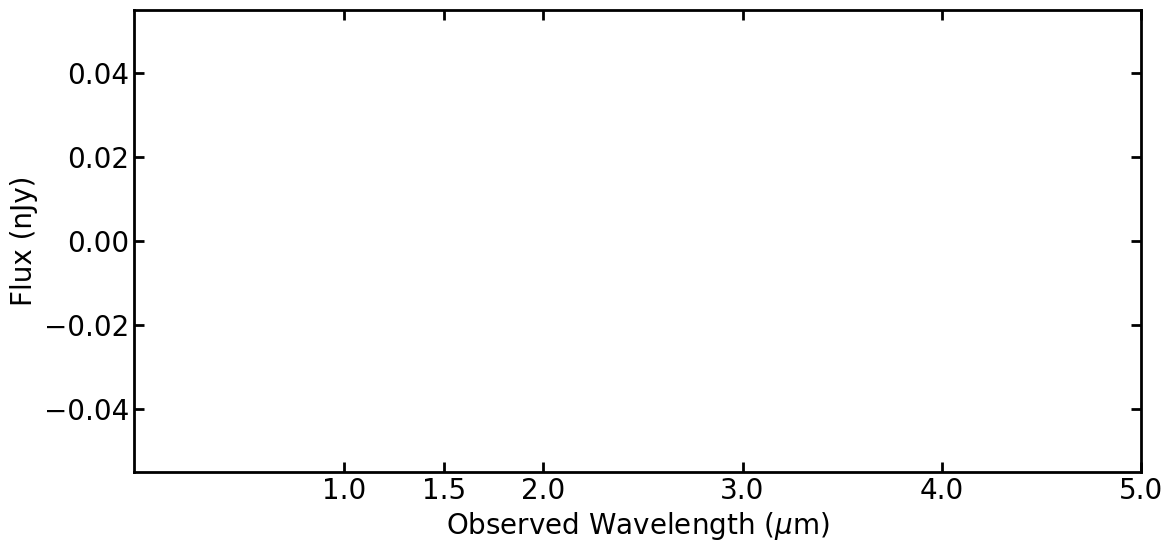

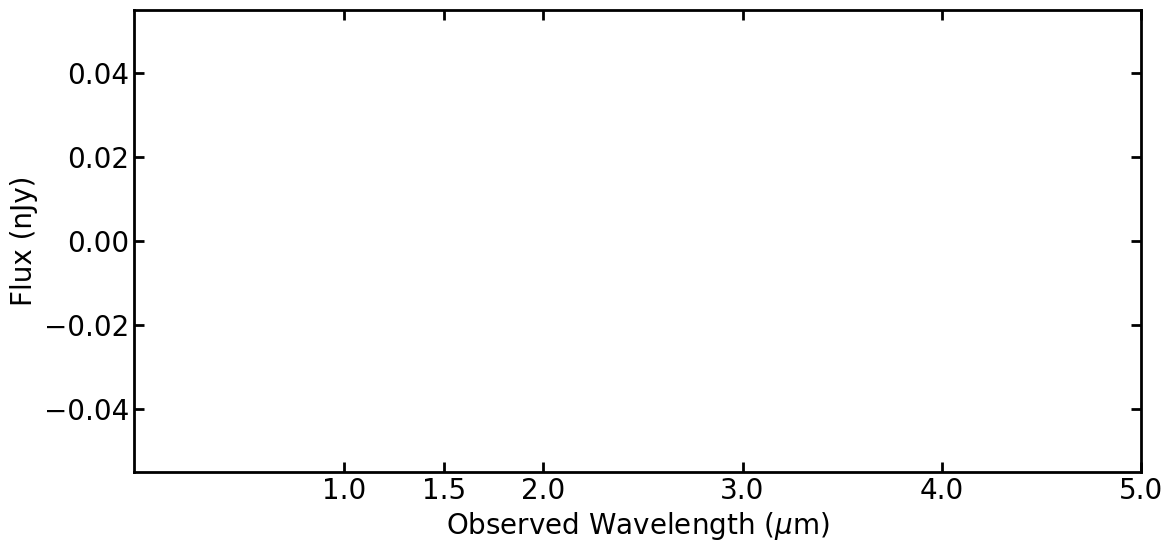

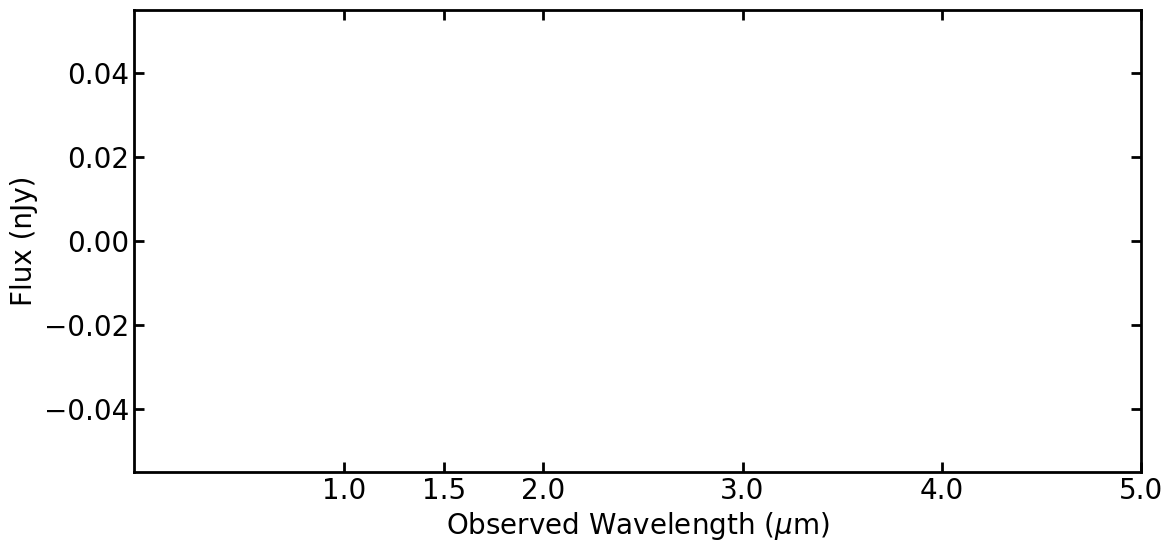

In [93]:
#calculate NUV luminosity from photometry

# 定义波长转换函数（基于宇宙学红移）
def obs_to_rest(λ_obs):
    """将观测波长转换为静止波长"""
    return λ_obs / (1 + z) *10000

def rest_to_obs(λ_rest):
    """将静止波长转换为观测波长"""
    return λ_rest * (1 + z) / 10000

savetop = '/Users/zijianzhang/Astro_Data/LRD_SPEC/all_SEDs/'
os.makedirs(savetop, exist_ok=True)
imgsize = 1.5

catalog['L_NUV'] = np.nan
catalog['L_FUV'] = np.nan
for ind in range(len(catalog)):
# for ind in range(1):
    # ind = 0
    id = catalog['ID'][ind]
    srcid = catalog['srcid'][ind]


    print('ID:', id)
    z = catalog['z'][ind]
    print('redshift:', z)
    # if(z == 0):
    #     z = catalog[ind]['z_phot']
    fig = plt.figure(figsize=(13, 6))
    large_subplot = fig.add_subplot(111)

    names = ['ID '+ str(i) for i in [catalog[ind]['ID']]]    #['ID 41841','ID 41842']
    symbollist = ['o','p','d','X','P']
    colorlist = ['orange',
                 'blue',  # 赤土
                 'green', 'black', 'purple']
    factorlist = [1, 1]
    # for src_index, name, symbol, color, factor in zip(range(len(catalog[ind])), names, symbollist, colorlist,factorlist):
    #     ind_ = np.arange(len(catalog[ind])) == src_index
    #     df = catalog[ind][ind_].to_pandas()
    df = catalog[ind:ind+1].to_pandas()
    # NIRCAM_flux 
    NIRCAM_wave, NIRCAM_flux, NIRCAM_flux_errors = plot_SED_src(large_subplot, df, names[0], symbollist[0], colorlist[0], factorlist[0])
    NIRCAM_restwave = NIRCAM_wave/(1+z)*10000

    savepath = savetop + str(srcid) +'fit.png'
    try:
        L_NUV, L_FUV = get_UV_flux(NIRCAM_restwave, NIRCAM_flux, NIRCAM_flux_errors, z, savepath)
        catalog['L_NUV'][ind] = L_NUV
        catalog['L_FUV'][ind] = L_FUV
    except:
        L_NUV, L_FUV = np.nan, np.nan
        catalog['L_NUV'][ind] = L_NUV
        catalog['L_FUV'][ind] = L_FUV
        continue
        
    

    large_subplot.scatter(restwave*(1+z), fnu/np.nanmean(fnu)*np.nanmean(NIRCAM_flux)*2, s=100, c='#E16B8C', marker='x', label='Akin24 mean SED')
    large_subplot.text(0.1, 0.7, f'z={np.round(z, 3)}', fontsize=20, transform=large_subplot.transAxes)
    # large_subplot.text(0.1, 0.6, catalog[ind]['method'], fontsize=20, transform = large_subplot.transAxes)
    # large_subplot.set_ylim(2, 1e3)
    large_subplot.legend(fontsize=20, loc='upper left')
    # large_subplot.set_yscale('log')
    # large_subplot.set_xscale('log')
    
    goodfilter = NIRCAM_filter
    ax2 = large_subplot.twinx()
    for name in goodfilter:
        file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/mean_throughputs/' + name + '_mean_system_throughput.txt'
        try:
            wavelength, throughput = read_filter_data(file)
        except:
            continue
        ax2.plot(wavelength, throughput, color='orange', linestyle='-', alpha=0.5, label=f'{name} throughput')
        # 在曲线上标注波段名称
        max_throughput_index = np.argmax(throughput)
        max_wavelength = wavelength[max_throughput_index]
        max_value = throughput[max_throughput_index]
        ax2.text(np.mean(wavelength) - 0.1, max_value/2, name, fontsize=10, color='black', verticalalignment='bottom')
    # large_subplot.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    #标记红移
    ax2.set_ylim(0.,3.5)
    #隐藏ax2
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # ax2.spines['bottom'].set_visible(False)
    # 隐藏副轴的刻度线和刻度标签
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.yaxis.set_ticks([])
    # ax2.xaxis.set_ticks([])

    mark_emission_lines(ax2,z)
    large_subplot.set_xlim(0.7, 5.2)
    large_subplot.set_ylim(0, max(NIRCAM_flux)*1.1)

    # 创建顶部x轴显示静止波长
    ax_top = large_subplot.secondary_xaxis(
        'top',
        functions=(obs_to_rest, rest_to_obs)
    )
    # 关闭large_subplot的顶部刻度
    large_subplot.tick_params(axis='x', top=False)

    ax_top.set_xlabel('Rest Wavelength (Å)')
    # 优化刻度标签格式
    # ax.xaxis.set_major_formatter('{x:.0f}')
    ax_top.xaxis.set_major_formatter('{x:.0f}')


    plt.tight_layout()
    plt.savefig(savetop + str(srcid) +'.png', dpi=300, bbox_inches='tight')
    plt.close()



In [91]:
NIRCAM_restwave

array([], dtype=float64)

In [94]:
# catalog.write('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/UDS_lrd_catalog.txt', format='ascii', overwrite=True)
catalog.write('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/all_lrd_catalog.txt', format='ascii', overwrite=True)

In [95]:
catalog

<Table length=294>
     ID         Ra_1    ...         L_NUV                  L_FUV         
   str13      float64   ...        float64                float64        
------------ ---------- ... ---------------------- ----------------------
        4535   3.530005 ...  1.807982020629444e+44   3.12938291147565e+44
        3989   3.533994 ...  5.998835949190748e+44 3.0390332196134188e+44
       23608   3.542815 ...  5.476856629356304e+44  6.669250330358982e+44
        9904   3.550837 ... 2.2022708329535887e+44 2.7503605699941468e+44
       26742   3.567011 ... 2.0977243274383039e+43  4.608982619998272e+43
       25119    3.56959 ... 1.1169170102219831e+44  7.190478924371993e+43
GLASS_150029   3.577167 ... 2.6951379540436004e+44  3.809107249641667e+44
GLASS_150029   3.577167 ... 2.6949991103821793e+44  3.808920289816094e+44
        9497   3.579833 ...  2.116148243262647e+44 3.4315621791553895e+44
        9497   3.579833 ...  2.115899674722863e+44 3.4311451058745155e+44
         ...        ... ...                    ...                    ...
 CEERS_01236 215.145292 ...                    nan                    nan
 CEERS_01236 215.145292 ...                    nan                    nan
 CEERS_01665 215.178208 ...                    nan                    nan
 CEERS_01665 215.178208 ...                    nan                    nan
 CEERS_01665 215.178208 ...                    nan                    nan
 CEERS_01665 215.178208 ...                    nan                    nan
 CEERS_01244 215.240667 ...                    nan                    nan
 CEERS_01244 215.240667 ...                    nan                    nan
 CEERS_01244 215.240667 ...                    nan                    nan
 CEERS_01244 215.240667 ...                    nan                    nan

In [42]:
NIRCAM_restwave, NIRCAM_flux, NIRCAM_flux_errors

(array([1384.36482085, 1773.09323336, 2306.25038412, 3057.58711819]),
 array([50.35808568, 61.52894477, 76.80615335, 72.8049091 ]),
 array([21.43577941, 21.12749873, 16.73907642, 14.08994155]))

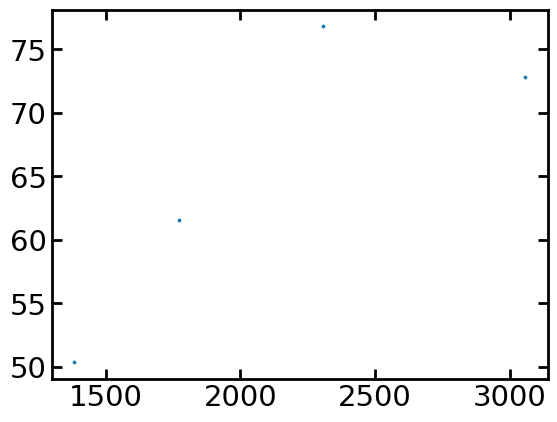

In [44]:
plt.scatter(NIRCAM_restwave, NIRCAM_flux, s=3)

Rest-frame NUV flux: 3.402e+44 erg/s
Rest-frame FUV flux: 3.615e+44 erg/s


(3.4019103164380273e+44, 3.615027536130918e+44)

In [22]:
# 创建一个空列表来存储每个源的信息
data_list = []

# 遍历catalog
for ind in range(len(catalog)):
    srcindex = catalog[ind]['index']  # 获取源的索引
    z = catalog[ind]['zbest']  # 获取红移值
    
    NIRCAM_MAG = np.array(list(catalog[ind][NIRCAM_key]))
    NIRCAM_MAGerr = np.array(list(catalog[ind][NIRCAM_errkey]))
    NIRCAM_FLAGS = np.array(list(catalog[ind][NIRCAM_flagkey]))
    
    mask = (NIRCAM_MAG != 99) * (NIRCAM_MAGerr > 0)
    NIRCAM_flux = abmag_to_nJy(NIRCAM_MAG)/1e6
    NIRCAM_fluxerr = abmag_to_nJyerr(NIRCAM_MAG, NIRCAM_MAGerr)/1e6
    
    NIRCAM_wave = np.array(NIRCAMwave)[mask]
    # NIRCAM_flux = NIRCAM_flux[mask]
    # NIRCAM_fluxerr = NIRCAM_fluxerr[mask]
    
    # 假设你有NIRCAM的具体波段名称以及与之对应的flux和flux_err
    row_data = [srcindex, z]
    
    # 假设你有对应波段的索引（例如，F090W是第0个，F115W是第1个，等等）
    # 如果需要手动指定波段顺序，可以修改这里
    for band, band_err in zip(NIRCAM_flux, NIRCAM_fluxerr):
        row_data.append(band)
        row_data.append(band_err)
    
    # 将这一行加入列表
    data_list.append(row_data)

# 指定表头，假设NIRCAM_wave按顺序排列波段
colnames = ['id', 'redshift', 'jwst.nircam.F090W', 'jwst.nircam.F090W_err',
            'jwst.nircam.F115W', 'jwst.nircam.F115W_err',
            'jwst.nircam.F150W', 'jwst.nircam.F150W_err',
            'jwst.nircam.F200W', 'jwst.nircam.F200W_err',
            'jwst.nircam.F277W', 'jwst.nircam.F277W_err',
            'jwst.nircam.F356W', 'jwst.nircam.F356W_err',
            'jwst.nircam.F410M', 'jwst.nircam.F410M_err',
            'jwst.nircam.F444W', 'jwst.nircam.F444W_err']

# 将数据转换为Astropy Table
t = Table(rows=data_list, names=colnames)

# 保存为文件，例如CSV或FITS
t.write('nircam_flux_table.csv', format='csv', overwrite=True)

In [26]:
t.write('/data0/zijianzhang/sedfitting/examples/LRD/JWST/nircam_flux_table_all.txt', format='csv', overwrite=True, delimiter=' ')

In [28]:
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile
import glob
import webbpsf
from webbpsf.utils import to_griddedpsfmodel
import os
if not os.environ.get('WEBBPSF_PATH'):
    os.environ['WEBBPSF_PATH'] = '/data0/zijianzhang/JWST/crds_cache/webbpsf-data'
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

psfs_dir = 'PSF_MODELS/'
det = 'NRCA1'
# filt = 'F335M'
# if not os.path.exists(psfs_dir):
#     os.makedirs(psfs_dir)

for index in ['584', '593', '621']:

    cutoutsave = '/JDisk16T_1/zijianzhang/phot_catalog/cutoutsave/'
    cutoutfile = glob.glob(cutoutsave + f'{index}*W.fits') + glob.glob(cutoutsave + f'{index}*M.fits')
    cutoutfile.sort()
    num_plots = len(cutoutfile)
    num_cols = 4  # Number of columns for subplots
    num_rows = (num_plots + num_cols - 1) // num_cols  # Automatically determine number of rows 

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8), sharex=True, sharey=True)
    nc = webbpsf.NIRCam()   

    for i,file in enumerate(cutoutfile):
        # file = cutoutfile[0]
        row = i // num_cols
        col = i % num_cols
        band = file.split('/')[-1].split('_')[-1].split('.')[0]
        data = fits.getdata(file)
        error = fits.getdata(file.replace('.fits', '.err.fits'))    

        nc.filter =  band   

        if(band < 'F277W'): 

            psf = nc.calc_psf(oversample=1,fov_arcsec = 2) 
        else:
            psf = nc.calc_psf(oversample=2,fov_arcsec = 2)  

        psfdata = psf[0].data
        psferror = np.zeros_like(psfdata)   

        xycen = centroid_quadratic(data, xpeak=25, ypeak=25)
        print(xycen)  
        edge_radii = np.arange(25)
        rp = RadialProfile(data, xycen, edge_radii, error=error, mask=None)
        rp.normalize(method='max')

        xycen = centroid_quadratic(psfdata, xpeak=31, ypeak=31)
        print(xycen)  
        edge_radii = np.arange(30)
        rp_psf = RadialProfile(psfdata, xycen, edge_radii, error=psferror, mask=None)
        rp_psf.normalize(method='max')  

        axes[row, col].errorbar(rp.radius*0.03, rp.profile, yerr=rp.profile_error, fmt='o', color='blue')
        axes[row, col].plot(rp_psf.radius*0.03, rp_psf.profile, color='red')
        axes[row, col].set_yscale('log')
        # axes[row, col].set_ylim(1e-3, 0.6)
        axes[row, col].set_xlim(0, 0.7)
        axes[row, col].set_title(band, fontsize=20)
        if row == num_rows - 1:
            axes[row, col].set_xlabel('Radius (arcsec)', fontsize=20)   

        if col == 0:
            axes[row, col].set_ylabel('Normalized SB', fontsize=20)
    
    plt.tight_layout()
    plt.savefig(savetop + f'{index}_radial_profile.pdf', dpi=300, bbox_inches='tight')


In [75]:
RadialProfile

photutils.profiles.radial_profile.RadialProfile

KeyError: 'RA_2'

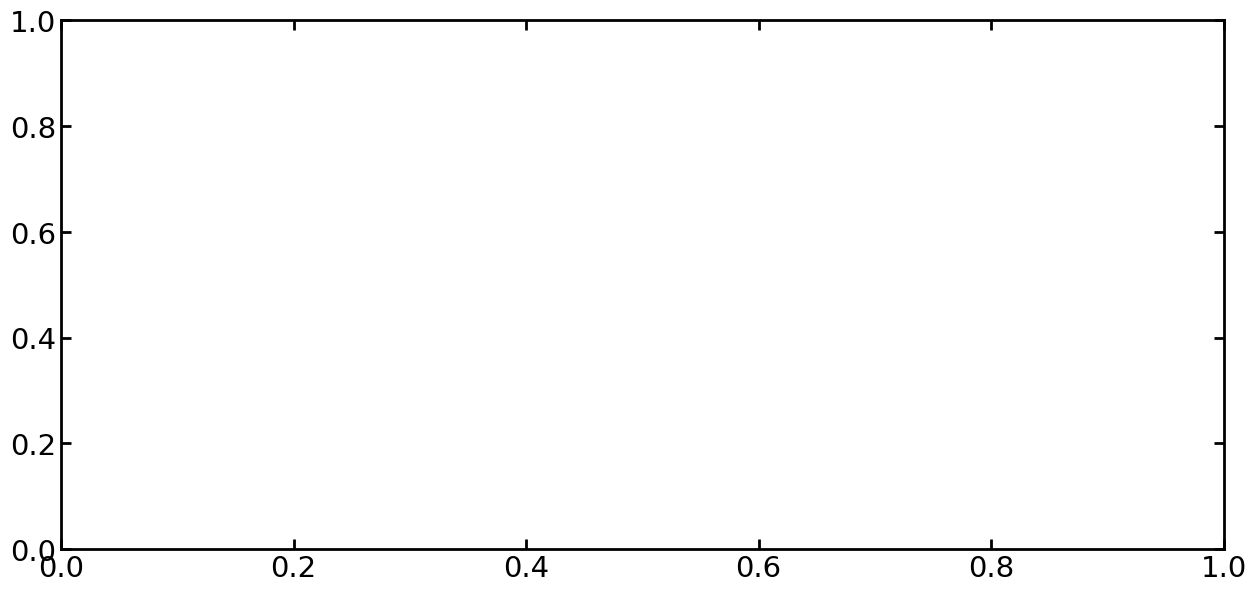

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.convolution import Tophat2DKernel
import astropy.units as u
import numpy as np
import os

# savetop = '/JDisk16T_1/zijianzhang/LRD_SED/ECDFS/'
savetop = '/JDisk16T_1/zijianzhang/LRD_SED/COSMOS/'
os.makedirs(savetop, exist_ok=True)
imgsize = 1.5

for ind in range(len(catalog)):
    # if(ind != 67): continue

    z = catalog[ind]['z_spec']
    if(z == 0):
        z = catalog[ind]['z_phot']
    fig = plt.figure(figsize=(15, 9))
    
    # 创建GridSpec对象，调整行高比例和子图间距
    gs = GridSpec(3, 12, figure=fig, height_ratios=[4, 1, 1], hspace=0.4, wspace=0.0)

    # 添加SED plot
    large_subplot = fig.add_subplot(gs[0:2, :])
    position = SkyCoord(catalog[ind]['RA_2'], catalog[ind]['DEC_2'], frame='icrs', unit=u.deg)

    num = 0
    goodfilter = []
    for i in range(2, 3):  # 四行
        col = 0
        for j in range(12):  # 十一列
            

            if(num >= len(NIRCAM_filter)):
                continue

            file = img_filelist[num]
            wcs = WCS(fits.getheader(file, 1))
            data = fits.getdata(file)

            kernel = Tophat2DKernel(1)
            try:
                cutout = Cutout2D(data, position, imgsize*u.arcsec, wcs=wcs)
            except:
                cutout = 0
                print('no overlap')
                continue

            if(np.isnan(cutout.data).all()):
                num += 1
                # j = j - 1
                continue
            try:
                small_subplot = fig.add_subplot(gs[i, col])
                col += 1
                small_subplot.set_aspect('equal')
                small_subplot.set_xticks([])
                small_subplot.set_yticks([])
                small_subplot.text(0.01, 0.97, NIRCAM_filter[num], transform=small_subplot.transAxes, fontsize=10, va='top', ha='left', fontweight='bold')
                interval = MinMaxInterval()
                vmin, vmax = interval.get_limits(cutout.data)
                norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())
                small_subplot.imshow(cutout.data, origin='lower', cmap='RdBu_r', norm=norm)
                goodfilter.append( NIRCAM_filter[num])
            except:
                pass

            num += 1

    NIRCAM_MAG = np.array(list(catalog[ind][NIRCAM_key]))
    NIRCAM_MAGerr = np.array(list(catalog[ind][NIRCAM_errkey]))
    NIRCAM_FLAGS = np.array(list(catalog[ind][NIRCAM_flagkey]))
    mask = (NIRCAM_MAG != 99) * (NIRCAM_MAGerr > 0)
    # NIRCAM_flux = NIRCAM_MAG
    # NIRCAM_fluxerr = NIRCAM_MAGerr
    NIRCAM_flux = abmag_to_nJy(NIRCAM_MAG)#/1e3
    NIRCAM_fluxerr = abmag_to_nJyerr(NIRCAM_MAG, NIRCAM_MAGerr)#/1e3
    NIRCAM_wave = np.array(NIRCAMwave)[mask]
    NIRCAM_flux = NIRCAM_flux[mask]
    NIRCAM_fluxerr = NIRCAM_fluxerr[mask]

    large_subplot.errorbar(NIRCAM_wave, NIRCAM_flux, [NIRCAM_fluxerr], 
                           color='green', ecolor='green', fmt='o', markersize=15,
                           elinewidth=0.5, capsize=2, capthick=1, markerfacecolor='none')
    large_subplot.tick_params(axis='both', which='major', labelsize=20, direction='in')
    large_subplot.set_xlabel(r'Observed Wavelength $(\mu \rm m)$', fontsize=20)
    # large_subplot.set_ylabel('MAG', fontsize=20)
    large_subplot.set_ylabel('Flux (nJy)', fontsize=20)
    large_subplot.set_yscale('log')
    large_subplot.text(0.7, 1.5, f'z={z}', fontsize=20)
    ax2 = large_subplot.twinx()
    for name in goodfilter:
        file = '/JDisk16T_1/zijianzhang/nircam_throughputs/mean_throughputs/' + name + '_mean_system_throughput.txt'
        wavelength, throughput = read_filter_data(file)
        ax2.plot(wavelength, throughput, color='orange', linestyle='-', alpha=0.5, label=f'{name} throughput')

        # 在曲线上标注波段名称
        max_throughput_index = np.argmax(throughput)
        max_wavelength = wavelength[max_throughput_index]
        max_value = throughput[max_throughput_index]
        ax2.text(np.mean(wavelength) - 0.1, max_value/2, name, fontsize=10, color='black', verticalalignment='bottom')

    large_subplot.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax2.set_ylim(0,3.5)
    #隐藏ax2
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # ax2.spines['bottom'].set_visible(False)

    # 隐藏副轴的刻度线和刻度标签
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.yaxis.set_ticks([])
    # ax2.xaxis.set_ticks([])
    
    mark_emission_lines(ax2,z)
    # large_subplot.set_xlim(0.7, 5.0)
    plt.tight_layout()
    # plt.show()
    plt.savefig(savetop + str(catalog['ID'][ind]) + '-' + str(catalog['index'][ind]) +'.png')
    plt.close()


In [ ]:
Jadekey = []
for i in range(len(jadekey)):
    Jadekey.append(jadekey[i])
    Jadekey.append(jadeerrkey[i])

MIRIKey = []
for i in range(len(MIRIkey)):
    Jadekey.append(MIRIkey[i])
    Jadekey.append(MIRIerrkey[i])

KEY = np.hstack([['NUMBER','EAZY_z_a'],Jadekey,MIRIKey])
catalog_sedfit = catalog[list(KEY)]


NameError: name 'jadekey' is not defined

In [ ]:
for index in range(len(MIRIkey)):
    MIRIflux = abmag_to_nJy(catalog_sedfit[MIRIkey[index]])
    MIRIfluxerr = abmag_to_nJyerr(catalog_sedfit[MIRIkey[index]],catalog_sedfit[MIRIerrkey[index]])
    catalog_sedfit[MIRIkey[index].replace('MAG','FLUX')] = MIRIflux
    catalog_sedfit[MIRIerrkey[index].replace('MAG','FLUX')] = MIRIfluxerr

    del catalog_sedfit[MIRIkey[index]]
    del catalog_sedfit[MIRIerrkey[index]]

In [ ]:
import pandas as pd

# 定义替换规则的字典
replacement_rules = {
    'F090W': ('jwst.nircam.F090W', 'jwst.nircam.F090W_err'),
    'F115W': ('jwst.nircam.F115W', 'jwst.nircam.F115W_err'),
    'F150W': ('jwst.nircam.F150W', 'jwst.nircam.F150W_err'),
    'F182M': ('jwst.nircam.F182M', 'jwst.nircam.F182M_err'),
    'F200W': ('jwst.nircam.F200W', 'jwst.nircam.F200W_err'),
    'F210M': ('jwst.nircam.F210M', 'jwst.nircam.F210M_err'),
    'F277W': ('jwst.nircam.F277W', 'jwst.nircam.F277W_err'),
    'F335M': ('jwst.nircam.F335M', 'jwst.nircam.F335M_err'),
    'F356W': ('jwst.nircam.F356W', 'jwst.nircam.F356W_err'),
    'F410M': ('jwst.nircam.F410M', 'jwst.nircam.F410M_err'),
    'F430M': ('jwst.nircam.F430M', 'jwst.nircam.F430M_err'),
    'F444W': ('jwst.nircam.F444W', 'jwst.nircam.F444W_err'),
    'F460M': ('jwst.nircam.F460M', 'jwst.nircam.F460M_err'),
    'F480M': ('jwst.nircam.F480M', 'jwst.nircam.F480M_err'),
    'F435W': ('hst.wfc.F435W', 'hst.wfc.F435W_err'),
    'F606W': ('hst.wfc.F606W', 'hst.wfc.F606W_err'),
    'F775W': ('i_goods', 'i_goods_err'),
    'F814W': ('hst.wfc.F814W', 'hst.wfc.F814W_err'),
    'F850LP': ('hst.wfc.F850LP', 'hst.wfc.F850LP_err'),
    'F105W': ('HST-WFC3_IR.F105W', 'HST-WFC3_IR.F105W_err'),
    'F125W': ('hst.wfc3.F125W', 'hst.wfc3.F125W_err'),
    'F140W': ('hst.wfc3.F140W', 'hst.wfc3.F140W_err'),
    'F160W': ('hst.wfc3.F160W', 'hst.wfc3.F160W_err'),
    '560': ('jwst.miri.F560W', 'jwst.miri.F560W_err'),
    '770': ('jwst.miri.F770W', 'jwst.miri.F770W_err'),
    '1000': ('jwst.miri.F1000W', 'jwst.miri.F1000W_err'),
    '1280': ('jwst.miri.F1280W', 'jwst.miri.F1280W_err'),
    '1500': ('jwst.miri.F1500W', 'jwst.miri.F1500W_err'),
    '1800': ('jwst.miri.F1800W', 'jwst.miri.F1800W_err'),
    '2100': ('jwst.miri.F2100W', 'jwst.miri.F2100W_err'),
    '2550': ('jwst.miri.F2550W', 'jwst.miri.F2550W_err'),
    'NUMBER':('id','id'),
    'EAZY_z_a':('redshift','redshift')
}

# 替换函数
def replace_key(key):
    for rule in replacement_rules:
        if rule in key:
            return replacement_rules[rule][1] if '_e' in key or 'ERR' in key else replacement_rules[rule][0]

    return key

# 对 keys 列进行替换



In [ ]:
for column in catalog_sedfit.keys():   
        catalog_sedfit[replace_key(column)] = catalog_sedfit[column]
        del catalog_sedfit[column]

for column in catalog_sedfit.keys()[2:]:
    catalog_sedfit[column] = catalog_sedfit[column]/1e6

In [ ]:
for col in catalog_sedfit.columns[2:]:
    catalog_sedfit[col][(catalog_sedfit[col] == 0).data | (np.array([str(i) for i in catalog_sedfit[col]])=='--')] = -99

In [ ]:
# 选择不包含 'miri' 的列名
filtered_columns = [colname for colname in catalog_sedfit.colnames if 'miri' not in colname]

# 创建一个新的 Table，只包含过滤后的列
new_catalog_sedfit = Table({colname: catalog_sedfit[colname] for colname in filtered_columns})


In [ ]:
catalog_sedfit.write('/Users/zijianzhang/Library/Mobile Documents/com~apple~CloudDocs/Documents/Lesson_material/Gra1_Sem1/GalaxyPhysics/cigale-manual/examples/JWST/catalog_sedfit.txt', format='ascii',overwrite=True)

In [ ]:
new_catalog_sedfit.write('/Users/zijianzhang/Library/Mobile Documents/com~apple~CloudDocs/Documents/Lesson_material/Gra1_Sem1/GalaxyPhysics/cigale-manual/examples/JWST/catalog_sedfit_withoutmiri.txt', format='ascii',overwrite=True)

In [ ]:
from pprint import pprint
pprint(catalog_sedfit.keys())

['id',
 'redshift',
 'jwst.nircam.F090W',
 'jwst.nircam.F090W_err',
 'jwst.nircam.F115W',
 'jwst.nircam.F115W_err',
 'jwst.nircam.F150W',
 'jwst.nircam.F150W_err',
 'jwst.nircam.F182M',
 'jwst.nircam.F182M_err',
 'jwst.nircam.F200W',
 'jwst.nircam.F200W_err',
 'jwst.nircam.F210M',
 'jwst.nircam.F210M_err',
 'jwst.nircam.F277W',
 'jwst.nircam.F277W_err',
 'jwst.nircam.F335M',
 'jwst.nircam.F335M_err',
 'jwst.nircam.F356W',
 'jwst.nircam.F356W_err',
 'jwst.nircam.F410M',
 'jwst.nircam.F410M_err',
 'jwst.nircam.F430M',
 'jwst.nircam.F430M_err',
 'jwst.nircam.F444W',
 'jwst.nircam.F444W_err',
 'jwst.nircam.F460M',
 'jwst.nircam.F460M_err',
 'jwst.nircam.F480M',
 'jwst.nircam.F480M_err',
 'hst.wfc.F435W',
 'hst.wfc.F435W_err',
 'hst.wfc.F606W',
 'hst.wfc.F606W_err',
 'hst.wfc.F775W',
 'hst.wfc.F775W_err',
 'hst.wfc.F814W',
 'hst.wfc.F814W_err',
 'hst.wfc.F850LP',
 'hst.wfc.F850LP_err',
 'HST-WFC3_IR.F105W',
 'HST-WFC3_IR.F105W_err',
 'HST-WFC3_IR.F125W',
 'HST-WFC3_IR.F125W_err',
 'HST-WFC3

In [ ]:
import numpy as np

# Define the redshift grid parameters
start_z = 0.01
end_z = 8.0
num_steps = 50

# Create an evenly spaced grid in terms of log(1 + z)
log1pz_grid = np.linspace(np.log1p(start_z), np.log1p(end_z), num_steps)

# Convert back to redshift (z) by subtracting 1
z_grid = np.expm1(log1pz_grid)

print(z_grid)


[0.01       0.05610602 0.10431676 0.1547283  0.2074411  0.26256022
 0.3201955  0.3804618  0.44347923 0.50937337 0.57827556 0.65032309
 0.72565956 0.8044351  0.88680671 0.97293855 1.06300226 1.15717734
 1.25565147 1.35862089 1.46629082 1.57887583 1.69660029 1.81969882
 1.94841674 2.08301058 2.22374855 2.37091115 2.52479165 2.68569673
 2.85394704 3.0298779  3.21383993 3.40619973 3.60734067 3.81766359
 4.03758766 4.26755116 4.50801238 4.75945054 5.02236674 5.29728494
 5.58475302 5.88534388 6.19965658 6.5283175  6.87198164 7.23133388
 7.60709039 8.        ]


In [ ]:
z_grid

array([0.01      , 0.05610602, 0.10431676, 0.1547283 , 0.2074411 ,
       0.26256022, 0.3201955 , 0.3804618 , 0.44347923, 0.50937337,
       0.57827556, 0.65032309, 0.72565956, 0.8044351 , 0.88680671,
       0.97293855, 1.06300226, 1.15717734, 1.25565147, 1.35862089,
       1.46629082, 1.57887583, 1.69660029, 1.81969882, 1.94841674,
       2.08301058, 2.22374855, 2.37091115, 2.52479165, 2.68569673,
       2.85394704, 3.0298779 , 3.21383993, 3.40619973, 3.60734067,
       3.81766359, 4.03758766, 4.26755116, 4.50801238, 4.75945054,
       5.02236674, 5.29728494, 5.58475302, 5.88534388, 6.19965658,
       6.5283175 , 6.87198164, 7.23133388, 7.60709039, 8.        ])